<a href="https://colab.research.google.com/github/Linglei1226/Econ_map/blob/main/Web_Scraping_on_Utah_Avalanche.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avalanche Data Scraping

## Scraping explore(Just explore)
Import necessary libraries

In [ ]:
import requests

# BeautifulSoup is a module inside the "bs4" library, we only import the BeautifulSoup module
from bs4 import BeautifulSoup

# We import pandas but give the library a shortcut alias "pd" since we will call its functions so much
import pandas as pd

Questions:

1. Will the variable "trigger" result in an avalanche of different severity? In other words, I was wondering if there is a difference in avalanche depth overall between all groups of triggers.
* Test: One-way ANOVA
* Plot: Box plot

look at avalanche data: https://utahavalanchecenter.org/avalanches.
I want the tidy format look like:

| *Date* | *Name* | *Region* | *Trigger* | *Depth* | *Width* |
| --- | --- | --- | --- | --- | --- |
| 2/13/2022 | Avalanche: Belicosity Bowl | Logan | Natural |  | 40' |
| 2/12/2022 | Avalanche: Santaquin Peak | Provo | Skier | 10" |5'|
| 2/12/2022 | Avalanche: Salt Lake | 	Salt Lake | Skier |  |
| 2/4/2022 | Avalanche: Brighton Hill | 	Salt Lake | Skier | 4" | 5'|



Use requests to get data from web, specify allowable user-agent

In [ ]:
avalanche_rawScrap = requests.get('https://utahavalanchecenter.org/avalanches', headers = {"User-Agent":'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.111 Safari/537.36'}).text

Use the beautifulSoup to parse raw scraping data in html way

In [ ]:
avalanche_soup = BeautifulSoup(avalanche_rawScrap, 'html.parser')

In [ ]:
print(avalanche_soup.prettify())

Uisng the inspect tool, I found that there is just one table for each page, and there are different threads in table. So I will find the div class = "view-content" first, then extract subcontent inside.

In [ ]:
# find the table content
# use find_all to find all <div class = 'view-content'>
avalanche_table_group = avalanche_soup.find_all('div', {'class': 'view-content'})
len(avalanche_table_group)
avalanche_table_group;

Then I will use the 'th' t extract the first row which is the feature names. 
1. `<th>`: variables names
2. `<td class="views-field views-field-field-occurrence-date">`: Date
3. `<td class= "views-field views-field-title">`: Title
4. `<td class= "views-field views-field-field-region-forecaster nowrap">`: Region
5. `<td class="views-field views-field-field-trigger">`: Trigger
6. `<td class="views-field views-field-field-depth views-align-right">`: Depth
7. `<td class="views-field views-field-field-width views-align-right">`: Width

In [ ]:
avalanche_true_group = avalanche_table_group[0].find_all('tr')
# create the column name from the group
columns = []
for item in avalanche_true_group[0].find_all('th'):
  columns.append(item.text)
# assign the name for the second column
columns[1] = 'Name' 
columns

['Date', 'Name', 'Region', 'Trigger', 'Depth', 'Width']

The date has been contained in `<td class="views-field views-field-field-occurrence-date">`

In [ ]:
# function to extract the single group data
def extract_info(group, keyword):
  new_list = []
  for i in range(1,len(group)):
    for item in group[i].find_all('td', {'class':keyword}):
      text = item.text.strip()
      new_list.append(text)
  return new_list

In [ ]:

# apply the function and extract the information
date = extract_info(avalanche_true_group, 'views-field views-field-field-occurrence-date')
type(date)
# convert the column to date time
date = pd.to_datetime(date)

# apply to extract title
title = extract_info(avalanche_true_group, 'views-field views-field-title')

# apply to extract region
region = extract_info(avalanche_true_group, 'views-field views-field-field-region-forecaster nowrap')

# apply to extract Trigger
trigger = extract_info(avalanche_true_group, 'views-field views-field-field-trigger')

# apply to extract Depth
depth = extract_info(avalanche_true_group, 'views-field views-field-field-depth views-align-right')

# apply to extract Width
width = extract_info(avalanche_true_group, 'views-field views-field-field-width views-align-right')

# print out check
print("title:")
print(title[:3])
print("region:")
print(region[:3])
print("trigger:")
print(trigger[:3])
print("depth:")
print(depth[:3])
print("width:")
print(width[:3])

title:
['Avalanche: Porter Fork', 'Avalanche: Cardiff Fork', 'Avalanche: Home Run']
region:
['Salt Lake', 'Salt Lake', 'Salt Lake']
trigger:
['', 'Natural', 'Natural']
depth:
['14"', '', '']
width:
["60'", '', '']


Now we can create the dataframe

In [ ]:
avalance_dataframe = pd.DataFrame({'Date': date,
                                   'Title': title,
                                   'Region': region,
                                   'Depth': depth,
                                   'Width': width})
avalance_dataframe.head(4)

,Date,Title,Region,Depth,Width
0,2022-02-28,Avalanche: Porter Fork,Salt Lake,"14""",60'
1,2022-02-28,Avalanche: Cardiff Fork,Salt Lake,,
2,2022-02-27,Avalanche: Home Run,Salt Lake,,
3,2022-02-27,Avalanche: Gold Basin,Moab,2',25'


Now we have the quite structured dataframe.

Check the tail and head

In [ ]:
avalance_dataframe.head()

,Date,Title,Region,Depth,Width
0,2022-02-28,Avalanche: Porter Fork,Salt Lake,"14""",60'
1,2022-02-28,Avalanche: Cardiff Fork,Salt Lake,,
2,2022-02-27,Avalanche: Home Run,Salt Lake,,
3,2022-02-27,Avalanche: Gold Basin,Moab,2',25'
4,2022-02-26,Accident: Tanners Gulch,Salt Lake,,


In [ ]:
avalance_dataframe.tail()

,Date,Title,Region,Depth,Width
45,2022-02-17,Avalanche: BBQ Bowl,Skyline,"6""",60'
46,2022-02-13,Avalanche: Belicosity Bowl,Logan,,40'
47,2022-02-12,Avalanche: Santaquin Peak,Provo,"10""",5'
48,2022-02-12,Avalanche: Salt Lake,Salt Lake,,
49,2022-02-04,Avalanche: Brighton Hill,Salt Lake,"4""",5'


## (Formal)Web Scraping the data

#### scraping

In [ ]:
# create a list for other pages' url
urls = []
for i in range(0,10):
  url = 'https://utahavalanchecenter.org/avalanches?page={pagename}'.format(pagename = i)
  urls.append(url)

In [ ]:
# check out the link
urls

['https://utahavalanchecenter.org/avalanches?page=0',
 'https://utahavalanchecenter.org/avalanches?page=1',
 'https://utahavalanchecenter.org/avalanches?page=2',
 'https://utahavalanchecenter.org/avalanches?page=3',
 'https://utahavalanchecenter.org/avalanches?page=4',
 'https://utahavalanchecenter.org/avalanches?page=5',
 'https://utahavalanchecenter.org/avalanches?page=6',
 'https://utahavalanchecenter.org/avalanches?page=7',
 'https://utahavalanchecenter.org/avalanches?page=8',
 'https://utahavalanchecenter.org/avalanches?page=9']

In [ ]:
# create a soup list
avalanche_rawScraps = []
for url in urls:
  avalanche_rawScrap = requests.get(url, headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36"}).text
  avalanche_rawScraps.append(avalanche_rawScrap)

In [ ]:
# create beautiful soups for each soup
avalanche_soups = []
for avalanche_rawScrap in avalanche_rawScraps:
  avalanche_soup = BeautifulSoup(avalanche_rawScrap, 'html.parser')
  avalanche_soups.append(avalanche_soup)

In [ ]:
# find the content table for each page
avalanche_table_groups = []
for avalanche_soup in avalanche_soups:
  avalanche_table_group = avalanche_soup.find_all('div', {'class': 'view-content'})
  avalanche_table_groups.append(avalanche_table_group)

In [ ]:
len(avalanche_table_groups)

10

In [ ]:
# find all true groups
avalanche_true_groups = []
for avalanche_table_group in avalanche_table_groups:
  avalanche_true_group = avalanche_table_group[0].find_all('tr')
  avalanche_true_groups.append(avalanche_true_group)

Then I will extract the following:

1. `<th>`: variables names
2. `<td class="views-field views-field-field-occurrence-date">`: Date
3. `<td class= "views-field views-field-title">`: Title
4. `<td class= "views-field views-field-field-region-forecaster nowrap">`: Region
5. `<td class="views-field views-field-field-trigger">`: Trigger
6. `<td class="views-field views-field-field-depth views-align-right">`: Depth
7. `<td class="views-field views-field-field-width views-align-right">`: Width

Extract dates from those pages

In [ ]:
# extract each column info from the content
# def for extracting column for whole column 
def extract_columns(groups, content):
  new_list = []
  for group in groups:
    item = extract_info(group, content)
    new_list.extend(item)
  return new_list

In [ ]:
# extract all columns
# dates
dates = extract_columns(avalanche_true_groups, 'views-field views-field-field-occurrence-date')
dates = pd.to_datetime(dates)

# titles
titles = extract_columns(avalanche_true_groups, 'views-field views-field-title')

# apply to extract region
regions = extract_columns(avalanche_true_groups, 'views-field views-field-field-region-forecaster nowrap')

# apply to extract Trigger
triggers = extract_columns(avalanche_true_groups, 'views-field views-field-field-trigger')

# apply to extract Depth
depths = extract_columns(avalanche_true_groups, 'views-field views-field-field-depth views-align-right')

# apply to extract Width
widths = extract_columns(avalanche_true_groups, 'views-field views-field-field-width views-align-right')

In [ ]:
avalance_data_all = pd.DataFrame({'Date': dates,
                                   'Title': titles,
                                   'Region': regions,
                                   'Trigger': triggers,
                                   'Depth': depths,
                                   'Width': widths})

### Check the package(for original data)

In [ ]:
avalance_data_all.shape

(500, 6)

So we have 550 observations and 6 variables.

### Check the tail and head(for original data)

In [ ]:
avalance_data_all.head()

,Date,Title,Region,Trigger,Depth,Width
0,2022-02-28,Avalanche: Cardiff Fork,Salt Lake,Natural,,
1,2022-02-28,Avalanche: Porter Fork,Salt Lake,,"14""",60'
2,2022-02-27,Avalanche: Home Run,Salt Lake,Natural,,
3,2022-02-27,Avalanche: Gold Basin,Moab,Skier,2',25'
4,2022-02-26,Avalanche: Ben Lomond,Ogden,Natural,,


In [ ]:
avalance_data_all.tail()

,Date,Title,Region,Trigger,Depth,Width
495,2021-02-17,Avalanche: Cardiac Ridge,Salt Lake,Natural,2',125'
496,2021-02-17,Avalanche: Pointy Peak,Salt Lake,Unknown,3',400'
497,2021-02-17,Avalanche: Butler Basin,Salt Lake,Natural,"16""",50'
498,2021-02-17,Avalanche: Hellgate,Salt Lake,Explosive,,
499,2021-02-17,Avalanche: White Pine,Salt Lake,Explosive,,


### Check the "n"s(for original data)

In [ ]:
# check the values counts for each counts
for column in avalance_data_all.columns:
  print(column)
  print(str(avalance_data_all[column].value_counts()))
  print()

Date
2021-02-17    43
2021-02-21    26
2021-03-14    23
2021-12-31    22
2021-12-18    22
              ..
2021-03-23     1
2021-12-22     1
2021-12-23     1
2021-12-28     1
2021-05-24     1
Name: Date, Length: 109, dtype: int64

Title
Avalanche: Moab              21
Avalanche: Timpanogos        12
Avalanche: White Pine         9
Avalanche: Superior           7
Avalanche: West Monitor       6
                             ..
Avalanche: Gods Lawnmower     1
Avalanche: Snowbasin          1
Avalanche: Lowry Fork         1
Avalanche: Days Fork          1
Avalanche: Hellgate           1
Name: Title, Length: 280, dtype: int64

Region
Salt Lake    278
Skyline       53
Logan         43
Uintas        41
Provo         39
Moab          26
Ogden         11
Southwest      8
SE Idaho       1
Name: Region, dtype: int64

Trigger
Natural        235
Skier          120
Unknown         64
Snowmobiler     27
Snowboarder     24
Explosive       17
                12
Hiker            1
Name: Trigger, dtype: i

### Validate against an external data source

External resource: https://avalanche.org/avalanche-encyclopedia/trigger/

According to the website, most avalanches are “naturally” triggered, meaning that weather (wind, snow, rain or sun) stresses the snowpack to its breaking point. I will check if the most frequent trigger in the dataset is "natural"

In [ ]:
avalance_data_all['Trigger'].value_counts()

Natural        235
Skier          120
Unknown         64
Snowmobiler     27
Snowboarder     24
Explosive       17
                12
Hiker            1
Name: Trigger, dtype: int64

### Deal with missing data

#### Deleting the observations with missing values


In [ ]:
import numpy as np
# # dropna
avalance_data_all = avalance_data_all.replace('',np.nan, regex=True)
avalance_data_all.tail()
avalance_drop = avalance_data_all.dropna().reset_index()

# # check out
len(avalance_drop)
avalance_drop.head(20)

,index,Date,Title,Region,Trigger,Depth,Width
0,3,2022-02-27,Avalanche: Gold Basin,Moab,Skier,2',25'
1,7,2022-02-26,Avalanche: Black Mountain,Skyline,Snowmobiler,2.5',500'
2,8,2022-02-26,"Avalanche: Grandfather Cornice, Nose",Logan,Snowmobiler,"8""",60'
3,9,2022-02-26,Avalanche: Hoyt Peak,Uintas,Unknown,"10""",100'
4,11,2022-02-26,Avalanche: Spire,Salt Lake,Skier,"18""",50'
5,12,2022-02-26,Avalanche: Mill A,Salt Lake,Skier,"12""",35'
6,13,2022-02-26,Avalanche: Sundance,Provo,Skier,"12""",15'
7,14,2022-02-25,Avalanche: Chalk Creek,Uintas,Snowboarder,"10""",100'
8,15,2022-02-25,Avalanche: Skyline,Skyline,Snowmobiler,"7""",800'
9,16,2022-02-25,Avalanche: Neffs,Salt Lake,Skier,2',100'


In [ ]:
# in salt lake city
avalance_drop.groupby('Region')
avalance_region = avalance_drop.groupby('Region').get_group('Salt Lake').reset_index()
avalance_region['Depth']

0       18"
1       12"
2        2'
3        6"
4       18"
       ... 
165    2.5'
166      8'
167      2'
168      3'
169     16"
Name: Depth, Length: 170, dtype: object

In [ ]:
#strip the symbol and convert them to cm
inch = "\""
foot = "\'"  
raw_depth = []
for i in range(len(avalance_drop['Depth'])):
  if inch in avalance_drop['Depth'][i]:
    # convert to integer
    number = float(avalance_drop['Depth'][i].strip("\""))
    #print(number)
    raw_depth.append(number*2.54)
  elif foot in avalance_drop['Depth'][i]:
    # convert to number
    number_2 = float(avalance_drop['Depth'][i].strip("\'"))
    #print(number_2)
    raw_depth.append(number_2*30.48)

In [ ]:
trigger_depth = pd.DataFrame({'trigger': avalance_drop['Trigger'],
                            'Depth': raw_depth})
trigger_depth

,trigger,Depth
0,Skier,60.96
1,Snowmobiler,76.20
2,Snowmobiler,20.32
3,Unknown,25.40
4,Skier,45.72
...,...,...
334,Explosive,243.84
335,Natural,76.20
336,Natural,60.96
337,Unknown,91.44


##### EDA Check the package

In [ ]:
trigger_depth.shape

(339, 2)

So we have 346 observations and 2 variables("trigger", "Depth")

##### EDA Look at the top and bottom of data

In [ ]:
trigger_depth.head()

,trigger,Depth
0,Skier,60.96
1,Snowmobiler,76.20
2,Snowmobiler,20.32
3,Unknown,25.40
4,Skier,45.72


In [ ]:
trigger_depth.tail()

,trigger,Depth
334,Explosive,243.84
335,Natural,76.20
336,Natural,60.96
337,Unknown,91.44
338,Natural,40.64


##### EDA Check the “n”s

In [ ]:
# check the value counts for each column
for column in trigger_depth.columns:
  print(str(column) + " " + str(trigger_depth[column].value_counts()))

trigger Natural        143
Skier          109
Unknown         37
Snowmobiler     24
Snowboarder     21
Explosive        4
Hiker            1
Name: trigger, dtype: int64
Depth 91.44     41
60.96     36
30.48     34
76.20     27
121.92    26
45.72     25
15.24     22
25.40     20
20.32     16
152.40    12
50.80      9
106.68     8
10.16      8
182.88     8
40.64      6
137.16     5
12.70      5
38.10      4
35.56      4
17.78      3
243.84     3
27.94      3
167.64     2
213.36     2
304.80     2
5.08       2
365.76     1
55.88      1
43.18      1
48.26      1
7.62       1
33.02      1
Name: Depth, dtype: int64


##### EDA Validate against an external data source

External resource: https://avalanche.org/avalanche-encyclopedia/trigger/

According to the website, most avalanches are “naturally” triggered, meaning that weather (wind, snow, rain or sun) stresses the snowpack to its breaking point. I will check if the most frequent trigger in the dataset is "natural"

In [ ]:
trigger_depth['trigger'].value_counts()

Natural        143
Skier          109
Unknown         37
Snowmobiler     24
Snowboarder     21
Explosive        4
Hiker            1
Name: trigger, dtype: int64

From the results, we can see that the counts for Natural up to 152, which is the most common trigger is this data. So I validate that the trigger is resonable.

##### EDA Boxplot for deleted data

Text(0.5, 1.0, 'Boxplot for deleted trigger and Depth')

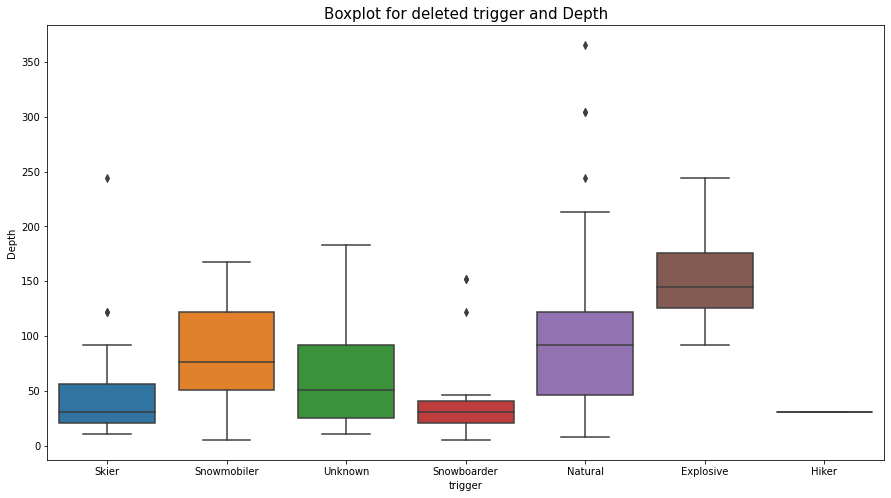

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# set the fig size
plt.figure(figsize=(15,8))
sns.boxplot(x = "trigger", y = "Depth", data = trigger_depth)
plt.title("Boxplot for deleted trigger and Depth", fontsize = 15)

##### EDA Simple test: ANOVA


ANOVA stands for "Analysis of Variance" and is an omnibus test, meaning it tests for a difference overall between all groups. The one-way ANOVA, also referred to as one factor ANOVA, is a parametric test used to test for a statistically significant difference of an outcome between 3 or more groups.

In [ ]:
from scipy.stats import f_oneway

Explosive_Depth = list(trigger_depth.groupby("trigger").get_group('Explosive')['Depth'])
Hiker_Depth = list(trigger_depth.groupby("trigger").get_group('Hiker')['Depth'])
Natural_Depth = list(trigger_depth.groupby("trigger").get_group('Natural')['Depth'])
Skier_Depth = list(trigger_depth.groupby("trigger").get_group('Skier')['Depth'])
Snowboarder_Depth = list(trigger_depth.groupby("trigger").get_group('Snowboarder')['Depth'])
Snowmobiler_Depth = list(trigger_depth.groupby("trigger").get_group('Snowmobiler')['Depth'])
Unknown_Depth = list(trigger_depth.groupby("trigger").get_group('Unknown')['Depth'])
# TEST
f_oneway(Explosive_Depth, Hiker_Depth, Natural_Depth, Skier_Depth, Snowboarder_Depth,Snowmobiler_Depth, Unknown_Depth )

F_onewayResult(statistic=14.113806056696736, pvalue=2.5383225980918772e-14)

From the test result, we see that **statistic**=13.793948285478038, and **pvalue**=1.5.496980512553373e-14. Usually, we chose the $\alpha=0.5$ as significant factor. Therefore, we could reject the null hypothesis in ANOVA that is there is no difference in means. In other words, there is obvious difference in depth means for different trigger groups.


#### Imputing the missing data

In [ ]:
avalance_data_all.head()

,Date,Title,Region,Trigger,Depth,Width
0,2022-02-28,Avalanche: Cardiff Fork,Salt Lake,Natural,NaN,NaN
1,2022-02-28,Avalanche: Porter Fork,Salt Lake,NaN,"14""",60'
2,2022-02-27,Avalanche: Home Run,Salt Lake,Natural,NaN,NaN
3,2022-02-27,Avalanche: Gold Basin,Moab,Skier,2',25'
4,2022-02-26,Avalanche: Ben Lomond,Ogden,Natural,NaN,NaN


In [ ]:
avalance_data_all['Trigger'].isna().values

array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [ ]:
# impute the Trigger 
from sklearn_pandas import CategoricalImputer
imputer = CategoricalImputer()
avalance_data_all['Trigger'] = imputer.fit_transform(avalance_data_all['Trigger'])
avalance_data_all['Trigger'].describe()

count         500
unique          7
top       Natural
freq          247
Name: Trigger, dtype: object

In [ ]:
for i in range(0,10):
  print(type(avalance_data_all['Depth'][i]))

<class 'float'>
<class 'str'>
<class 'float'>
<class 'str'>
<class 'float'>
<class 'float'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [ ]:
from scipy.stats.stats import PearsonRNearConstantInputWarning
import math
#strip the symbol and convert them to cm
inch = "\""
foot = "\'"  
for i in range(len(avalance_data_all['Depth'])):
  if(type(avalance_data_all['Depth'][i])!=float):
    if inch in avalance_data_all['Depth'][i]:
    # convert to integer
      avalance_data_all['Depth'][i] = float(avalance_data_all['Depth'][i].strip("\""))
      avalance_data_all['Depth'][i]=avalance_data_all['Depth'][i]*2.54
      print(avalance_data_all['Depth'][i])
    elif foot in avalance_data_all['Depth'][i]:
       # convert to number
      avalance_data_all['Depth'][i] = float(avalance_data_all['Depth'][i].strip("\'"))
      avalance_data_all['Depth'][i]=avalance_data_all['Depth'][i]*30.48
      print(avalance_data_all['Depth'][i])
  elif(type(avalance_data_all['Depth'][i])==float):
    pass

In [ ]:
avalance_data_all['Depth']

0        NaN
1      35.56
2        NaN
3      60.96
4        NaN
       ...  
495    60.96
496    91.44
497    40.64
498      NaN
499      NaN
Name: Depth, Length: 500, dtype: object

In [ ]:
# check the na values in Depth
avalance_data_all['Depth'].isna().values

array([ True, False,  True, False,  True,  True, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
       False, False, False, False,  True,  True,  True, False, False,
       False, False, False,  True, False,  True,  True, False, False,
        True, False, False, False,  True, False, False, False, False,
        True,  True, False, False, False,  True, False,  True,  True,
       False, False,  True, False,  True,  True,  True, False, False,
       False,  True, False,  True, False, False,  True, False, False,
       False, False, False,  True, False, False, False,  True, False,
        True, False, False, False,  True, False, False,  True, False,
       False, False,

In [ ]:
# impute the NA values
from sklearn.impute import SimpleImputer
# create the mean imputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# fit
avalance_data_all['Depth'] = imputer.fit_transform(avalance_data_all['Depth'].values.reshape(-1,1))

In [ ]:
#check filled dataset
avalance_data_all['Depth'].isna().values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

Now, we have filled all NA values for variables "Depth" and "Trigger." Then I will do the EDA steps.

##### EDA Check the package

In [ ]:
avalance_data_all.shape

(500, 6)

So we have 500 observations and 6 variables

##### EDA Look at the top and bottom of data

In [ ]:
avalance_data_all.head()

,Date,Title,Region,Trigger,Depth,Width
0,2022-02-28,Avalanche: Cardiff Fork,Salt Lake,Natural,68.980326,NaN
1,2022-02-28,Avalanche: Porter Fork,Salt Lake,Natural,35.560000,60'
2,2022-02-27,Avalanche: Home Run,Salt Lake,Natural,68.980326,NaN
3,2022-02-27,Avalanche: Gold Basin,Moab,Skier,60.960000,25'
4,2022-02-26,Avalanche: Ben Lomond,Ogden,Natural,68.980326,NaN


In [ ]:
avalance_data_all.tail()

,Date,Title,Region,Trigger,Depth,Width
495,2021-02-17,Avalanche: Cardiac Ridge,Salt Lake,Natural,60.960000,125'
496,2021-02-17,Avalanche: Pointy Peak,Salt Lake,Unknown,91.440000,400'
497,2021-02-17,Avalanche: Butler Basin,Salt Lake,Natural,40.640000,50'
498,2021-02-17,Avalanche: Hellgate,Salt Lake,Explosive,68.980326,NaN
499,2021-02-17,Avalanche: White Pine,Salt Lake,Explosive,68.980326,NaN


##### EDA Check the "n"s

In [ ]:
# check the value counts for each column
for column in avalance_data_all.columns:
  print(str(column) + " " + str(avalance_data_all[column].value_counts()))
  print()

Date 2021-02-17    43
2021-02-21    26
2021-03-14    23
2021-12-31    22
2021-12-18    22
              ..
2021-03-23     1
2021-12-22     1
2021-12-23     1
2021-12-28     1
2021-05-24     1
Name: Date, Length: 109, dtype: int64

Title Avalanche: Moab              21
Avalanche: Timpanogos        12
Avalanche: White Pine         9
Avalanche: Superior           7
Avalanche: West Monitor       6
                             ..
Avalanche: Gods Lawnmower     1
Avalanche: Snowbasin          1
Avalanche: Lowry Fork         1
Avalanche: Days Fork          1
Avalanche: Hellgate           1
Name: Title, Length: 280, dtype: int64

Region Salt Lake    278
Skyline       53
Logan         43
Uintas        41
Provo         39
Moab          26
Ogden         11
Southwest      8
SE Idaho       1
Name: Region, dtype: int64

Trigger Natural        247
Skier          120
Unknown         64
Snowmobiler     27
Snowboarder     24
Explosive       17
Hiker            1
Name: Trigger, dtype: int64

Depth 68.9803

##### EDA Validate against an external data source

External resource: https://avalanche.org/avalanche-encyclopedia/trigger/

According to the website, most avalanches are “naturally” triggered, meaning that weather (wind, snow, rain or sun) stresses the snowpack to its breaking point. I will check if the most frequent trigger in the dataset is "natural"

In [ ]:
avalance_data_all['Trigger'].value_counts()

Natural        247
Skier          120
Unknown         64
Snowmobiler     27
Snowboarder     24
Explosive       17
Hiker            1
Name: Trigger, dtype: int64

From the results, we can see that the counts for Natural up to 245, which is the most common trigger is this data. So I validate that the trigger is resonable for this inputed data.

##### EDA Boxplot for imputed data

Text(0.5, 1.0, 'Boxplot for imputed trigger and Depth')

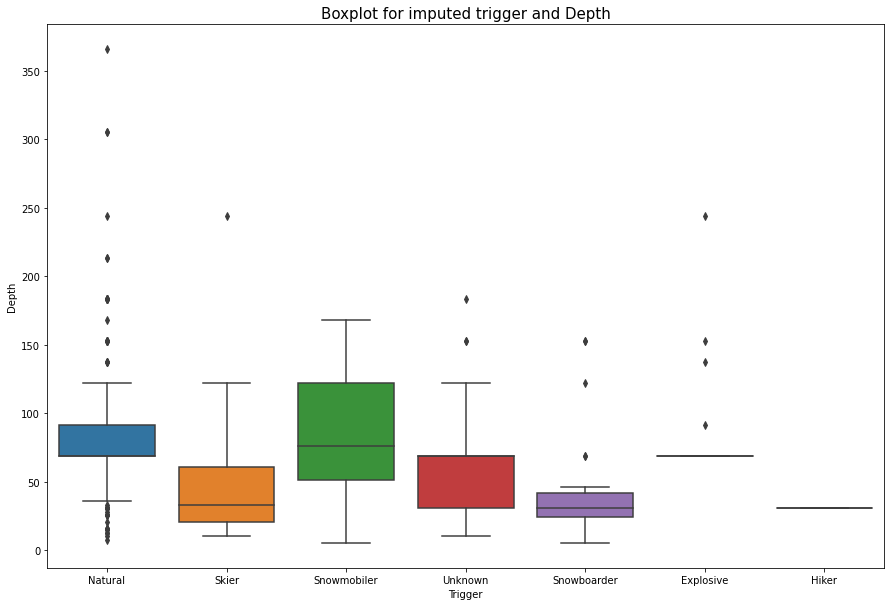

In [ ]:
import seaborn as sns
# set the fig size
plt.figure(figsize=(15,10))
sns.boxplot(x = "Trigger", y = "Depth", data = avalance_data_all)
plt.title("Boxplot for imputed trigger and Depth", fontsize = 15)

##### EDA Simple test: ANOVA

In [ ]:
from scipy.stats import f_oneway

Explosive_Depth = list(avalance_data_all.groupby("Trigger").get_group('Explosive')['Depth'])
Hiker_Depth = list(avalance_data_all.groupby("Trigger").get_group('Hiker')['Depth'])
Natural_Depth = list(avalance_data_all.groupby("Trigger").get_group('Natural')['Depth'])
Skier_Depth = list(avalance_data_all.groupby("Trigger").get_group('Skier')['Depth'])
Snowboarder_Depth = list(avalance_data_all.groupby("Trigger").get_group('Snowboarder')['Depth'])
Snowmobiler_Depth = list(avalance_data_all.groupby("Trigger").get_group('Snowmobiler')['Depth'])
Unknown_Depth = list(avalance_data_all.groupby("Trigger").get_group('Unknown')['Depth'])\
# TEST
f_oneway(Explosive_Depth, Hiker_Depth, Natural_Depth, Skier_Depth, Snowboarder_Depth, Snowmobiler_Depth, Unknown_Depth )

F_onewayResult(statistic=14.480365468779542, pvalue=3.0371807100589315e-15)

From the test result, we see that statistic=14.010814784137937, and pvalue=9.552405101099953e-15. Usually, we chose the  𝛼=0.5  as significant factor. Therefore, we could reject the null hypothesis in ANOVA that is there is no difference in means.

## Write up

---
Write up:

I explored the [avalanche](https://utahavalanchecenter.org/avalanches)(click to check the website) data and used web scraping to get my data. To extract the valuable information from the HTML file, I imported the necessary libraries: requests, BeautifulSoup, pandas. First, I created the list combining up to 10 websites URL and then used requests.get(website) to acquire the raw scraping data. After that, I applied BeautifulSoup and html.parser to parse the raw data.

The problem I met in web scraping is how to extract specific rows from the raw HTML data. First, I thought I could use the find_all<tr> as each row starts with <tr> in HTML version. However, some contents start with <tr> outside the data frame I want to scarp. Therefore, I chose to go to the parent class.

After inspecting the HTML code carefully, I discovered that there is unique parent content called `<div class= "view-content">` which straightly maps to the table I want to scrape. First, I called soup.find_all(content) to get the overall table. Then, the inspector reveals that all of the following tags are unique in the table: 

 1. `<th>`: variables names
 2. `<td class="views-field views-field-field-occurrence-date">`: Date
 3. `<td class= "views-field views-field-title">`: Title
 4.`<td class= "views-field views-field-field-region-forecaster nowrap">`: Region
 5. `<td class="views-field views-field-field-trigger">`: Trigger
 6. `<td class="views-field views-field-field-depth views-align-right">`: Depth
 7. `<td class="views-field views-field-field-width views-align-right">`: Width

I utilized a for loop to derive the data frame to get all variables, availing the find_all function again on table content. 

After getting the raw data frame, I came up with the question: Will the variable "trigger" result in an avalanche of different severity? In other words, I was wondering if there is a difference in avalanche depth overall between all groups of triggers. This is intriguing as we could roughly predict the degree of severity and forecast the scale of damage based on a trigger. Also, we can minimize the damages due to the occurrences of avalanches based on the trigger. For example, if the trigger skier is comparatively common, the travel place could close the skiing place in the most dangerous time to prevent the happenings of avalanches. 

To answer my question, I planned to employ the boxplot and AVOVA test. However, before doing these things, I encountered an intricate problem: the variable "Depth" has been read in string format with foot and inch annotations. To get the comparable data for "Depth," my strategy is removing the foot and annotation marks first, then covert the string to float or integer, ultimately, use the float or integer number to multiply the corresponding standard to the centimeter. After that, I got the uniform standard centimeter for the variable "Depth." 

Till now, I have the fairly cleaned data except for the missing values. The web-scraping I did is relatively complicated as all information has been read in string format. For some specially-formatted data like data with an inch or foot unit, I have to strip all extra annotation, like comma, single quotation mark, and double quotation mark, then do the conversion to numbers, ultimately transforming the number to the standard unit for convenience of comparison. Also, the duplicated HTML notations are also tricky to deal with. To acquire the specific information residing in the table, I have to narrow the scraping domain and try manually and enlarge the domain again if it is inappropriate, which is inefficient.(**web-scraping limitation**)

Now, we have to deal with the missing values. 

The first approach I chose is deleting all observations with missing values utilizing the dropna() function. In this case, I got 346 observations and 2 variables("trigger", "Depth"). 

Then I used seaborn to do the boxplot. The reason I use boxplot is that I have both categorical data and numerical data, and the question I want to answer is the differences of Depth (numerical data) between the groups of "Trigger"(categorical data). Therefore, the boxplot assists me in revealing the distinctions overall distribution for each group, as well as the mean values, scales, max, min values, etc. In the plot, X-axis denotes trigger groups of 7 categories, and the y-axis denotes "Depth." Also, I found that the mean values of different groups are relatively away from each other, as well as the overall distributions. The explosive group has notably the higher-valued distribution of "Depth" than others. The natural group has the largest scale taking into consideration of "outliers." 

The second approach I chose to deal with missing values is imputing method. In this case, I used the mean value method to fill all NA values for "Depth"(continuous) and the most-frequent-value method for "Trigger"(categorical). 

Also, I plotted the boxplot for the imputed dataset. This time, the mean values also vary from each other, and the natural also has the biggest scale. However, the snowmobiler demonstrates its significance. My assumption of such distinction is that: when I am doing the deletion, the observations with the snowmobiler trigger have been deleted directly due to the Depth value missing. Thus, we have a comparatively insignificant trait for snowmobilers in the previous "Boxplot for deleted trigger and Depth."
Finally, I did the AVOVA simple tests for both datasets(deleted and imputed).

ANOVA stands for "Analysis of Variance" and is an omnibus test, meaning it tests for a difference overall between all groups. The one-way ANOVA, also referred to as one factor ANOVA is a parametric test used to test for a statistically significant difference of an outcome between 3 or more groups. 

In this assignment, I use it to test the statistically significant difference of "Depth" among various groups of "Trigger." Employing f_oneway in scipy.stats, I got statistic=14.1035899477999, pvalue=2.4123192282273505e-14 for the deleted dataset, and statistic=14.010814784137937, pvalue=9.552405101099953e-15 for the imputed dataset. 

Usually, we chose the alpha factor as 0.05. therefore, we could reject the null hypothesis in ANOVA is that there is no difference in means in both cases. In other words, there is an obvious difference in Depth means for different trigger groups in both datasets treated in different cleaning ways. 

Finally, to answer my question: "if there is a difference in avalanche depth overall between all groups of triggers," Yes, there is difference concering depth for each group of triggers.

## The HTML file

<html lang="en" class="js"><head>
<title>Avalanches - Utah Avalanche Center</title>
<meta name="viewport" content="width=device-width, initial-scale=1.0">             
<meta http-equiv="Content-Type" content="text/html; charset=utf-8">
<link rel="shortcut icon" href="https://utahavalanchecenter.org/sites/default/files/images/uac-site/uac-favicon.png" type="image/png">
<link type="text/css" rel="stylesheet" href="https://utahavalanchecenter.org/sites/default/files/css/css_xE-rWrJf-fncB6ztZfd2huxqgxu4WO-qwma6Xer30m4.css" media="all">
<link type="text/css" rel="stylesheet" href="https://utahavalanchecenter.org/sites/default/files/css/css_o5m5YfhNvCAmTYElqKpCQG6h1HjE4crK0Lriiytig8I.css" media="all">
<link type="text/css" rel="stylesheet" href="https://utahavalanchecenter.org/sites/default/files/css/css_tcqXHDMHRqtAPwNCTJBf-bQZ7knqzs48NDfFsr31Pkg.css" media="all">
<link type="text/css" rel="stylesheet" href="https://utahavalanchecenter.org/sites/default/files/css/css_j_ng14rDsucP7t_nwmN6YQxzyuuXDjxPRwFsC1vg8q0.css" media="all">
<link type="text/css" rel="stylesheet" href="https://utahavalanchecenter.org/sites/default/files/css/css_kkbUDYNW1y5GNXAF9-P7R8g2-uaWYuMMAE-amvBaiU4.css" media="all">
<script async="" src="//www.google-analytics.com/analytics.js"></script><script type="text/javascript" src="https://utahavalanchecenter.org/sites/all/modules/jquery_update/replace/jquery/1.8/jquery.min.js?v=1.8.3"></script>
<script type="text/javascript" src="https://utahavalanchecenter.org/misc/jquery-extend-3.4.0.js?v=1.8.3"></script>
<script type="text/javascript" src="https://utahavalanchecenter.org/misc/jquery-html-prefilter-3.5.0-backport.js?v=1.8.3"></script>
<script type="text/javascript" src="https://utahavalanchecenter.org/misc/jquery.once.js?v=1.2"></script>
<script type="text/javascript" src="https://utahavalanchecenter.org/misc/drupal.js?r7az5v"></script>
<script type="text/javascript" src="https://utahavalanchecenter.org/sites/all/modules/jquery_update/replace/ui/ui/minified/jquery.ui.core.min.js?v=1.10.2"></script>
<script type="text/javascript" src="https://utahavalanchecenter.org/sites/all/modules/jquery_update/replace/ui/ui/minified/jquery.ui.datepicker.min.js?v=1.10.2"></script>
<script type="text/javascript" src="https://utahavalanchecenter.org/sites/all/modules/date/date_popup/jquery.timeentry.pack.js?v=1.4.7"></script>
<script type="text/javascript" src="https://utahavalanchecenter.org/sites/all/modules/shopify/shopify.js?r7az5v"></script>
<script type="text/javascript" src="https://utahavalanchecenter.org/sites/all/modules/behavior_weights/behavior_weights.js?r7az5v"></script>
<script type="text/javascript" src="https://utahavalanchecenter.org/sites/all/modules/better_exposed_filters/better_exposed_filters.js?r7az5v"></script>
<script type="text/javascript" src="https://utahavalanchecenter.org/sites/all/modules/date/date_popup/date_popup.js?r7az5v"></script>
<script type="text/javascript" src="https://utahavalanchecenter.org/sites/all/modules/google_analytics/googleanalytics.js?r7az5v"></script>
<script type="text/javascript">
<!--//--><![CDATA[//><!--
(function(i,s,o,g,r,a,m){i["GoogleAnalyticsObject"]=r;i[r]=i[r]||function(){(i[r].q=i[r].q||[]).push(arguments)},i[r].l=1*new Date();a=s.createElement(o),m=s.getElementsByTagName(o)[0];a.async=1;a.src=g;m.parentNode.insertBefore(a,m)})(window,document,"script","//www.google-analytics.com/analytics.js","ga");ga("create", "UA-6029833-3", {"cookieDomain":"auto"});ga("send", "pageview");
//--><!]]>
</script>
<script type="text/javascript" src="https://utahavalanchecenter.org/sites/all/themes/basscss/js/uac.js?r7az5v"></script>
<script type="text/javascript">
<!--//--><![CDATA[//><!--
jQuery.extend(Drupal.settings, {"basePath":"\/","pathPrefix":"","ajaxPageState":{"theme":"basscss","theme_token":"_sZhYbiSzNbghZ3IIes_5QSfLbTKqZxVB5I9Y0TmYrk","js":{"sites\/all\/modules\/jquery_update\/replace\/jquery\/1.8\/jquery.min.js":1,"misc\/jquery-extend-3.4.0.js":1,"misc\/jquery-html-prefilter-3.5.0-backport.js":1,"misc\/jquery.once.js":1,"misc\/drupal.js":1,"sites\/all\/modules\/jquery_update\/replace\/ui\/ui\/minified\/jquery.ui.core.min.js":1,"sites\/all\/modules\/jquery_update\/replace\/ui\/ui\/minified\/jquery.ui.datepicker.min.js":1,"sites\/all\/modules\/date\/date_popup\/jquery.timeentry.pack.js":1,"sites\/all\/modules\/shopify\/shopify.js":1,"sites\/all\/modules\/behavior_weights\/behavior_weights.js":1,"sites\/all\/modules\/better_exposed_filters\/better_exposed_filters.js":1,"sites\/all\/modules\/date\/date_popup\/date_popup.js":1,"sites\/all\/modules\/google_analytics\/googleanalytics.js":1,"0":1,"sites\/all\/themes\/basscss\/js\/uac.js":1},"css":{"modules\/system\/system.base.css":1,"modules\/system\/system.menus.css":1,"modules\/system\/system.messages.css":1,"modules\/system\/system.theme.css":1,"misc\/ui\/jquery.ui.core.css":1,"misc\/ui\/jquery.ui.theme.css":1,"misc\/ui\/jquery.ui.datepicker.css":1,"sites\/all\/modules\/date\/date_popup\/themes\/jquery.timeentry.css":1,"modules\/comment\/comment.css":1,"sites\/all\/modules\/date\/date_api\/date.css":1,"sites\/all\/modules\/date\/date_popup\/themes\/datepicker.1.7.css":1,"sites\/all\/modules\/date\/date_repeat_field\/date_repeat_field.css":1,"modules\/field\/theme\/field.css":1,"modules\/node\/node.css":1,"modules\/search\/search.css":1,"modules\/user\/user.css":1,"sites\/all\/modules\/views\/css\/views.css":1,"sites\/all\/modules\/ckeditor\/css\/ckeditor.css":1,"sites\/all\/modules\/ctools\/css\/ctools.css":1,"sites\/all\/modules\/civicrm\/css\/crm-i.css":1,"sites\/all\/modules\/civicrm\/css\/civicrm.css":1,"sites\/all\/themes\/basscss\/css\/uac.css":1,"sites\/all\/themes\/basscss\/css\/override.css":1}},"better_exposed_filters":{"datepicker":false,"slider":false,"settings":[],"autosubmit":false,"views":{"avalanches":{"displays":{"page":{"filters":{"fodv":{"required":false}}}}}}},"datePopup":{"edit-fodv-min-datepicker-popup-0":{"func":"datepicker","settings":{"changeMonth":false,"changeYear":false,"autoPopUp":"focus","closeAtTop":false,"speed":"immediate","firstDay":0,"dateFormat":"mm\/dd\/yy","yearRange":"-50:+0","fromTo":false,"defaultDate":"0y"}},"edit-fodv-max-datepicker-popup-0":{"func":"datepicker","settings":{"changeMonth":false,"changeYear":false,"autoPopUp":"focus","closeAtTop":false,"speed":"immediate","firstDay":0,"dateFormat":"mm\/dd\/yy","yearRange":"-50:+0","fromTo":false,"defaultDate":"0y"}}},"urlIsAjaxTrusted":{"\/avalanches":true},"googleanalytics":{"trackOutbound":1,"trackMailto":1,"trackDownload":1,"trackDownloadExtensions":"7z|aac|arc|arj|asf|asx|avi|bin|csv|doc(x|m)?|dot(x|m)?|exe|flv|gif|gz|gzip|hqx|jar|jpe?g|js|mp(2|3|4|e?g)|mov(ie)?|msi|msp|pdf|phps|png|ppt(x|m)?|pot(x|m)?|pps(x|m)?|ppam|sld(x|m)?|thmx|qtm?|ra(m|r)?|sea|sit|tar|tgz|torrent|txt|wav|wma|wmv|wpd|xls(x|m|b)?|xlt(x|m)|xlam|xml|z|zip"}});
//--><!]]>
</script>
<style type="text/css" id="diigolet-chrome-css">body#dummybodyid .diigolet,body#dummybodyid .diigolet a,body#dummybodyid .diigolet em,body#dummybodyid .diigolet span,body#dummybodyid .diigolet div,body#dummybodyid .diigolet dl,body#dummybodyid .diigolet dt,body#dummybodyid .diigolet dd,body#dummybodyid .diigolet ul,body#dummybodyid .diigolet ol,body#dummybodyid .diigolet li,body#dummybodyid .diigolet h1,body#dummybodyid .diigolet h2,body#dummybodyid .diigolet h3,body#dummybodyid .diigolet h4,body#dummybodyid .diigolet h5,body#dummybodyid .diigolet h6,body#dummybodyid .diigolet pre,body#dummybodyid .diigolet form,body#dummybodyid .diigolet fieldset,body#dummybodyid .diigolet p,body#dummybodyid .diigolet blockquote,body#dummybodyid .diigolet th,body#dummybodyid .diigolet td,body#dummybodyid .diigolet input,body#dummybodyid .diigolet textarea,body#dummybodyid .diigolet select,body#dummybodyid .diigolet *{background:transparent none;padding:0;margin:0;flex-direction:row;border:#000 0 solid;text-align:left;text-decoration:none;text-transform:none;text-indent:0;line-height:normal;word-break:normal;word-wrap:normal;width:auto;height:auto;color:inherit;font:inherit;float:none;cursor:default;position:static;overflow:visible;max-width:none;box-shadow:none;opacity:1;border-radius:0;}
body#dummybodyid .diigolet{color:#000;font:normal normal normal 13px arial,helvetica,clean,sans-serif;}
body#dummybodyid .diigolet input[type="text"],body#dummybodyid .diigolet textarea,body#dummybodyid .diigolet select,body#dummybodyid .diigolet fieldset{background-color:#fff;border:1px #999 solid;padding:1px;font-size:12px;display:inline;border-radius:2px;-webkit-transition:border linear .2s,box-shadow linear .2s;}
body#dummybodyid .diigolet select{padding:0;height:20px;}
body#dummybodyid .diigolet input[type="text"],body#dummybodyid .diigolet textarea{cursor:text;}
body#dummybodyid .diigolet input[type="text"]{height:20px;}
body#dummybodyid .diigolet input[type="button"],body#dummybodyid .diigolet input[type="submit"],body#dummybodyid .diigolet input[type="reset"],body#dummybodyid .diigolet input[type="file"]{color:buttontext;cursor:default;padding:2px 5px;text-align:center;border:1px solid #ccc;background:#fff;border-radius:2px;background-image:-webkit-gradient(linear,0% 0,0% 100%,from(#f8f8f8),to(#d2d2d2));}
body#dummybodyid .diigolet input[type="button"]:active,body#dummybodyid .diigolet input[type="submit"]:active,body#dummybodyid .diigolet input[type="reset"]:active,body#dummybodyid .diigolet input[type="file"]:active{background:#ddd;}
body#dummybodyid .diigolet textarea{white-space:normal!important;resize:vertical!important;padding:2px!important;}
body#dummybodyid .diigolet input.diigo-check{border:none;vertical-align:middle;}
body#dummybodyid .diigolet input.diigo-button{font-size:12px!important;font-weight:bold;padding:4px 8px;cursor:pointer;border-radius:4px;}
body#dummybodyid .diigolet input.diigo-button#diigolet-dlgBm-btnSave{width:56px;color:white;height:25px;-webkit-border-radius:4px;background-color:rgba(237,237,237,0);-webkit-box-shadow:0 1px 1px rgba(0,0,0,0.15);border:solid 1px #0388dc;background-image:-webkit-linear-gradient(top,#4eaffa,#0492f5);}
body#dummybodyid .diigolet input.diigo-button#diigolet-dlgBm-btnSave:hover{background-image:-webkit-linear-gradient(top,#349ef0,#0580d6);}
body#dummybodyid .diigolet input.diigo-button#diigolet-dlgBm-btnSave:active{background-image:-webkit-linear-gradient(bottom,#4eaffa,#0492f5);}
body#dummybodyid .diigolet input.diigo-downlist{background:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/arrow-down.png) 50% 50% no-repeat,-webkit-gradient(linear,0% 0,0% 100%,from(#f8f8f8),to(#d2d2d2));width:12px;margin-left:-16px;}
body#dummybodyid .diigolet input.diigo-downlist:active{background:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/arrow-down.png) 50% 50% no-repeat,#ddd;}
body#dummybodyid .diigolet div.diigo-buttonswitchlist{padding:4px 2px;border:1px solid #ccc;position:absolute;right:72px;background:#fff;z-index:100000;}
body#dummybodyid .diigolet div.diigo-buttonswitchlist ul li{padding:2px 6px;}
body#dummybodyid .diigolet div.diigo-buttonswitchlist ul li:hover{background:#43658f;color:#fff;cursor:pointer;}
body#dummybodyid #diigoletFNSubmit{width:50px;}
body#dummybodyid .diigolet table{border-collapse:collapse;border-spacing:0;width:auto;}
body#dummybodyid .diigolet label{cursor:pointer!important;display:inline;vertical-align:middle;}
body#dummybodyid .diigolet fieldset,body#dummybodyid .diigolet img{border:0;}
body#dummybodyid .diigolet address,body#dummybodyid .diigolet caption,body#dummybodyid .diigolet cite,body#dummybodyid .diigolet code,body#dummybodyid .diigolet dfn,body#dummybodyid .diigolet em,body#dummybodyid .diigolet strong,body#dummybodyid .diigolet th,body#dummybodyid .diigolet var{font-style:normal;font-weight:bold;}
body#dummybodyid .diigolet ol,body#dummybodyid .diigolet ul,body#dummybodyid .diigolet li{list-style:none;display:block;}
body#dummybodyid .diigolet caption,body#dummybodyid .diigolet th{text-align:left;}
body#dummybodyid .diigolet h1,body#dummybodyid .diigolet h2,body#dummybodyid .diigolet h3,body#dummybodyid .diigolet h4,body#dummybodyid .diigolet h5,body#dummybodyid .diigolet h6{font-weight:bold;}
body#dummybodyid .diigolet q:before,body#dummybodyid .diigolet q:after{content:"";}
body#dummybodyid .diigolet abbr,body#dummybodyid .diigolet acronym{border:0;}
body#dummybodyid .diigolet a:link,body#dummybodyid .diigolet a:visited,body#dummybodyid .diigolet a:hover,body#dummybodyid .diigolet a:active{text-decoration:none;color:#00f;cursor:pointer!important;}
body#dummybodyid .diigolet a:hover{text-decoration:underline;}
body#dummybodyid .diigolet a *{cursor:inherit;}
body#dummybodyid #diigolet-tray{position:fixed;top:0;left:10;width:16px;height:16px;background:transparent url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigoletIconv3.gif") no-repeat left -4px;z-index:2147483646;}
body#dummybodyid .diigolet a.diigolet-Help:link,body#dummybodyid .diigolet a.diigolet-Help:visited{color:#06f;}
body#dummybodyid .diigolet a.diigolet-Help:hover,body#dummybodyid .diigo a.diigolet-Help:active{color:#00f;}
body#dummybodyid .diigolet label{margin-left:3px;}
body#dummybodyid .diigolet span.noComments{color:#aaa;font-size:10px;}
body#dummybodyid #diigolet-toolbar{border:none;width:100%;position:absolute;top:0;left:0;z-index:2147483647;color:#333;}
body#dummybodyid #diigolet-tb-content{padding:3px 5px;background:#efedde url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigolet-toolbar-bg2.gif) repeat scroll 0;}
body#dummybodyid #diigolet-tb-bar span,body#dummybodyid #diigolet-tb-bar div,body#dummybodyid #diigolet-tb-bar a,body#dummybodyid #diigolet-tb-bar em{line-height:24px;}
body#dummybodyid #diigolet-tb-shadow{height:5px;background:transparent url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigolet-toolbar-shadow.png) repeat-x left top;}
* html body#dummybodyid #diigolet-tb-shadow.ie6{filter:progid:DXImageTransform.Microsoft.AlphaImageLoader(enabled=true,sizingMethod=scale,src="chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigolet-toolbar-shadow.png");overflow:hidden;background:none;}
body#dummybodyid #diigolet-help{display:none;position:absolute;top:29px;right:10px;width:200px;border:1px #ccc solid;background-color:#ffc;padding:6px 16px 6px 6px;}
body#dummybodyid .diigolet a.diigoletButton{height:24px;float:left;padding-right:4px;cursor:pointer!important;}
body#dummybodyid .diigolet a.diigoletButton:hover{text-decoration:none;color:#000;background:transparent url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigoletBtn3_r.png") no-repeat right top;}
body#dummybodyid .diigolet a.diigoletButton:active{background-position:right bottom;}
body#dummybodyid .diigolet a.diigoletButton b{font-weight:normal;color:#000;line-height:24px;float:left;padding-left:4px;height:24px;}
body#dummybodyid #diigolet-button-highlight-dropdown{width:8px;height:16px;margin-right:4px;background:transparent url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/down_arrow.gif") no-repeat scroll left 2px;}
body#dummybodyid #diigolet-button-highlight-dropdown.mouseovered{border-left:1px solid #888;margin-right:0;text-decoration:none;width:11px;height:24px;background:transparent url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigoletBtn4.png") no-repeat left top!important;}
body#dummybodyid #diigolet-button-highlight-dropdown.mouseoveredIe{border-left:1px solid #888;margin-right:1px;text-decoration:none;width:11px;height:24px;background:transparent url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigoletBtn4.png") no-repeat left top!important;}
body#dummybodyid #diigolet-button-highlight-dropdown.checked{border-left:1px solid #888;margin-right:0;text-decoration:none;width:11px;height:24px;background:transparent url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigoletBtn4_s.png") no-repeat left top!important;}
body#dummybodyid #diigolet-button-highlight.mouseovered{text-decoration:none;color:#000;background:transparent url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigoletBtn3_r.png") no-repeat right top!important;}
body#dummybodyid #diigolet-button-highlight.mouseoveredIe{text-decoration:none;color:#000;background:transparent url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigoletBtn3_r.png") no-repeat right top!important;}
body#dummybodyid #diigolet-button-highlight.mouseovered b.outer{background:transparent url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigoletBtn3.png") no-repeat left top;}
body#dummybodyid #diigolet-button-highlight.mouseoveredIe b.outer{background:transparent url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigoletBtn3.png") no-repeat left top;}
body#dummybodyid a#diigolet-button-highlight b.outer{padding-right:5px;}
body#dummybodyid a#diigolet-button-highlight{padding-right:0!important;}
body#dummybodyid a.diigoletButton:hover b.outer{background:transparent url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigoletBtn3.png") no-repeat left top;}
body#dummybodyid a.diigoletButton:active b.outer{background-position:left bottom;}
body#dummybodyid .diigolet a.diigoletButton b b{font-size:12px;padding-left:20px;background:transparent url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigoletIconv3.gif") no-repeat left 50%;}
body#dummybodyid .diigolet a.diigoletButton:active b b{position:relative;top:1px;left:1px;}
body#dummybodyid .diigolet a.diigoletButton.diigoletDisabled{cursor:default;}
body#dummybodyid .diigolet a.diigoletButton.diigoletDisabled b b{color:#999;position:static;}
body#dummybodyid .diigolet a.diigoletButton.diigoletDisabled:hover{background:none transparent;}
body#dummybodyid .diigolet a.diigoletButton.diigoletDisabled:hover b.outer{background:none transparent;}
body#dummybodyid .diigolet a.diigoletButton.checked{background:transparent url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigoletBtn3_r.png") no-repeat right top;background-position:right bottom;}
body#dummybodyid .diigolet a.diigoletButton.checked b.outer{background:transparent url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigoletBtn3.png") no-repeat left top;background-position:left bottom;}
body#dummybodyid .diigolet a.diigoletButton.checked b b{position:relative;top:1px;left:1px;}
body#dummybodyid #diigolet-tb-btnSidebar b b{background-position:left -24px;}
body#dummybodyid #diigolet-tb-btnSidebar.toClose b b{background-position:left -48px;}
body#dummybodyid #diigolet-tb-btnBookmark b b{background-position:left -144px;}
body#dummybodyid #diigolet-tb-btnBookmark.saved b b{background-position:left -120px;}
body#dummybodyid #diigolet-button-highlight b b{background-position:left -72px;}
body#dummybodyid #diigolet-button-highlight.dontShow b b{background-position:left -96px;}
body#dummybodyid #diigolet-button-highlight.yellow b b{background-position:left -355px;}
body#dummybodyid #diigolet-button-highlight.blue b b{background-position:left -375px;}
body#dummybodyid #diigolet-button-highlight.green b b{background-position:left -395px;}
body#dummybodyid #diigolet-button-highlight.pink b b{background-position:left -415px;}
body#dummybodyid .diigolet .colorItem{padding-left:20px;height:16px;background:transparent url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigoletIconv3.gif") no-repeat left -440px;}
body#dummybodyid #diigolet-context-yellow b,body#dummybodyid #diigolet-colorMenu-yellow b{background-position:left -440px;}
body#dummybodyid #diigolet-context-blue b,body#dummybodyid #diigolet-colorMenu-blue b{background-position:left -460px;}
body#dummybodyid #diigolet-context-green b,body#dummybodyid #diigolet-colorMenu-green b{background-position:left -480px;}
body#dummybodyid #diigolet-context-pink b,body#dummybodyid #diigolet-colorMenu-pink b{background-position:left -500px;}
body#dummybodyid #diigolet-context-yellow.colorchecked b,body#dummybodyid #diigolet-colorMenu-yellow.colorchecked b{background-position:left -520px;}
body#dummybodyid #diigolet-context-blue.colorchecked b,body#dummybodyid #diigolet-colorMenu-blue.colorchecked b{background-position:left -540px;}
body#dummybodyid #diigolet-context-green.colorchecked b,body#dummybodyid #diigolet-colorMenu-green.colorchecked b{background-position:left -560px;}
body#dummybodyid #diigolet-context-pink.colorchecked b,body#dummybodyid #diigolet-colorMenu-pink.colorchecked b{background-position:left -580px;}
body#dummybodyid #diigolet-tb-btnFloatNote b b{background-position:left -167px;}
body#dummybodyid #diigolet-tb-btnTwitter b b{background:transparent url("https://twitter.com/favicon.ico") no-repeat left 50%;}
body#dummybodyid #diigolet-tb-btnComment b b{background-position:left -192px;}
body#dummybodyid #diigolet-tb-btnComment.commented b b{background-position:left -192px;}
body#dummybodyid #diigolet-tb-btnMore b b{background-position:left 0;}
body#dummybodyid #diigolet-tb-btnSignIn b b{background-position:left -264px;}
body#dummybodyid #diigolet-tb-btnHide{float:right;height:24px;width:16px;background:transparent url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigoletIconv3.gif") no-repeat left -240px;}
body#dummybodyid div.diigoIcon{cursor:pointer!important;margin:0;padding:0;position:absolute;display:none;width:24px!important;z-index:2147483643;height:23px!important;background:transparent url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/ietoolbar-images/edit-highlight.png") no-repeat left;-webkit-transition:-webkit-transform 150ms ease;vertical-align:text-bottom;}
body#dummybodyid span.diigoHighlightCommentLocator{vertical-align:text-bottom;line-height:0;}
body#dummybodyid div.diigoIcon span{color:#000;display:block;font-family:Helvetica,Arial,sans-serif;font-size:13px;font-weight:700;line-height:18px;text-align:center;text-shadow:0 1px 1px #fff;text-decoration:none;text-indent:0;display:none;}
body#dummybodyid div.diigoHighlightcommented{display:inline-block!important;}
body#dummybodyid div.ImageIcon{background-color:transparent!important;}
body#dummybodyid div.diigoIcon:hover{background-color:transparent!important;background-repeat:no-repeat!important;-webkit-transform:translate(0px,-2px);}
body#dummybodyid div.diigoHighlightcommented.TextIcon{bottom:0;}
body#dummybodyid div.diigoHighlightcommented.public{background:#fff url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/ietoolbar-images/public-annotation.png") no-repeat left;}
body#dummybodyid div.diigoHighlightcommented.private.yellow{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/ietoolbar-images/annotation-icon.png") 0 0 no-repeat;}
body#dummybodyid div.diigoHighlightcommented.private.blue{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/ietoolbar-images/annotation-icon.png") 0 -46px no-repeat;}
body#dummybodyid div.diigoHighlightcommented.private.green{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/ietoolbar-images/annotation-icon.png") 0 -92px no-repeat;}
body#dummybodyid div.diigoHighlightcommented.private.pink{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/ietoolbar-images/annotation-icon.png") 0 -138px no-repeat;}
body#dummybodyid div.diigoHighlightcommented.group.yellow{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/ietoolbar-images/annotation-icon.png") 0 -23px no-repeat;}
body#dummybodyid div.diigoHighlightcommented.group.blue{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/ietoolbar-images/annotation-icon.png") 0 -69px no-repeat;}
body#dummybodyid div.diigoHighlightcommented.group.green{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/ietoolbar-images/annotation-icon.png") 0 -115px no-repeat;}
body#dummybodyid div.diigoHighlightcommented.group.pink{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/ietoolbar-images/annotation-icon.png") 0 -161px no-repeat;}
body#dummybodyid #diigolet-toolbar .dropdownMenu{display:none;border:1px solid #999;font:12px arial,helvetica,clean,sans-serif;background-color:Menu;padding:2px 0;z-index:2147483647;position:absolute;top:30px;width:140px;}
body#dummybodyid #diigolet-toolbar .dropdownMenu a,body#dummybodyid #diigolet-toolbar .dropdownMenu a:link,body#dummybodyid #diigolet-toolbar .dropdownMenu a:visited,body#dummybodyid #diigolet-toolbar .dropdownMenu a:hover,body#dummybodyid #diigolet-toolbar .dropdownMenu a:active{display:block;padding:2px 12px;font-weight:normal;text-decoration:none;color:#000;background:#fff;cursor:default;}
body#dummybodyid #diigolet-toolbar .dropdownMenu a:hover,body#dummybodyid #diigolet-toolbar .dropdownMenu a:active{color:#fff;background:#09f;}
body#dummybodyid #diigolet-notify{display:none;position:absolute;top:33px;left:0;border:1px #ccc solid;background-color:#ffc;padding:6px 16px 6px 6px;z-index:2147483647;}
body#dummybodyid #diigolet-notify.right{left:auto;right:0;text-align:right;}
body#dummybodyid .diigolet .tagList{margin:2px 0;float:left;}
body#dummybodyid .diigolet .diigo-su-tag .tagButton{display:inline-block;height:16px;padding:0 5px;line-height:16px;background-color:#f2f2f2;border-top:1px solid rgba(0,0,0,0);border-left:1px solid rgba(0,0,0,0);border-right:1px solid #c9d7f1;border-bottom:1px solid #c9d7f1;color:#858585;border-radius:1px;cursor:pointer;margin-right:3px;}
body#dummybodyid .diigolet .diigo-su-tag .tagButton:hover{border-color:#82b3f8;}
body#dummybodyid .diigolet .diigo-su-tag .tagButton.inused{color:#3f99a1;}
body#dummybodyid .diigolet .diigo-su-tag .tagButton.selected{border-color:#82b3f8;}
body#dummybodyid .diigolet .tagLoading a{display:none;margin-bottom:10px;}
body#dummybodyid .diigolet .tagList.tagLoading .loading{background:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/ietoolbar-images/indicator.gif) no-repeat left top;height:16px;padding-left:22px;display:block;}
body#dummybodyid .diigolet .tagLoading .tagListHeader{display:none;}
body#dummybodyid .diigolet .tagListHeader{cursor:pointer;float:left;width:100px;line-height:23px;}
body#dummybodyid .diigolet .tagListHeader:hover{text-decoration:underline;}
body#dummybodyid .diigolet .tagList div{color:#666!important;font-size:12px!important;font-weight:bold!important;padding-right:5px!important;text-align:left!important;}
body#dummybodyid #diigolet-twitter{background-color:threedface;font-family:Arial,sans-serif;font-size:13px;color:windowtext;padding:5px 5px;margin:0;left:0;top:30px;z-index:2147483646;width:380px;position:static;border:1px #09f solid;border-left-width:0;}
body#dummybodyid #diigolet-twitter input{vertical-align:middle;}
body#dummybodyid .diigolet .twitterlogo{width:210px;height:49px;filter:progid:DXImageTransform.Microsoft.AlphaImageLoader(enabled=true,sizingMethod=scale,src="https://assets3.twitter.com/images/twitter.png");}
body#dummybodyid #diigolet-tagForward{background-color:white;width:460px;font-family:Arial,Helvetica,sans-serif;-webkit-border-radius:0;cursor:default;position:static;right:5px;top:75px;z-index:2147483646;border:1px solid rgba(0,0,0,0.25);box-shadow:0 1px 5px rgba(0,0,0,0.3);-webkit-user-select:none;background-clip:content-box;-webkit-animation:fadeinScale 200ms ease;}
body#dummybodyid #diigolet-tagForward.show{-webkit-animation:fadeinScale 200ms ease;}
body#dummybodyid #diigolet-tagForward.hide{-webkit-animation:fadeoutScale 200ms ease;}
body#dummybodyid #diigolet-tagForward *{-webkit-box-sizing:content-box!important;box-sizing:content-box!important;}
body#dummybodyid #diigolet-tagForward-topBar{height:38px;vertical-align:middle;background-color:#f5f5f5;border-bottom:1px solid #ddd;}
body#dummybodyid #diigolet-tagForward-topBar>span{line-height:38px;display:inline-block;margin-left:15px;color:#4b4b4b;font-size:16px;cursor:move;}
body#dummybodyid #diigolet-tagForward-topBar .focus-research-tip{margin-left:3px;font-size:12px;display:none;}
body#dummybodyid #diigolet-tagForward .tabContainer{text-align:center;margin:5px;}
body#dummybodyid #diigolet-tagForward .tab{margin-right:8px;margin-left:8px;padding:0 8px 2px 8px;font-weight:bold;}
body#dummybodyid #diigolet-tagForward .tabContainer a:link,body#dummybodyid #diigolet-tagForward .tabContainer a:visited{padding:4px;border:1px #fff solid;font-weight:bold;color:#06c;text-decoration:none;}
body#dummybodyid #diigolet-tagForward .tabContainer a.active:link,body#dummybodyid #diigolet-tagForward .tabContainer a.active:visited{border:none;background-color:#09f;color:#fff;padding:5px;}
body#dummybodyid #diigolet-tagForward .tabContainer a:hover,body#dummybodyid #diigolet-tagForward .tabContainer a:active{border:1px #09f solid;}
body#dummybodyid #diigolet-tagForward div.tabContent{display:none;}
body#dummybodyid #diigolet-tagForward div.tabContent.active{display:block;}
body#dummybodyid #diigolet-tagForward-caption{text-align:center;line-height:30px;font-size:14px;font-weight:bold;}
body#dummybodyid #diigolet-tagForward-remove{float:right;color:#f00;background:-webkit-linear-gradient(bottom,#ebebeb,#f5f5f5);margin-top:6px;margin-right:15px;cursor:pointer;height:24px;width:27px;border:1px solid #c4c4c4;border-radius:4px;box-shadow:0 1px 0 #fff;}
body#dummybodyid #diigolet-tagForward-remove:active{background:-webkit-linear-gradient(top,#ebebeb,#f5f5f5);}
body#dummybodyid #diigolet-tagForward-remove>span{float:left;background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/popup-image/remove.png");height:14px;width:11px;margin-top:5px;margin-left:8px;cursor:pointer;}
body#dummybodyid #diigolet-tagForward-remove:hover>span{background-position:0 -14px;}
body#dummybodyid #diigolet-Bookmark-Form{padding:20px 15px 0 15px;}
body#dummybodyid #diigolet-Bookmark-Form input[type="text"],body#dummybodyid #diigolet-Bookmark-Form textarea{outline:none;border:none;background-color:white;-webkit-transition:height .1s ease-in-out;}
body#dummybodyid #diigolet-Bookmark-Form input[type="text"]{line-height:20px;min-height:20px;}
body#dummybodyid #diigolet-tagForward .diigo-hr{width:426px;border-top:1px #ccc solid;margin:0 auto;height:1px;overflow:hidden;}
body#dummybodyid .diigolet .diigo-table{margin:10px 20px;}
body#dummybodyid .diigolet .diigo-table td{padding:2px 0;}
body#dummybodyid .diigolet .diigo-table th{color:#666;font-weight:bold;padding-right:5px;width:62px;text-align:left;font-size:12px!important;}
body#dummybodyid .diigolet .diigolet-input{width:350px;padding:1px;font-size:12px!important;height:16px!important;padding-left:3px!important;line-height:16px!important;outline:none!important;}
body#dummybodyid .diigolet .diigolet-input:focus{border:solid 1px #3996ed;-webkit-box-shadow:0 0 1px rgba(77,144,254,0.55);}
body#dummybodyid #Diigo-Bookmark-Description,body#dummybodyid #Diigo-Forward-PS{border:1px solid #d7d7d7;background-color:white;-webkit-transition:border 400ms ease;min-height:56px;}
body#dummybodyid #Diigo-Bookmark-Description.focus{border:1px solid #aaa;}
body#dummybodyid #Diigo-Bookmark-Description-Input{width:413px;max-width:413px;font-family:Arial;height:45px;margin-left:6px;margin-top:3px;font-size:12px;padding:2px;}
body#dummybodyid #Diigo-Bookmark-Url{border-left:1px solid #dcdcdc;border-right:1px solid #dcdcdc;background-color:white;position:relative;-webkit-transform:rotateX(-90deg);height:0;position:relative;}
body#dummybodyid #Diigo-Bookmark-Url.fold{-webkit-animation:fold 400ms ease both;-webkit-animation-play-state:running;}
body#dummybodyid #Diigo-Bookmark-Url.unfold{-webkit-animation:unfold 400ms ease both;-webkit-animation-play-state:running;border-bottom:1px solid #dcdcdc;}
body#dummybodyid #Diigo-Bookmark-Url>div#url-arrow{height:6px;width:13px;background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/popup-image/dp-arrow.png");position:absolute;left:11px;top:-6px;}
body#dummybodyid #Diigo-Bookmark-Url-Input{margin-top:3px;width:412px;margin-left:5px;}
body#dummybodyid #Diigo-Bookmark-Title{height:30px;border:1px solid #d7d7d7;background-color:white;-webkit-transition:border 400ms ease;position:relative;}
body#dummybodyid .diigolet .diigo-alert-tip{background-color:rgba(255,0,0,0.8);position:absolute;left:117px;top:-29px;padding:4px 6px;display:block;font-size:12px;font-weight:bold;pointer-events:none;font-family:arial,sans-serif;color:white;display:none;line-height:16px;}
body#dummybodyid .diigolet .diigo-alert-tip span{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/popup-image/alert.png") -6px -4px no-repeat;text-indent:17px;display:inline-block;vertical-align:middle;}
body#dummybodyid .diigolet .diigo-alert-tip .diigo-alert-tip-arrow{position:absolute;border:5px solid;border-top-color:transparent;border-right-color:transparent;border-bottom-color:rgba(255,0,0,0.8);border-left-color:transparent;top:24px;height:0;width:0;line-height:0;-webkit-transform:rotate(180deg);left:91px;}
body#dummybodyid .diigolet #Diigo-Bookmark-Url .diigo-alert-tip{left:136px;}
body#dummybodyid .diigolet #Diigo-Bookmark-Url .diigo-alert-tip-arrow{left:71px;}
body#dummybodyid #Diigo-Bookmark-Title.focus{border:1px solid #aaa;}
body#dummybodyid #Diigo-Bookmark-Title-Input{margin:4px 0 0 0;width:392px;border:none;outline:none;font-size:14px;}
body#dummybodyid #Diigo-Bookmark-Title #link-icon{float:left;height:30px;width:30px;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/popup-image/URL.png") 4px 0 no-repeat;cursor:pointer;}
body#dummybodyid #Diigo-Bookmark-Title #link-icon:hover{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/popup-image/URL.png") 4px -30px no-repeat;}
body#dummybodyid #Diigo-Bookmark-Title #link-icon.unfold{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/popup-image/URL.png") 4px -30px no-repeat;}
body#dummybodyid #Diigo-Bookmark-Options .diigo-option{font-size:12px;height:inherit;width:120px;display:inline-block;padding:13px 0 15px 0;color:#555;}
body#dummybodyid .diigo-option:hover{background-position:0 -20px;}
body#dummybodyid .diigo-option:active{background-position:0 -40px;}
body#dummybodyid .diigo-option.active{background-position:0 -40px;}
body#dummybodyid .diigo-option .op-checkbox,body#dummybodyid #Diigo-Bookmark-checkShareExisting .op-checkbox{height:13px;width:15px;display:inline-block;vertical-align:middle;position:relative;cursor:pointer;background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/popup-image/checkbox.png");}
body#dummybodyid .diigo-option .op-label{margin-left:7px;text-indent:20px;display:inline-block;vertical-align:middle;cursor:pointer;}
body#dummybodyid #Diigo-Bookmark-checkShareExisting{display:none;}
body#dummybodyid #Diigo-Bookmark-checkShareExisting .op-label{margin-left:7px;text-indent:-6px;display:inline-block;vertical-align:middle;cursor:pointer;}
body#dummybodyid #Diigo-Bookmark-Options .op-checkbox-container{display:inline;cursor:pointer;}
body#dummybodyid #Diigo-Bookmark-uploadCache{margin-left:20px;}
body#dummybodyid .diigolet .op-checkbox-container:hover>.op-checkbox{background-position:0 -13px;}
body#dummybodyid .diigolet .op-checkbox-container.checked .op-checkbox{background-position:0 -26px;}
body#dummybodyid #Diigo-Bookmark-Privacy .op-label{background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/popup-image/private.png");background-repeat:no-repeat;}
body#dummybodyid #Diigo-Bookmark-Unread .op-label{background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/popup-image/op-readlater.png");background-repeat:no-repeat;}
body#dummybodyid #Diigo-Bookmark-uploadCache .op-label{background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/popup-image/cache.png");background-repeat:no-repeat;}
body#dummybodyid #Diigo-Bookmark-Url.invalid{border:1px solid #f00;margin-top:-1px;}
body#dummybodyid #Diigo-Bookmark-Url.invalid div{background-position:0 -6px;}
body#dummybodyid #Diigo-Bookmark-Title.invalid{border:1px solid #f00;}
body#dummybodyid #Diigo-Bookmark-Tag-Wrapper{min-height:24px;border:1px solid #d7d7d7;background-color:white;margin-top:15px;position:relative;-webkit-transition:border 400ms ease;height:30px;}
body#dummybodyid #Diigo-Bookmark-Tag-Wrapper.focus{border:1px solid #aaa;}
body#dummybodyid #Diigo-Bookmark-Tag-Input{margin-top:4px;margin-left:2px;width:389px;}
body#dummybodyid #Diigo-Bookmark-Tag{height:30px;}
body#dummybodyid .diigolet #Diigo-Bookmark-Tag{box-shadow:none;}
body#dummybodyid #Diigo-Bookmark-Tag-Wrapper.active{border:solid 1px #3996ed;-webkit-box-shadow:0 0 1px rgba(77,144,254,0.55);}
body#dummybodyid #Diigo-Bookmark-Tag-Cloud{border:1px solid #d7d7d7;border-bottom-right-radius:3px;border-bottom-left-radius:3px;display:none;background-color:white;font-size:12px;margin-top:-1px;}
body#dummybodyid #Diigo-Bookmark-Tag-Cloud>div:first-child{height:25px;width:100%;line-height:25px;font-weight:bold;border-bottom:1px solid #ccc;text-indent:2px;clear:both;}
body#dummybodyid #Diigo-Bookmark-Tag-Cloud>div:first-child a{float:right;margin-right:3px;text-decoration:none;}
body#dummybodyid #Diigo-Bookmark-Tag-Cloud>div:first-child a:hover{text-decoration:underline;}
body#dummybodyid #Diigo-Bookmark-Tag-Cloud-Container{max-height:180px;overflow:auto;width:421px;padding:3px 5px 5px 0;}
body#dummybodyid #Diigo-Bookmark-Tag-Cloud-Container::-webkit-scrollbar{width:6px;}
body#dummybodyid #Diigo-Bookmark-Tag-Cloud-Container::-webkit-scrollbar-track-piece{background-color:transparent;}
body#dummybodyid #Diigo-Bookmark-Tag-Cloud-Container::-webkit-scrollbar-thumb:vertical{height:20px;background-color:#ccc;}
body#dummybodyid #Diigo-Bookmark-Tag-Cloud-Container::-webkit-scrollbar-thumb:hover{background-color:#aaa;}
body#dummybodyid #Diigo-Bookmark-Tag-Wrapper.opened+#Diigo-Bookmark-Tag-Cloud{visibility:visible;}
body#dummybodyid #Diigo-Bookmark-Tag-Cloud ul li{display:inline-block;}
body#dummybodyid #Diigo-Bookmark-Tag-Cloud .Diigo-Bookmark-Tag-item{margin-left:3px;text-decoration:none;color:#04c;line-height:normal;display:inline-block;line-height:140%;cursor:pointer;padding:0 2px;}
body#dummybodyid #Diigo-Bookmark-checkShare{display:none;}
body#dummybodyid #Diigo-Bookmark-checkShareExisting{margin-right:3px;}
body#dummybodyid #Diigo-Bookmark-checkShare input[type="checkbox"]{width:14px;height:14px;margin:0;cursor:pointer;vertical-align:middle;background:#fff;border:1px solid #dcdcdc;-webkit-border-radius:1px;-moz-border-radius:1px;border-radius:1px;-webkit-box-sizing:border-box;-moz-box-sizing:border-box;box-sizing:border-box;position:relative!important;}
body#dummybodyid #Diigo-Bookmark-checkShare input[type="checkbox"]:hover{border-color:#c6c6c6;-webkit-box-shadow:inset 0 1px 1px rgba(0,0,0,0.1);-moz-box-shadow:inset 0 1px 1px rgba(0,0,0,0.1);box-shadow:inset 0 1px 1px rgba(0,0,0,0.1);}
body#dummybodyid #Diigo-Bookmark-checkShare input[type="checkbox"]:active{border-color:#c6c6c6;background:#ebebeb;}
body#dummybodyid #Diigo-Bookmark-Tag-Cloud .Diigo-Bookmark-Tag-item.selected{background-color:#09f;color:white;}
body#dummybodyid #Diigo-Bookmark-Tag-Cloud>div:first-child{height:20px;width:100%;line-height:20px;font-weight:bold;border-bottom:1px solid #ccc;text-indent:2px;}
body#dummybodyid #Diigo-Bookmark-Tag-Cloud .Diigo-Bookmark-Tag-item:hover{text-decoration:underline;}
body#dummybodyid #Diigo-Bookmark-Tag-Eidt{float:right;margin-right:3px;}
body#dummybodyid #Diigo-Bookmark-Tag-suggestion{margin-top:7px;}
body#dummybodyid #diigolet-bm-tagListContainer-recommend{margin-top:3px;display:none;}
body#dummybodyid #Diigo-Bookmark-Tag-suggestion .diigo-su-tag{line-height:26px;font-size:12px;min-height:26px;margin-top:5px;}
body#dummybodyid #Diigo-Bookmark-Tag-suggestion .diigo-su-tag a{display:inline-block;text-decoration:none;color:#555;width:93px;}
body#dummybodyid #Diigo-Bookmark-Tag-suggestion .loading{display:inline-block;height:10px;width:120px;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/popup-image/loading.gif");}
body#dummybodyid #Diigo-Bookmark-Tag-suggestion .diigo-su-tag a:hover{text-decoration:underline;}
body#dummybodyid #Diigo-Bookmark-Tag-dropdown{height:30px;width:28px;background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/popup-image/dropdown.png");float:left;cursor:pointer;}
body#dummybodyid #Diigo-Bookmark-Tag-dropdown:hover{background-position:0 -30px;}
body#dummybodyid .diigo-table .diigo-invalid-input{display:none;height:16px;width:16px;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/icons.png");background-position:-16px -80px;margin-left:4px;}
body#dummybodyid #diigo-list-group{margin-top:17px;width:430px;height:24px;}
body#dummybodyid #diigolet-Bookmark-Form #Diigo-outliner #diigo-list-addInput{width:309px;height:26px;border:1px solid #d7d7d7;-webkit-transition:border 400ms ease;padding:0 3px;}
body#dummybodyid #Diigo-outliner{height:30px;margin-bottom:15px;}
body#dummybodyid #Diigo-outliner>div{float:left;height:20px;font-size:12px;color:#04c;font-weight:bold;line-height:20px;}
body#dummybodyid #diigo-list-group>div{float:left;height:20px;font-size:12px;color:#04c;width:200px;font-weight:bold;line-height:20px;}
body#dummybodyid #Diigo-outliner #diigo-list-add-tip{border-radius:4px;padding:5px 14px 5px 14px;font-size:12px;text-shadow:0 1px 0 rgba(255,255,255,0.5);background-color:#f2dede;border:1px solid #eed3d7;color:#b94a48;font-weight:normal;width:399px;display:none;}
body#dummybodyid #Diigo-outliner #diigo-list-add-tip a{float:right;margin:0 5px;color:b94a48;text-decoration:none;}
body#dummybodyid #Diigo-outliner #diigo-list-add-tip a:hover{text-decoration:underline;}
body#dummybodyid #Diigo-outliner #diigo-list-add{position:relative;display:none;}
body#dummybodyid #diigo-list-add .diigo-alert-tip{left:7px;top:-29px;}
body#dummybodyid #Diigo-outliner .diigo-alert-tip .diigo-alert-tip-arrow{left:43px;}
body#dummybodyid #diigo-list-group #diigo-list-addInput{width:102px;height:26px;border:1px solid #d7d7d7;-webkit-transition:border 400ms ease;padding:0 3px;font-weight:normal;color:#000;border-radius:0;}
body#dummybodyid #diigo-list-group #diigo-list-addInput:focus{border:1px solid #aaa;}
body#dummybodyid #diigo-list-add>*{float:left;}
body#dummybodyid #diigo-list-addBtn{height:26px;min-width:38px;background-image:-webkit-linear-gradient(top,#53aaf0,#118cef);border:1px solid #066ec1;color:#fff;border-radius:2px;line-height:26px;font-weight:normal;margin-left:6px;cursor:pointer;-webkit-transition:.3s cubic-bezier(0.175,0.885,0.32,1.275) all;text-align:center;}
body#dummybodyid #diigo-list-addBtn:not(.processing):hover{background-image:-webkit-linear-gradient(top,#45a2ee,#037bdb);}
body#dummybodyid #diigo-list-addBtn:not(.processing):active{background-image:-webkit-linear-gradient(bottom,#53aaf0,#118cef);}
body#dummybodyid #diigo-list-addBtn .label{margin:8px;cursor:pointer;-webkit-transition:.3s cubic-bezier(0.175,0.885,0.32,1.275) all;}
body#dummybodyid #diigo-list-addBtn .spinner{left:8px;margin-left:-16px;opacity:0;height:16px;width:16px;-webkit-transition:.3s cubic-bezier(0.175,0.885,0.32,1.275) all;display:inline-block;position:relative;top:3px;visibility:hidden;}
body#dummybodyid #diigo-list-addBtn.processing+a{display:none;}
body#dummybodyid #diigo-list-addBtn.processing .spinner{opacity:1;margin-left:12px;left:-7px;visibility:visible;background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/popup-image/addlist-processing.gif");}
body#dummybodyid #diigo-list-addCancel{color:#999;cursor:pointer;font-weight:normal;line-height:26px;margin-left:5px;font-size:12px;margin-top:2px;}
body#dummybodyid #diigo-list-addCancel:hover{text-decoration:underline;}
body#dummybodyid #diigo-list-group>div>select:hover{background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/popup-image/select-arrow-hover.png"),-webkit-linear-gradient(top,#fbfbfb,#f3f3f3);}
body#dummybodyid #diigo-list-group>div>select.processing{background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/popup-image/loading5.gif"),-webkit-linear-gradient(top,#f5f5f5,#fff);}
body#dummybodyid #diigo-list-group>div>select:active{background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/popup-image/select-arrow-hover.png"),-webkit-linear-gradient(top,#f5f5f5,#fff);}
body#dummybodyid #diigolet-bm-tagListContainer-group{display:none;}
body#dummybodyid #diigo-list-group>div>select,body#dummybodyid #Diigo-outliner>div>select{height:28px;width:430px;display:block;-webkit-appearance:none!important;border:1px solid #d7d7d7;background-position:right;background-repeat:no-repeat;color:#333;background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/popup-image/select-arrow.png"),-webkit-linear-gradient(top,#fff,#f5f5f5);outline:none;cursor:pointer;font-size:12px;padding-right:22px;border-radius:0;font-weight:normal;box-sizing:border-box!important;}
body#dummybodyid #Diigo-Bookmark-bottom{height:49px;padding-top:24px;}
body#dummybodyid #Diigo-Bookmark-bottom>div:first-child{float:left;margin-top:3px;margin-left:15px;}
body#dummybodyid #diigolet-dlgBm-btnSave{display:inline-block;height:28px;width:82px;line-height:28px;background-image:-webkit-linear-gradient(top,#53aaf0,#118cef);float:right;cursor:pointer;margin-right:15px;text-align:center;color:white;border-radius:2px;border:1px solid #066ec1;font-size:14px;}
body#dummybodyid #diigolet-dlgBm-btnSave:hover{background-image:-webkit-linear-gradient(top,#45a2ee,#037bdb);}
body#dummybodyid #diigolet-dlgBm-btnSave:active{background-image:-webkit-linear-gradient(bottom,#53aaf0,#118cef);}
body#dummybodyid #diigolet-dlgBm-btnCancel{display:inline-block;float:right;font-size:14px;color:#999;height:12px;cursor:pointer;margin-top:8px;margin-right:19px;}
body#dummybodyid #diigolet-dlgBm-btnCancel:hover{text-decoration:underline;}
body#dummybodyid .diigolet .diigolet-submit{width:140px;height:25px;text-align:center;}
body#dummybodyid #diigolet-txtPermalink{background-color:#eee;padding:3px;font-size:13px;}
body#dummybodyid #diigolet-cross-promotion{font-family:arial,helvetica,sans-serif;font-size:12px;padding:10px;}
body#dummybodyid #diigolet-cross-promotion a{background:whiteSmoke;border:1px solid #ccc;color:#06c;display:block;padding:3px 10px;text-align:center;text-decoration:none;-webkit-box-shadow:rgba(255,255,255,0.6) 0 1px 0;-webkit-border-radius:10px;-webkit-transition:all .25s linear;}
body#dummybodyid #diigolet-cross-promotion a:hover{background:white;text-decoration:none;color:#04c;}
body#dummybodyid .diigoletContexMenu{font:12px arial,helvetica,clean,sans-serif;z-index:2147483645;}
body#dummybodyid #diigolet-csm #diigolet-csm-research-mode{width:18px;height:18px;background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/focus-research-csm.png");position:absolute;top:-8px;left:-9px;z-index:1;display:none;}
body#dummybodyid #diigolet-csm.diigo-researchMode #diigolet-csm-research-mode{display:block;}
body#dummybodyid #diigolet-csm .csm-action{display:block;height:22px!important;width:27px!important;border:1px solid rgba(0,0,0,0.15);border-radius:1px 0 0 1px;opacity:.9;z-index:100000;float:left;margin:0!important;}
body#dummybodyid #diigolet-csm #diigolet-csm-highlight{background-image:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/highlight-csm.png),-webkit-linear-gradient(#fff,#f5f5f5);}
body#dummybodyid #diigolet-csm #diigolet-csm-highlight:active{background-image:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/highlight-csm.png),-webkit-linear-gradient(#f2f2f2,#fff);}
body#dummybodyid #diigolet-csm #diigolet-csm-highlightAndComment{border-width:1px 1px 1px 0;border-style:solid;border-color:rgba(0,0,0,0.15);border-radius:1px 0 0 1px;background-image:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/stickynote-csm.png),-webkit-linear-gradient(#fff,#f5f5f5);}
body#dummybodyid #diigolet-csm #diigolet-csm-highlightAndComment:active{background-image:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/stickynote-csm.png),-webkit-linear-gradient(#f2f2f2,#fff);}
body#dummybodyid #diigolet-csm #diigolet-csm-search{border-width:1px 1px 1px 0;border-style:solid;border-color:rgba(0,0,0,0.15);border-radius:1px 0 0 1px;background-image:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/search-csm.png),-webkit-linear-gradient(#fff,#f5f5f5);}
body#dummybodyid #diigolet-csm #diigolet-csm-search:active{background-image:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/search-csm.png),-webkit-linear-gradient(#f2f2f2,#fff);}
body#dummybodyid #diigolet-csm.yellow #diigolet-csm-highlight{background-position:0 0;}
body#dummybodyid #diigolet-csm.blue #diigolet-csm-highlight{background-position:0 -22px;}
body#dummybodyid #diigolet-csm.green #diigolet-csm-highlight{background-position:0 -44px;}
body#dummybodyid #diigolet-csm.pink #diigolet-csm-highlight{background-position:0 -66px;}
body#dummybodyid #diigolet-csm.yellow #diigolet-csm-highlightAndComment{background-position:0 0;}
body#dummybodyid #diigolet-csm.blue #diigolet-csm-highlightAndComment{background-position:0 -22px;}
body#dummybodyid #diigolet-csm.green #diigolet-csm-highlightAndComment{background-position:0 -44px;}
body#dummybodyid #diigolet-csm.pink #diigolet-csm-highlightAndComment{background-position:0 -66px;}
body#dummybodyid #diigolet-csm .csm-action:not(#diigolet-csm-search).editing{opacity:1!important;}
body#dummybodyid #diigolet-csm a:visited,body#dummybodyid #diigolet-csm a:link{padding:0!important;}
body#dummybodyid #diigolet-csm{z-index:100000;height:22px!important;flex-direction:row;}
body#dummybodyid #diigolet-csm>div{float:left;position:relative;}
body#dummybodyid #diigolet-csm a:hover{opacity:1!important;}
body#dummybodyid #diigolet-csm #diigolet-csm-dropdown:hover{background-position:0 -44px;}
body#dummybodyid #diigolet-csm #diigolet-csm-highlight:hover+a#diigolet-csm-dropdown{background-position:0 -22px;}
body#dummybodyid #diigolet-csm #diigolet-csm-dropdown:active{background-position:0 -66px;}
body#dummybodyid #diigolet-csm .diigolet-csm-color{position:absolute;top:23px;left:1px;background-color:white;-webkit-box-shadow:0 1px 2px rgba(0,0,0,0.35);line-height:13px;overflow:hidden;height:0;visibility:visible!important;z-index:-1;display:block!important;}
body#dummybodyid #diigolet-csm-highlightAndComment-wrapper .diigolet-csm-color{left:0;}
body#dummybodyid #diigolet-csm .diigolet-csm-color.hidden{height:0;}
body#dummybodyid #diigolet-csm .diigolet-csm-color.small{height:0;width:27px;display:block;}
body#dummybodyid #diigolet-csm .diigolet-csm-coloritem{float:left;display:block;cursor:pointer;padding:0;margin:0;}
body#dummybodyid .diigolet-csm-color.small .diigolet-csm-coloritem{height:7px;width:10px;}
body#dummybodyid #diigolet-csm .diigolet-csm-coloritem.yellow{background-color:#fc6;border:1px solid #fc6;margin-right:1px;margin-bottom:1px;margin-left:1px;margin-top:1px;}
body#dummybodyid #diigolet-csm .diigolet-csm-coloritem.blue{background-color:#7ccce5;border:1px solid #7ccce5;margin-bottom:1px;margin-top:1px;}
body#dummybodyid #diigolet-csm .diigolet-csm-coloritem.green{background-color:#b4db66;border:1px solid #b4db66;margin-right:1px;margin-left:1px;margin-bottom:1px;}
body#dummybodyid #diigolet-csm .diigolet-csm-coloritem.pink{background-color:#f98baf;border:1px solid #f98baf;margin-right:0!important;margin-bottom:1px;}
body#dummybodyid #diigolet-csm .diigolet-csm-color .diigolet-csm-coloritem:hover{border-color:#36c;}
body#dummybodyid #diigolet-annMenu{height:26px;border-top:2px solid #43b4ea;border-radius:2px;background-color:#fff;padding:1px;position:absolute;box-shadow:-1px 0 0 rgba(0,0,0,0.1),1px 0 0 rgba(0,0,0,0.1),0px 1px 1px rgba(0,0,0,0.2);-webkit-user-select:none;-webkit-animation:fadeIn 130ms ease-in;box-sizing:content-box!important;}
body#dummybodyid #diigolet-annMenu .diigolet-annMenu-item{height:20px;width:20px;float:left;padding:1px;position:relative;cursor:pointer;-webkit-transition:background-color 200ms ease;border-radius:3px;padding:3px;box-sizing:content-box!important;}
body#dummybodyid #diigolet-annMenu .diigolet-annMenu-item *{box-sizing:content-box!important;}
body#dummybodyid #diigolet-annMenu .diigolet-annMenu-item>b{cursor:pointer;}
body#dummybodyid #diigolet-annMenu .diigolet-annMenu-item:hover{background-color:#d8f2ff;}
body#dummybodyid #diigolet-annMenu #diigolet-annMenu-currentColor{height:12px;width:12px;border:1px solid #289fe4;margin:3px 0 0 2px;}
body#dummybodyid #diigolet-annMenu #diigolet-annMenu-currentColor>b{height:10px;width:10px;border:1px solid #fff;display:block;background-color:#fc6;cursor:pointer;}
body#dummybodyid #diigolet-annMenu #diigolet-annMenu-currentColor.yellow>b{background-color:#fc6;}
body#dummybodyid #diigolet-annMenu #diigolet-annMenu-currentColor.blue>b{background-color:#7ccce5;}
body#dummybodyid #diigolet-annMenu #diigolet-annMenu-currentColor.green>b{background-color:#b4db66;}
body#dummybodyid #diigolet-annMenu #diigolet-annMenu-currentColor.pink>b{background-color:#f98baf;}
body#dummybodyid #diigolet-annMenu .diigolet-annMenu-item>b{display:block;height:20px;width:20px;}
body#dummybodyid #diigolet-annMenu-add>b{background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/ann-add.png");}
body#dummybodyid #diigolet-annMenu-share>b{background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/ann-share.png");}
body#dummybodyid #diigolet-annMenu-del>b{background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/ann-del.png");}
body#dummybodyid #diigolet-annMenu-more>b{background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/ann-more.png");}
body#dummybodyid #diigolet-annMenu-colorPicker{height:62px;width:14px;border:1px solid #96bbd5;padding:3px 2px;background-color:#fff;position:relative;top:3px;left:-1px;display:none;-webkit-animation:diigo-dropdown .15s ease-in 1;flex-direction:column;}
body#dummybodyid #diigolet-annMenu-colorPicker .ann-colorItem{height:12px;width:12px;border-width:1px;border-style:solid;display:block;margin-bottom:2px;}
body#dummybodyid #diigolet-annMenu-colorPicker .ann-colorItem:hover{border-color:#06f!important;}
body#dummybodyid #diigolet-annMenu-colorPicker .ann-colorItem.colorchecked b{width:4px;height:4px;background:#666;margin-top:4px;margin-left:4px;display:block;}
body#dummybodyid .ann-colorItem#diigolet-context-yellow{border-color:#e9a110;background-color:#fc6;}
body#dummybodyid .ann-colorItem#diigolet-context-blue{border-color:#33a5c9;background-color:#7ccce5;}
body#dummybodyid .ann-colorItem#diigolet-context-green{border-color:#9ac83b;background-color:#b4db66;}
body#dummybodyid .ann-colorItem#diigolet-context-pink{border-color:#da376c;background-color:#f98baf;}
body#dummybodyid #diigolet-annMenu-arrow{position:absolute;top:100%;left:33px;height:8px;width:14px;background-image:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/ann-arrow.png);}
body#dummybodyid #diigolet-annMenu.onlyMy #diigolet-annMenu-arrow{left:59px;}
body#dummybodyid #diigolet-annMenu-tip{padding-left:4px;border-top:1px solid #eee;margin-top:1px;color:#999;}
body#dummybodyid #diigolet-annMenu-moreThings{display:none;position:absolute;top:110%;left:77%;min-width:236px;max-width:236px;padding:3px;border:1px solid #94bcd6;box-shadow:0 1px 2px rgba(0,0,0,0.15);background-color:#fff;border-radius:3px;font:12px/18px arial;color:#333;}
body#dummybodyid .diigoletContexMenu a:link,body#dummybodyid .diigoletContexMenu a:visited{display:block;padding:2px 3px;text-decoration:none;color:#000;cursor:default;white-space:nowrap;}
body#dummybodyid .diigoletContexMenu a:hover:not(.colorItem),body#dummybodyid .diigoletContexMenu a:active{color:#fff;background:#09f;}
body#dummybodyid .diigoletContexMenu div.sep{line-height:0;border-top:1px solid #aaa;margin:3px 0;}
body#dummybodyid *html .diigoletContexMenu ._selection a{width:45px;}
body#dummybodyid *html .diigoletContexMenu ._highlight a{width:90px;}
body#dummybodyid .diigolet.diigoletFN{z-index:2147483644;width:300px;-webkit-user-select:none;}
body#dummybodyid .diigolet.diigoletFN *{flex-direction:row;}
body#dummybodyid #diigolet-dlg-sticky.groupNew #FN-post-form{display:block;}
body#dummybodyid #diigolet-dlg-sticky.groupNew #FN-group-content-nav{display:none;}
body#dummybodyid #diigolet-dlg-sticky.groupNew #FN-group-content{display:none;}
body#dummybodyid .diigolet.diigoletFN.onlyPrivate #diigolet-dlg-sticky-switcher{margin-left:29px;}
body#dummybodyid .diigolet.diigoletFN.onlyGroup #diigolet-dlg-sticky-switcher{margin-left:29px;}
body#dummybodyid #diigolet-dlg-sticky-top{height:30px;border-radius:2px 2px 0 0;position:relative;z-index:2;-webkit-transition:background-color 200ms ease;padding-right:5px;display:block;}
body#dummybodyid #diigolet-dlg-sticky.yellow #diigolet-dlg-sticky-top{background:#f1c40f;}
body#dummybodyid #diigolet-dlg-sticky.blue #diigolet-dlg-sticky-top{background:#5cc7ff;}
body#dummybodyid #diigolet-dlg-sticky.green #diigolet-dlg-sticky-top{background:#47bf87;}
body#dummybodyid #diigolet-dlg-sticky.pink #diigolet-dlg-sticky-top{background:#fe97bc;}
body#dummybodyid #diigolet-dlg-sticky-content{background-color:#fcfbf7;border-radius:0 0 2px 2px;border-width:0 1px 1px 1px;border-color:rgba(0,0,0,0.08);border-style:solid;box-shadow:0 1px 3px rgba(0,0,0,0.08);position:relative;}
body#dummybodyid #diigolet-dlg-sticky-logo{float:left;height:20px;width:20px;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/FN-logo.png") 50% 50% no-repeat;margin:4px 5px 0 4px;}
body#dummybodyid #diigolet-dlg-sticky-top>span{vertical-align:middle;line-height:28px;font-size:14px;color:#bb6602;}
body#dummybodyid #diigolet-dlg-sticky-close{float:right;height:20px;width:20px;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/FN-close.png") 50% 50% no-repeat;margin:5px 4px 0 0;cursor:pointer;display:none;}
body#dummybodyid #diigolet-dlg-sticky-color{position:relative;float:right;margin:9px 4px 0 0;cursor:pointer;z-index:2;}
body#dummybodyid #diigolet-dlg-sticky-addTab{height:12px;width:21px;margin:9px 7px 0 0;display:none;float:right;cursor:pointer;}
body#dummybodyid #diigolet-dlg-sticky.onlyPrivate #diigolet-dlg-sticky-addTab{display:block;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/add-tab.png") 0 0 no-repeat;}
body#dummybodyid #diigolet-dlg-sticky.onlyGroup #diigolet-dlg-sticky-addTab{display:block;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/add-tab.png") 0 -12px no-repeat;}
body#dummybodyid #diigolet-dlg-sticky-currentColor{height:12px;width:12px;border:1px solid #fff;cursor:pointer;border-radius:1px;}
body#dummybodyid #diigolet-dlg-sticky-colorPicker{height:62px;width:13px;padding:3px 3px 3px 2px;background-color:#fff;position:absolute;top:122%;display:none;-webkit-animation:diigo-dropdown .15s ease-in 1;box-shadow:0 1px 1px rgba(0,0,0,0.25);z-index:3;flex-direction:column;}
body#dummybodyid #diigolet-dlg-sticky-colorPicker .dlg-colorItem{height:12px;width:12px;border-width:1px;border-style:solid;display:block;margin-bottom:2px;margin-left:-1px;}
body#dummybodyid #diigolet-dlg-sticky-colorPicker .dlg-colorItem[color="yellow"]{border-color:#e9a110;background-color:#fc6;}
body#dummybodyid #diigolet-dlg-sticky-colorPicker .dlg-colorItem[color="blue"]{border-color:#33a5c9;background-color:#7ccce5;}
body#dummybodyid #diigolet-dlg-sticky-colorPicker .dlg-colorItem[color="green"]{border-color:#9ac83b;background-color:#b4db66;}
body#dummybodyid #diigolet-dlg-sticky-colorPicker .dlg-colorItem[color="pink"]{border-color:#da376c;background-color:#f98baf;}
body#dummybodyid #diigolet-dlg-sticky-colorPicker .dlg-colorItem.colorchecked b{width:4px;height:4px;background:#666;margin-top:3px;margin-left:3px;display:block;}
body#dummybodyid #diigolet-dlg-sticky-colorPicker .dlg-colorItem:hover{border-color:#06f!important;}
body#dummybodyid .FN-content-wrapper{display:none;opacity:0;-webkit-animation:fadeIn .2s ease-out;}
body#dummybodyid 0%{opacity:0;}
body#dummybodyid 100%{opacity:1;}
body#dummybodyid .FN-content-wrapper.private{min-height:120px;}
body#dummybodyid #diigolet-dlg-sticky-content .FN-content-wrapper.private textarea{margin:6px 6px 0 6px;min-height:104px;width:282px;background-color:#fcfbf7!important;border:none;outline:none;overflow-y:visible;resize:none!important;font-size:12px;line-height:18px;word-wrap:break-word;}
body#dummybodyid #diigolet-dlg-sticky-content #FN-content-footer{text-align:right;margin-top:-5px;}
body#dummybodyid #diigolet-dlg-sticky-content #FN-content-footer #editing{height:30px;border-top:1px solid #ecece7;display:none;}
body#dummybodyid #diigolet-dlg-sticky-content #FN-content-footer #editing a{float:right;}
body#dummybodyid #diigolet-dlg-sticky-content #FN-content-footer #editing #FN-private-saveBtn{height:20px;width:50px;border-radius:2px;border:1px solid #85a0a6;color:#85a0a6;font-size:12px;text-align:center;line-height:20px;margin:4px 4px 4px 10px;}
body#dummybodyid #diigolet-dlg-sticky-content #FN-content-footer #editing #FN-private-saveBtn:active{background:#85a0a6;color:#fff;}
body#dummybodyid #diigolet-dlg-sticky-content #FN-content-footer #editing #FN-private-cancelBtn{text-decoration:none;color:#a3a39e;font-size:12px;line-height:30px;}
body#dummybodyid #diigolet-dlg-sticky-content #FN-content-footer #editing #FN-private-cancelBtn:hover{text-decoration:underline;}
body#dummybodyid #diigolet-dlg-sticky-content #FN-content-footer #editDone{height:22px;}
body#dummybodyid #FN-private-saveBtn.notify{-webkit-animation:borderNotice 600ms ease both;-webkit-animation-iteration-count:2;}
body#dummybodyid #FN-content-footer #FN-private-datetime{font-family:Arial,Helvetica;font-size:12px;color:#999;line-height:22px;margin-right:10px;float:right;}
body#dummybodyid #FN-content-footer #FN-private-delete{display:none;float:left;vertical-align:middle;line-height:22px;margin-left:8px;color:#999;cursor:pointer;-webkit-transition:color 200ms ease;}
body#dummybodyid #FN-content-footer #FN-private-delete b{display:block;float:left;height:12px;width:11px;background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/private-del.png");background-repeat:no-repeat;margin:5px 3px 0 0;cursor:pointer;}
body#dummybodyid #FN-content-footer #FN-private-delete:hover{color:red;}
body#dummybodyid #FN-content-footer #FN-private-delete:hover b{background-position:0 -12px;}
body#dummybodyid .FN-content-wrapper.group{min-height:50px;}
body#dummybodyid .FN-radio{display:none;}
body#dummybodyid #diigolet-dlg-sticky-switcher{position:absolute;left:82px;top:-25px;z-index:2;}
body#dummybodyid #diigolet-dlg-sticky-switcher.onlyOneTab span{margin-left:28px;}
body#dummybodyid #diigolet-dlg-sticky-switcher .FN-switcher{float:left;height:18px;text-align:center;font-size:12px;cursor:pointer;padding:3px 8px;color:#fff;line-height:14px;-webkit-transition:background-color 200ms ease;border-radius:2px;}
body#dummybodyid #diigolet-dlg-sticky-switcher .FN-switcher b{height:12px;width:13px;float:left;background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/tab-logo.png");background-repeat:no-repeat;margin:1px 1px 0 0;cursor:pointer;}
body#dummybodyid #diigolet-dlg-sticky-content.private #FN-switcher-private{background-color:rgba(0,0,0,0.12);}
body#dummybodyid #diigolet-dlg-sticky-content #FN-switcher-private b{background-position:0 0;}
body#dummybodyid #diigolet-dlg-sticky-content #FN-switcher-group b{background-position:0 -12px;}
body#dummybodyid #diigolet-dlg-sticky-content.group #FN-switcher-group{background-color:rgba(0,0,0,0.12);}
body#dummybodyid #diigolet-dlg-sticky.onlyPrivate #FN-switcher-group{display:none;}
body#dummybodyid #diigolet-dlg-sticky.onlyGroup #FN-switcher-private{display:none;}
body#dummybodyid #diigolet-dlg-sticky-content.private .FN-content-wrapper.private{opacity:1;display:block;}
body#dummybodyid #diigolet-dlg-sticky-content.group .FN-content-wrapper.group{opacity:1;-webkit-transition:opacity ease-out .2s .1s;display:block;}
body#dummybodyid #FN-post-form{padding:10px;display:none;}
body#dummybodyid #FN-post-form>div:last-child{margin-top:6px;}
body#dummybodyid #FN-post-form textarea{width:272px;max-width:272px;height:54px;outline:none;line-height:18px;border:1px solid #ddd;}
body#dummybodyid #FN-post-form textarea.notify,body#dummybodyid #FN-post-form select.notify{-webkit-animation:borderNotice 600ms ease both;-webkit-animation-iteration-count:2;}
body#dummybodyid #FN-post-form button{float:right;margin:0;height:24px;width:50px;text-align:center;background-image:-webkit-linear-gradient(top,#fff,#f5f5f5);border:1px solid #ccc;font-size:14px;border-radius:2px;cursor:pointer;-webkit-transition:.3s cubic-bezier(0.175,0.885,0.32,1.275) all,10ms ease background-color;overflow:hidden;position:relative;}
body#dummybodyid #FN-post-form .button-label{-webkit-transition:.3s cubic-bezier(0.175,0.885,0.32,1.275) all;position:relative;cursor:pointer;z-index:3;}
body#dummybodyid #FN-post-form .button-spinner{position:absolute;z-index:2;display:inline-block;width:18px;height:18px;opacity:0;-webkit-transition:.3s cubic-bezier(0.175,0.885,0.32,1.275) all;left:31px;margin-left:-16px;margin-top:-10px;background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/uploading.gif");}
body#dummybodyid #FN-post-form textarea:disabled{color:#999;background-color:#eee;}
body#dummybodyid #FN-post-form button:disabled{background-color:#ddd;background-image:none;cursor:default;}
body#dummybodyid #FN-post-form button:disabled .button-label{opacity:0;top:16px;}
body#dummybodyid #FN-post-form button:disabled .button-spinner{opacity:1;top:12px;}
body#dummybodyid #FN-post-form a{float:right;font-size:12px;text-decoration:none;color:#aaa;margin:5px 12px 5px 5px;}
body#dummybodyid #FN-post-form a:hover{text-decoration:underline;}
body#dummybodyid #FN-post-form.notEdit #FN-group-share{margin-left:67px;}
body#dummybodyid #FN-post-form.notEdit div:first-child{display:none;}
body#dummybodyid #FN-post-form.notEdit button,body#dummybodyid #FN-post-form.notEdit a{display:none;}
body#dummybodyid #FN-group-content-nav{width:100%;height:25px;border-bottom:1px solid #eee;color:#333;font-size:12px;text-align:center;position:relative;z-index:1;}
body#dummybodyid #FN-current-group{line-height:25px;padding:2px 10px;cursor:pointer;}
body#dummybodyid #FN-current-group b{height:0;width:0;border-width:5px;border-style:solid;border-bottom-color:transparent;border-left-color:transparent;border-right-color:transparent;border-top-color:#666;display:inline-block;margin:2px 2px 0 6px;vertical-align:middle;cursor:pointer;}
body#dummybodyid #FN-current-group span{cursor:pointer;}
body#dummybodyid #FN-group-menu{margin:0;position:absolute;width:196px;top:90%;left:50px;background-color:#fff;border:1px solid rgba(0,0,0,0.12);text-align:left;box-shadow:0 1px 2px rgba(0,0,0,0.1);-webkit-animation:diigo-dropdown .15s ease-in 1;padding:2px;display:none;}
body#dummybodyid #FN-group-content-nav li{list-style:none;height:20px;width:100%;line-height:20px;font-size:12px;color:#333;cursor:pointer;text-indent:9px;overflow:hidden;text-overflow:ellipsis;white-space:nowrap;}
body#dummybodyid #FN-group-share-new-ul{margin-top:2px;padding-top:2px;border-top:1px solid #ccc;}
body#dummybodyid #FN-group-content-nav li:hover{background-color:#aaa;color:#fff;}
body#dummybodyid #FN-group-content-container{min-height:80px;max-height:200px;overflow-y:auto;padding:0 10px 10px 10px;margin-top:-1px;}
body#dummybodyid #FN-group-content-container .FN-group-comment-item{border-top:1px solid #eee;padding:5px 0;position:relative;}
body#dummybodyid #FN-group-content-container .FN-group-comment-item-tbar{position:relative;font-size:12px;}
body#dummybodyid #FN-group-content-container .FN-group-comment-item-content{font-size:12px;line-height:18px;}
body#dummybodyid #FN-group-content-container .FN-group-comment-item-tbar .FN-group-comment-name{text-decoration:none;margin-right:3px;color:#0072d6;float:left;}
body#dummybodyid #FN-group-content-container .FN-group-comment-item-time{font-size:12px;color:#777;}
body#dummybodyid #FN-group-content-postform{padding:10px;position:relative;}
body#dummybodyid #FN-group-content-postform textarea{height:18px;width:204px;max-width:208px;border:1px solid #d7d7d7;outline:none;line-height:18px;vertical-align:bottom;-webkit-transition:background-color .1s ease-in-out;}
body#dummybodyid #FN-group-content-postform.active textarea{height:36px;border-color:#aaa;}
body#dummybodyid #FN-group-content-postform textarea.notify{-webkit-animation:borderNotice 600ms ease both;-webkit-animation-iteration-count:2;}
body#dummybodyid #FN-group-content-postform textarea:disabled{color:#999;background-color:#eee;}
body#dummybodyid #FN-group-content-postform .post-action{vertical-align:bottom;display:inline-block;width:50px;padding:0 0 0 14px;}
body#dummybodyid #FN-group-content-postform .post-action a{position:relative;left:4px;top:2px;color:#aaa;display:none;}
body#dummybodyid #FN-group-content-postform.active .post-action a{display:block;}
body#dummybodyid #FN-group-content-postform .post-action a:hover{text-decoration:underline;}
body#dummybodyid #FN-group-content-postform button{margin:0;height:24px;width:50px;text-align:center;background-image:-webkit-linear-gradient(top,#fff,#f5f5f5);border:1px solid #ccc;font-size:14px;cursor:pointer;-webkit-transition:.3s cubic-bezier(0.175,0.885,0.32,1.275) all,10ms ease background-color;overflow:hidden;position:relative;}
body#dummybodyid #FN-group-content-postform .button-label{-webkit-transition:.3s cubic-bezier(0.175,0.885,0.32,1.275) all;position:relative;cursor:pointer;z-index:3;}
body#dummybodyid #FN-group-content-postform .button-spinner{position:absolute;z-index:2;display:inline-block;width:18px;height:18px;opacity:0;-webkit-transition:.3s cubic-bezier(0.175,0.885,0.32,1.275) all;left:31px;margin-left:-16px;margin-top:-10px;background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/uploading.gif");}
body#dummybodyid #FN-group-content-postform button:disabled{background-color:#ddd;background-image:none;cursor:default;}
body#dummybodyid #FN-group-content-postform button:disabled .button-label{opacity:0;top:16px;}
body#dummybodyid #FN-group-content-postform button:disabled .button-spinner{opacity:1;top:12px;}
body#dummybodyid #FN-group-content-container .FN-group-comment-item-delete{text-decoration:none;font-size:12px;color:#999;cursor:pointer;visibility:hidden;float:right;}
body#dummybodyid #FN-group-content-container .FN-group-comment-item:hover .FN-group-comment-item-delete{visibility:visible;}
body#dummybodyid #FN-group-content-container .FN-group-comment-item-delete:hover{color:red;}
body#dummybodyid #diigolet-dlg-sticky-content ::-webkit-scrollbar{width:8px;}
body#dummybodyid #diigolet-dlg-sticky-content ::-webkit-scrollbar-track-piece{background-color:transparent;}
body#dummybodyid #diigolet-dlg-sticky-content ::-webkit-scrollbar-thumb:vertical{height:20px;background-color:#ccc;}
body#dummybodyid #diigolet-dlg-sticky-content ::-webkit-scrollbar-thumb:hover{background-color:#aaa;}
body#dummybodyid #diigolet-dlg-sticky-content select{-webkit-appearance:none;width:150px;height:24px;border:1px solid #ccc;background-position:right;background-repeat:no-repeat;background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/FN-select-arrow.png"),-webkit-linear-gradient(top,#fff,#fafafa);outline:none;cursor:pointer;font-size:12px;border-radius:2px;padding-right:14px;}
body#dummybodyid .diigolet.diigoletFN a:link,body#dummybodyid .diigolet.diigoletFN a:visited{color:#06c;}
body#dummybodyid .diigolet.diigoletFN a:hover,body#dummybodyid .diigolet.diigoletFN a:active{color:#333;text-decoration:none;}
body#dummybodyid .diigolet .diigoletFNL{width:23px;background:transparent url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/float_note_l.png) no-repeat left top;}
body#dummybodyid .diigolet .diigoletFNT{height:32px;background:transparent url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/float_note_t.png) no-repeat right top;cursor:move!important;}
body#dummybodyid .diigolet .diigoletFNR{width:16px;background:transparent url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/float_note_r.png) no-repeat left bottom;overflow:hidden;vertical-align:bottom;}
body#dummybodyid .diigolet .diigoletFNB{height:34px;background:transparent url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/float_note_b.png) no-repeat left bottom;}
body#dummybodyid .diigolet .diigoletFNTH{vertical-align:top;width:12px;}
body#dummybodyid .diigolet .diigoletFNTH div{width:12px;height:12px;background:transparent url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/float_note_h_rt.gif) no-repeat right top;position:relative;top:5px;left:-22px;overflow:hidden;cursor:ne-resize!important;}
body#dummybodyid .diigolet .diigoletFNB{vertical-align:top;overflow:hidden;}
body#dummybodyid .diigolet .diigoletFNPosN .diigoletFNXjjR,body#dummybodyid .diigolet .diigoletFNPosN .diigoletFNXjjT,body#dummybodyid .diigolet .diigoletFNPosN .diigoletFNXjjB,body#dummybodyid .diigolet .diigoletFNPosN .diigoletFNTH div,body#dummybodyid .diigolet .diigoletFNPosN .diigoletFNB div{display:none;}
body#dummybodyid .diigolet .diigoletFNT h1{font:12px/19px Arial,Helvetica,sans-serif;font-weight:bold;color:#666;margin:4px 0 0 5px;padding:0;}
body#dummybodyid .diigolet .diigoletFNT div.menu{margin:3px 21px 10px 0;background-color:#fff9a4;border-right:1px solid #f2e984;border-left:1px solid #c9b822;}
body#dummybodyid .diigolet .diigoletFNT div.menu a{display:block;line-height:19px;float:left;color:#666;padding:0 5px;border-right:1px solid #c9b822;text-decoration:none;}
body#dummybodyid .diigolet .diigoletFNT div.menu a:hover,body#dummybodyid .diigolet .diigoletFNT div.menu a:active{background-color:#fff587;color:#333;}
body#dummybodyid .diigolet .diigoletFNT div.menu a.diigoletFNOpt{background:transparent url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/float_note_downdot.gif) no-repeat right top;padding-right:14px;}
body#dummybodyid .diigolet .diigoletFNT{font:12px/32px Arial,Helvetica,sans-serif;}
body#dummybodyid .diigolet .diigoletFNContent,body#dummybodyid .diigolet .diigoletFNComment{background-color:#fff89f;color:#666;font-family:Arial,Helvetica,sans-serif;font-size:11px;overflow:auto;width:355px;zoom:1;border-bottom:1px solid #e0db9d;}
body#dummybodyid .diigolet .diigoletFNContent .diigoletFNAuthorP{font-size:10px;font-weight:normal;color:#666;margin:0 11px 5px 0;padding:2px 5px;line-height:100%;}
body#dummybodyid .diigolet .diigoletFNContent .diigoletFNAuthorP .diigoletFNAuthor{border-bottom:1px dotted #ccc;color:#06c;}
body#dummybodyid .diigolet .diigoletFNContent .diigoletFNAuthorP .diigoletFNAuthor:hover,body#dummybodyid .diigoletFNContent .diigoletFNAuthorP .diigoletFNAuthor:active{border-bottom:1px solid #ccc;color:#333;}
body#dummybodyid .diigolet .diigoletFNContent .diigoletFNAuthorP a{color:#999;}
body#dummybodyid .diigolet .diigoletFNContent .diigoletFNAuthorP a:hover,body#dummybodyid .diigoletFNContent .diigoletFNAuthorP a:active{color:#666;}
body#dummybodyid .diigolet.diigoletFN blockquote{display:inline-block;}
body#dummybodyid .diigolet .diigoletFNComment select,body#dummybodyid .diigolet .diigoletFNComment input,body#dummybodyid .diigolet .diigoletFNComment textarea{font:11px/15px Verdana,Arial,Helvetica,sans-serif;max-width:345px;}
body#dummybodyid .diigolet .diigoletFNComment p{margin:5px 0;}
body#dummybodyid .diigolet .diigoletFNTDiv{height:32px;overflow:hidden;}
body#dummybodyid .diigolet.diigoletFN .menu{float:right;height:19px;overflow:hidden;}
body#dummybodyid .diigolet .labelList label{margin-right:2px;background-color:#eee;color:#666;white-space:nowrap;font-weight:normal;font-size:9px;}
body#dummybodyid .diigolet .labelList span{padding:0 2px;}
body#dummybodyid .diigolet .labelList a{padding:0 2px;background-color:#ffe76a;}
body#dummybodyid .diigolet .labelList a:hover{color:#fef5c7;text-decoration:none;}
body#dummybodyid .diigolet .labelList a.del{border:none;padding-right:2px;font-weight:normal;}
body#dummybodyid .diigolet a.del{cursor:pointer;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigoletIconv3.gif") no-repeat left -343px;}
body#dummybodyid .diigolet a.del:hover{filter:alpha(opacity=100);-moz-opacity:1;background-position:1px -342px;text-decoration:none;}
body#dummybodyid .diigolet ul.diigoletFNDropdown{position:absolute;display:none;left:10px;background-color:#fff89f;border:1px solid #c9b822;z-index:2147483647;}
body#dummybodyid .diigolet ul.diigoletFNDropdown li{padding-left:25px;}
body#dummybodyid .diigolet ul.diigoletFNDropdown a:link,body#dummybodyid .diigolet ul.diigoletFNDropdown a:visited{color:#666;display:block;width:85px;font:11px Arial,Helvetica,sans-serif;}
body#dummybodyid .diigolet ul.diigoletFNDropdown a:hover,body#dummybodyid .diigolet ul.diigoletFNDropdown a:active{background-color:#fff567;color:#333;}
body#dummybodyid .diigolet.diigoletFNIEPatch .diigoletFNL{background:transparent url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/float_note_l.gif) no-repeat left top;}
body#dummybodyid .diigolet.diigoletFNIEPatch .diigoletFNT{background:transparent url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/float_note_t.gif) no-repeat right top;}
body#dummybodyid .diigolet.diigoletFNIEPatch .diigoletFNR{background:transparent url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/float_note_r.gif) no-repeat left bottom;}
body#dummybodyid .diigolet.diigoletFNIEPatch .diigoletFNB{background:transparent url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/float_note_b.gif) no-repeat left bottom;}
body#dummybodyid .diigolet.diigoletFNIEPatch .diigoletFNT{height:23px;}
body#dummybodyid .diigolet.diigoletFNIEPatch .diigoletFNTDiv{height:23px;}
body#dummybodyid .diigoletFN.editing .diigoletFNComment{display:block;}
body#dummybodyid .personalText{color:#555!important;font-size:10px!important;display:inline-block;overflow:hidden!important;text-overflow:ellipsis!important;white-space:nowrap!important;width:343px!important;margin-top:4px!important;}
body#dummybodyid .IconFeild{float:left!important;margin-left:8px!important;margin-top:5px!important;}
body#dummybodyid .IconFeild:hover .editIcon{background-position:right!important;}
body#dummybodyid .multipalCol{padding-top:0!important;}
body#dummybodyid .singleCol{padding-top:7px!important;}
body#dummybodyid .myCommentSpan{margin-left:35px!important;}
body#dummybodyid .notMyCommentSpan{margin-left:15px!important;}
body#dummybodyid .footText{line-height:1.5;width:343px!important;}
body#dummybodyid div.floatNote{position:absolute!important;width:34px;height:34px;text-align:center;background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/float_icon.png")!important;background-repeat:no-repeat;z-index:2147483643;}
body#dummybodyid div.floatNote.private.yellow{background-position:0 0;}
body#dummybodyid div.floatNote.private.blue{background-position:0 -68px;}
body#dummybodyid div.floatNote.private.green{background-position:0 -136px;}
body#dummybodyid div.floatNote.private.pink{background-position:0 -204px;}
body#dummybodyid div.floatNote.group.yellow{background-position:0 -34px;}
body#dummybodyid div.floatNote.group.blue{background-position:0 -102px;}
body#dummybodyid div.floatNote.group.green{background-position:0 -170px;}
body#dummybodyid div.floatNote.group.pink{background-position:0 -238px;}
body#dummybodyid div.floatNote.diigoshow{-webkit-animation:bounceIn 400ms ease both;-webkit-animation-play-state:running;}
body#dummybodyid div.floatNote.diigoadd{-webkit-animation:flipInY 600ms ease both;-webkit-animation-play-state:running;}
body#dummybodyid div.floatNote span{position:absolute;left:-4px;top:-3px;display:block;border-radius:15px;background-color:#666;padding:2px 3px;border:1px solid #fff;height:8px;font-size:11px;color:#fff;line-height:8px;}
html body#dummybodyid div.floatNote{filter:progid:DXImageTransform.Microsoft.AlphaImageLoader(enabled=true,sizingMethod=scale,src="chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/float_icon.png");overflow:hidden;background:none;overflow:visible;}
body#dummybodyid em.diigoHighlight{text-align:inherit;text-decoration:inherit;line-height:inherit;font:inherit;color:inherit;display:inline;position:relative;zoom:1;margin:0;padding:0;}
body#dummybodyid em.diigoHighlight.hover{cursor:move;}
body#dummybodyid em.diigoHighlight.hover.yellow{background-color:#f5f548;}
body#dummybodyid em.diigoHighlight.hover.blue{background-color:#84b9ef;}
body#dummybodyid em.diigoHighlight.hover.green{background-color:#a0de60;}
body#dummybodyid em.diigoHighlight.hover.pink{background-color:#f9b0b0;}
body#dummybodyid em.diigoHighlight.diigoHighlightcommented{margin-right:25px;}
body#dummybodyid em.diigoHighlight.mouseOvered{background-color:#ffc62a!important;}
body#dummybodyid em.diigoHighlight.yellow{background-color:#ff9;}
body#dummybodyid img.diigoHighlight.yellow{cursor:pointer;outline:2px solid #ff9!important;}
body#dummybodyid em.diigoHighlight.blue{background-color:#abd5ff;}
body#dummybodyid img.diigoHighlight.blue{cursor:pointer;outline:2px solid #abd5ff!important;}
body#dummybodyid em.diigoHighlight.green{background-color:#b2e57e;}
body#dummybodyid img.diigoHighlight.green{cursor:pointer;outline:2px solid #b2e57e!important;}
body#dummybodyid em.diigoHighlight.pink{background-color:#fcc;}
body#dummybodyid img.diigoHighlight.pink{cursor:pointer;outline:2px solid #fcc!important;}
body#dummybodyid img.diigoHighlight.mouseOvered{cursor:pointer;outline:2px solid #ffc62a!important;}
body#dummybodyid .diigolet .diigolet-closeBtn{position:absolute;background:transparent url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/close1.gif);width:14px;height:14px;top:2px;right:2px;cursor:pointer!important;}
body#dummybodyid .ac_results{border:1px solid #ddd;background:#fff none repeat scroll 0;cursor:pointer!important;font-size:11px!important;left:0;position:absolute;width:392px;z-index:2147483647;border-radius:1px;}
body#dummybodyid .ac_results ul{margin:0;padding:0;}
body#dummybodyid .ac_results li{list-style-image:none;list-style-position:outside;list-style-type:none;padding:2px 5px;border-radius:1px;}
body#dummybodyid .ac_results a{width:100%;}
body#dummybodyid .ac_results li.over{color:white;background:#09f none repeat scroll 0;}
body#dummybodyid #gtooltip{background-color:#2a2a2a;border:1px solid #fff;color:#fff;display:block;font-size:12px!important;font-weight:bold!important;opacity:0;padding:4px 6px!important;pointer-events:none;position:absolute!important;-webkit-transition:visibility .13s,opacity .13s ease-out,left 0 linear .13s,top 0 linear .13s;-moz-transition:visibility .13s,opacity .13s ease-out,left 0 linear .13s,top 0 linear .13s;-o-transition:visibility .13s,opacity .13s ease-out,left 0 linear .13s,top 0 linear .13s;transition:visibility .13s,opacity .13s ease-out,left 0 linear .13s,top 0 linear .13s;visibility:hidden;font-family:arial,sans-serif!important;z-index:2147483647;top:-100px;left:-100px;line-height:15px!important;}
body#dummybodyid #gtooltip.show{visibility:visible;opacity:1;-webkit-transition:visibility 0,opacity .13s ease-in;}
body#dummybodyid #gtooltip #gtooltip-arrow{position:absolute!important;border:5px solid!important;border-top-color:transparent!important;border-right-color:transparent!important;border-bottom-color:#2a2a2a!important;border-left-color:transparent!important;height:0!important;width:0!important;line-height:0!important;}
body#dummybodyid #gtooltip #gtooltip-content{white-space:nowrap!important;}
body#dummybodyid .diigo-scrollmarker{height:10px;width:10px;cursor:pointer;overflow:hidden;font-size:12px;z-index:1000000;}
body#dummybodyid .diigo-scrollmarker .inner{height:0;width:0;border-width:5px;border-style:solid;position:relative;right:-4px;}
body#dummybodyid .diigo-scrollmarker.yellow .inner{border-color:transparent transparent transparent #ffb000;}
body#dummybodyid .diigo-scrollmarker.blue .inner{border-color:transparent transparent transparent #0087f7;}
body#dummybodyid .diigo-scrollmarker.green .inner{border-color:transparent transparent transparent #00a256;}
body#dummybodyid .diigo-scrollmarker.pink .inner{border-color:transparent transparent transparent #f39;}
body#dummybodyid #diigolet-highlight-share{background-color:#fcfbf7;width:402px;font-family:Arial,Helvetica,sans-serif;-webkit-border-radius:0;cursor:default;position:absolute;z-index:2147483646;box-shadow:0 1px 3px rgba(0,0,0,0.08);background-clip:content-box;visibility:hidden;opacity:0;border-radius:2px;display:block;}
body#dummybodyid #diigolet-highlight-share.show{opacity:1;visibility:visible;}
body#dummybodyid #diigolet-highlight-share-top{height:30px;vertical-align:middle;background-color:#39baf6;line-height:30px;padding:0 10px;font-size:14px;color:white;text-align:left;border-radius:2px 2px 0 0;}
body#dummybodyid .diigolet-question-mark{height:12px;width:12px;background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/q-mark.png");cursor:pointer;position:relative;display:inline-block;margin:9px 7px 0 6px;}
body#dummybodyid .diigolet-question-mark-tip{padding:5px;position:absolute;bottom:139%;left:-82px;display:none;width:180px;color:#7f8d99;border-radius:2px;box-shadow:0 0 0 2px rgba(0,0,0,0.2);background:#fff;font:normal 12px/14px Arial,helvetica,sans-serif;}
body#dummybodyid #diigolet-highlight-share-close{float:right;height:16px;width:16px;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/win-close.png") 50% 50% no-repeat;margin-top:7px;opacity:.5;cursor:pointer;}
body#dummybodyid #diigolet-highlight-share-close:hover{opacity:1;}
body#dummybodyid #diigolet-highlight-container{border-radius:0 0 2px 2px;border-width:0 1px 1px 1px;border-color:rgba(0,0,0,0.08);border-style:solid;display:block;}
body#dummybodyid #diigolet-highlight-main{padding:10px 10px;}
body#dummybodyid #diigolet-highlight-share-textarea{border:1px solid #d7d7d7;outline:none;width:372px;height:42px;max-width:374px;line-height:18px;-webkit-transition:border-color 200ms ease;font:12px/14px Arial;min-height:42px;padding:3px 3px;resize:vertical;box-sizing:content-box;}
body#dummybodyid #diigolet-highlight-share-textarea:disabled{background-color:#eee;}
body#dummybodyid #diigolet-highlight-share-textarea:focus{border:1px solid #aaa;}
body#dummybodyid .clearfloat:after{display:block;clear:both;content:"";visibility:hidden;height:0;}
body#dummybodyid .clearfloat{zoom:1;}
body#dummybodyid #diigolet-highlight-footer{padding:0 10px 10px 10px;position:relative;display:block;}
body#dummybodyid #diigolet-highlight-footer a{float:right;}
body#dummybodyid #diigolet-highlight-share-copybtn{height:24px;width:60px;line-height:24px;cursor:pointer;text-align:center;color:white;border-radius:2px;border:1px solid #066ec1;font-size:12px;text-decoration:none;border-radius:2px;border:1px solid #85a0a6;color:#85a0a6;font-size:12px;text-align:center;}
body#dummybodyid #diigolet-highlight-share-copybtn:active{background:#85a0a6;color:#fff;}
body#dummybodyid #diigolet-highlight-share-cancelbtn{color:#999;height:12px;font-size:12px;margin:6px 14px 0 0;text-decoration:none;border:none!important;}
body#dummybodyid #diigolet-highlight-share-cancelbtn:hover{text-decoration:underline;}
body#dummybodyid #diigolet-highlight-footer .diigolet-highlight-social-btn{float:left!important;height:26px;width:26px;margin-right:12px;}
body#dummybodyid #diigolet-highlight-share-twitter{background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/highlight-share.png");}
body#dummybodyid #diigolet-highlight-share-facebook{background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/highlight-share.png");background-position:-26px 0;}
body#dummybodyid #diigolet-highlight-share-copySuccess{position:absolute;top:0;right:85px;padding:5px 10px;background:#fff1a8;color:black;border-radius:3px;line-height:18px;font-size:12px;-webkit-transition:all .3s;opacity:0;-webkit-transform-style:preserve-3d;-webkit-transform:rotateY(-70deg);}
body#dummybodyid #diigolet-highlight-share-copySuccess.show{-webkit-transform:rotateY(0deg);opacity:1;}
body#dummybodyid #diigo-annotationList{background-color:#fff;width:423px;font-family:Arial,Helvetica,sans-serif;-webkit-border-radius:0;cursor:default;z-index:2147483646;box-shadow:0 1px 3px rgba(0,0,0,0.08);background-clip:content-box;border-radius:2px;position:fixed;top:52px;left:0;-webkit-animation:slideInRight 200ms ease;}
body#dummybodyid #diigo-annotationList-btn{height:20px;width:20px;background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/warning-orphanHighlight.png");position:fixed;right:0;top:55px;cursor:pointer;z-index:1000001;}
body#dummybodyid #diigo-annotationList-top{height:30px;vertical-align:middle;background-color:#39baf6;line-height:30px;padding:0 10px;font-size:14px;color:#fff;text-align:left;border-radius:2px 2px 0 0;text-indent:5px;display:block;}
body#dummybodyid #diigo-annotationList-top b{height:12px;width:14px;background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/list-icon.png");float:left;margin-top:10px;margin-left:-4px;display:block;}
body#dummybodyid #diigo-annotationList-close{float:right;height:16px;width:16px;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/win-close.png") 50% 50% no-repeat;margin-top:7px;opacity:.5;cursor:pointer;}
body#dummybodyid #diigo-annotationList-close:hover{opacity:1;}
body#dummybodyid #diigo-annotationList-toolbar{height:30px;font:normal 12px/30px arial,Helvetica;display:block;}
body#dummybodyid #diigo-annotationList-toolbar span{float:left;color:#333;margin-left:10px;}
body#dummybodyid #diigo-annotationList-toolbar a{float:right;margin-right:10px;text-decoration:none;color:#0072d6;}
body#dummybodyid #diigo-annotationList-box{border-radius:0 0 2px 2px;border-width:0 1px 1px 1px;border-color:rgba(0,0,0,0.08);border-style:solid;padding:5px 6px 0 6px;position:relative;max-height:300px;overflow:auto;}
body#dummybodyid #diigo-annotationList-box .diigo-annotationList-item{margin-bottom:8px;position:relative;background-color:#f9f9f9;}
body#dummybodyid #diigo-annotationList-box .diigo-annotationList-item.diigo-orphan .diigo-annotationList-highlight,body#dummybodyid #diigo-annotationList-box .diigo-annotationList-item.diigo-orphan .diigo-annotationList-sticky{padding-right:19px;}
body#dummybodyid .diigo-annotationList-item .diigo-annotationList-orphan-warning{height:19px;width:19px;background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/orphan-warning.png");position:absolute;top:0;right:0;opacity:.65;}
body#dummybodyid .diigo-orphan-warning{height:15px;width:15px;background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/orphan-warning-small.png");float:left;opacity:.65;margin-right:4px;margin-top:7px;}
body#dummybodyid #diigo-annotationList-box .diigo-annotationList-highlight{padding:6px 6px;font:normal 12px/14px arial,Helvetica;color:#333;border-left-style:solid;border-left-width:4px;border-bottom:1px solid #eee;position:relative;word-wrap:break-word;white-space:normal;word-break:break-all;}
body#dummybodyid #diigo-annotationList-box .diigo-annotationList-item.diigo-yellow .diigo-annotationList-highlight{border-left-color:#ffba01;}
body#dummybodyid #diigo-annotationList-box .diigo-annotationList-item.diigo-blue .diigo-annotationList-highlight{border-left-color:#6eaaf5;}
body#dummybodyid #diigo-annotationList-box .diigo-annotationList-item.diigo-green .diigo-annotationList-highlight{border-left-color:#7bbd3f;}
body#dummybodyid #diigo-annotationList-box .diigo-annotationList-item.diigo-pink .diigo-annotationList-highlight{border-left-color:#ff9c9c;}
body#dummybodyid #diigo-annotationList-box .diigo-annotationList-sticky{padding:6px 6px 6px 26px;font:normal 12px/14px arial,Helvetica;color:#333;background-color:#f9f9f9;border-left-style:solid;border-left-width:4px;border-left-color:#ddd;border-bottom:1px solid #eee;position:relative;word-wrap:break-word;white-space:normal;word-break:break-all;}
body#dummybodyid #diigo-annotationList-box .diigo-annotationList-item.diigo-yellow .diigo-annotationList-sticky .diigo-anntationList-floatIcon{background-position:0 -16px;}
body#dummybodyid #diigo-annotationList-box .diigo-annotationList-item.diigo-blue .diigo-annotationList-sticky .diigo-anntationList-floatIcon{background-position:0 -32px;}
body#dummybodyid #diigo-annotationList-box .diigo-annotationList-item.diigo-green .diigo-annotationList-sticky .diigo-anntationList-floatIcon{background-position:0 -48px;}
body#dummybodyid #diigo-annotationList-box .diigo-annotationList-item.diigo-pink .diigo-annotationList-sticky .diigo-anntationList-floatIcon{background-position:0 -64px;}
body#dummybodyid .diigo-annotationList-item .diigo-annotationList-item-action{position:absolute;right:1px;bottom:1px;font:normal 10px/12px arial,Helvetica;display:none;z-index:10000;}
body#dummybodyid .diigo-annotationList-item .diigo-annotationList-item-btn{background-color:rgba(0,0,0,0.3);padding:2px;color:#fff;cursor:pointer;z-index:1;opacity:.8;float:left;margin-left:5px;}
body#dummybodyid .diigo-annotationList-item .diigo-annotationList-item-btn:hover{opacity:1;}
body#dummybodyid .diigo-annotationList-commentItem{padding:5px 6px;background-color:#f9f9f9;word-break:break-all;border-left-style:solid;border-left-width:4px;border-left-color:#ddd;border-bottom:1px solid #eee;font:normal 12px/14px arial,Helvetica;}
body#dummybodyid .diigo-annotationList-item:hover .diigo-annotationList-item-action{display:block;}
body#dummybodyid .diigo-anntationList-floatIcon{background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/float_note_icon.png");height:16px;width:16px;position:absolute;left:5px;top:5px;}
body#dummybodyid #diigo-annotationList-main{position:relative;}
body#dummybodyid #diigo-annotationList-notification{height:30px;width:150px;border:2px solid rgba(0,0,0,0.15);position:absolute;left:50%;top:50%;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/success.png") 5px 50% no-repeat;text-indent:26px;font:normal 12px/30px arial,Helvetica;background-color:#fff;border-radius:2px;-webkit-transform:translate(-50%,-50%);background-clip:content-box;z-index:1;display:none;}
body#dummybodyid #diigo-annotationList-noItem{padding:10px;font-weight:bold;}
body#dummybodyid .diigo-customize-scrollbar::-webkit-scrollbar{width:6px;}
body#dummybodyid .diigo-customize-scrollbar::-webkit-scrollbar-track-piece{background-color:transparent;}
body#dummybodyid .diigo-customize-scrollbar::-webkit-scrollbar-thumb:vertical{height:20px;background-color:#ccc;}
body#dummybodyid .diigo-customize-scrollbar::-webkit-scrollbar-thumb:hover{background-color:#aaa;}
body#dummybodyid .diigolet-highlight-selected{-webkit-animation:highlight 800ms ease-in-out;}
body#dummybodyid #diigo-ext-tutorial-wrapper{position:fixed;bottom:0;right:0;left:0;top:0;background:rgba(0,0,0,0.8);text-align:center;font-family:arial,Helvetica;z-index:10000;font-size:16px!important;visibility:hidden;opacity:0;transition:opacity .2s linear;}
body#dummybodyid #diigo-ext-tutorial-wrapper.active{visibility:visible;opacity:1;}
body#dummybodyid #diigo-ext-tutorial-panel{display:inline-block;width:805px;height:664px;border-radius:5px;background:white;vertical-align:middle;position:relative;transform:scale(0.95);transition:transform .2s linear;}
body#dummybodyid #diigo-ext-tutorial-wrapper.active #diigo-ext-tutorial-panel{transform:scale(1);}
body#dummybodyid #diigo-ext-tutorial-panel .diigo-ext-tutorial-btn{display:block;height:36px;width:36px;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/tutorial/back_icon.png");position:absolute;top:300px;transition:transfrom 200ms ease;}
body#dummybodyid #diigo-ext-tutorial-panel .diigo-ext-tutorial-btn:active{transform:scale(0.95);}
body#dummybodyid #diigo-ext-tutorial-panel #diigo-ext-tutorial-prev{left:-64px;display:none;}
body#dummybodyid #diigo-ext-tutorial-panel #diigo-ext-tutorial-next{-webkit-transform:rotate(180deg);right:-64px;}
body#dummybodyid #diigo-ext-tutorial-panel #diigo-ext-tutorial-next:active{transform:scale(0.95) rotate(180deg);}
body#dummybodyid #diigo-ext-tutorial-panel #diigo-ext-tutorial-close{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/tutorial/close_icon.png");right:-64px;display:none;}
body#dummybodyid #diigo-ext-tutorial-banner{height:169px;border-radius:5px 5px 0 0;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/tutorial/bg.png"),#4e8df7;color:white;position:relative;overflow:hidden;}
body#dummybodyid #diigo-ext-tutorial-banner-text{height:65px;position:relative;top:38px;transform:translate3d(0,-80px,0);opacity:0;transition:transform .5s cubic-bezier(0.77,0,0.175,1) .2s,opacity .5s cubic-bezier(0.77,0,0.175,1) .2s;}
body#dummybodyid #diigo-ext-tutorial-banner-text>div{font-size:19px;}
body#dummybodyid #diigo-ext-tutorial-banner-text span{line-height:47px;font-size:24px;font-weight:600;}
body#dummybodyid #diigo-ext-tutorial-wrapper::after{display:inline-block;height:100%;margin-left:-0.05em;content:"";vertical-align:middle;}
body#dummybodyid #diigo-ext-tutorial-container{height:495px;border-radius:0 0 5px 5px;position:relative;}
body#dummybodyid .diigo-ext-tutorial-slide{visibility:hidden;opacity:0;position:absolute;left:0;right:0;transition:opacity 600ms ease-in-out;}
body#dummybodyid #diigo-ext-tutorial-wrapper.active .diigo-ext-tutorial-slide.active{visibility:visible;opacity:1;}
body#dummybodyid .diigo-ext-tutorial-slide .left,body#dummybodyid .diigo-ext-tutorial-slide .right{float:left;}
body#dummybodyid .diigo-ext-tutorial-slide .left{width:350px;}
body#dummybodyid .diigo-ext-tutorial-slide .right{width:400px;text-align:left;color:#757575;}
body#dummybodyid .diigo-ext-tutorial-slide .right>div{width:360px;line-height:20px;}
body#dummybodyid #diigo-tutorial-image1{height:347px;width:297px;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/tutorial/save.png");margin:22px 0 0 83px;}
body#dummybodyid #diigo-tutorial-image2{height:421px;width:186px;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/tutorial/screenshot.png");margin:22px 0 0 83px;}
body#dummybodyid #diigo-tutorial-image3{height:312px;width:537px;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/tutorial/highlighted.png");margin:75px 0 0 25px;}
body#dummybodyid .diigo-ext-tutorial-3 .left{width:581px;}
body#dummybodyid .diigo-ext-tutorial-3 .right{width:auto;}
body#dummybodyid .diigo-ext-tutorial-3 .right>div{width:194px;}
body#dummybodyid #diigo-tutorial-image4{height:302px;width:261px;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/tutorial/outliner.png");margin:83px 0 0 62px;}
body#dummybodyid .diigo-ext-tutorial-4 .left{width:350px;}
body#dummybodyid .diigo-ext-tutorial-4 .right{width:auto;}
body#dummybodyid .diigo-ext-tutorial-4 .right>div{width:375px;}
body#dummybodyid #diigo-ext-tutorial-elem1{position:absolute;left:138px;bottom:0;height:80px;width:74px;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/tutorial/spaceman.png");transform:translate3d(0,80px,0);transition:transform 600ms cubic-bezier(0.77,0,0.175,1);}
body#dummybodyid #diigo-ext-tutorial-elem2{position:absolute;right:97px;bottom:79px;height:48px;width:48px;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/tutorial/moon.png");transform:scale(0);transition:transform .5s cubic-bezier(0.77,0,0.175,1);}
body#dummybodyid #diigo-ext-tutorial-elem3{position:absolute;right:97px;bottom:-34px;height:118px;width:125px;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/img/tutorial/rocket.png");transform:translate3d(100px,84px,0);transition:transform .5s cubic-bezier(0.77,0,0.175,1);}
body#dummybodyid #diigo-ext-tutorial-wrapper.active.step4 #diigo-ext-tutorial-elem1,body#dummybodyid #diigo-ext-tutorial-wrapper.active.step4 #diigo-ext-tutorial-elem2,body#dummybodyid #diigo-ext-tutorial-wrapper.active.step4 #diigo-ext-tutorial-elem3{transform:translate3d(0,0,0);transform:scale(1);}
body#dummybodyid #diigo-ext-tutorial-wrapper.active.step2 #diigo-ext-tutorial-elem1{transform:translate3d(0,0,0);}
body#dummybodyid #diigo-ext-tutorial-wrapper.active.step3 #diigo-ext-tutorial-elem2,body#dummybodyid #diigo-ext-tutorial-wrapper.active.step3 #diigo-ext-tutorial-elem1{transform:translate3d(0,0,0);}
body#dummybodyid #diigo-ext-tutorial-wrapper.active #diigo-ext-tutorial-banner-text{transform:translate3d(0,0,0);opacity:1;}
body#dummybodyid #diigo-code-clipper{height:24px;width:24px;background:red;position:absolute;opacity:.5;cursor:pointer;}
body#dummybodyid #diigo-code-clipped{position:absolute;display:inline-block;padding:0 4px;font-size:12px;border-radius:2px;text-align:center;color:white;background:rgba(0,0,0,0.5);}
body#dummybodyid #diigo-code-clipper .clipped-area{display:none;}
body#dummybodyid #diigo-code-clipper.clipped{pointer-events:none;font-size:12px;display:inline-block;width:auto;}
body#dummybodyid #diigo-code-clipper.clipped .clipped-area{display:block;}
body#dummybodyid #diigo-code-clipper:hover{opacity:1;}
body#dummybodyid #d3df-sidebar{border:1px #ccc solid;z-index:99997;}
body#dummybodyid #d3df-sidebar div.heading{padding:3px;font-size:13px;border-top:1px #E8EEF7 solid;font-weight:bold;zoom:1;}
body#dummybodyid #d3df-sidebar div.popOut{width:16px;height:16px;background:transparent url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/popout.gif) no-repeat scroll left top;cursor:pointer;}
body#dummybodyid #d3df-sidebar div.popOut.popIn{background-image:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/popin.gif);}
body#dummybodyid #d3df-sidebar div.popOut.close{background-image:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/close1.gif);}
body#dummybodyid #d3df-sidebar div.heading a.add{background:transparent url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigoletIconv1.gif) no-repeat scroll left -172px;padding-left:18px;display:block;float:right;font-weight:normal;}
body#dummybodyid #d3df-sidebar a.togglePanel{background:transparent url(https://www.diigo.com/images/v2/eoc.gif) no-repeat scroll left top;display:block;float:right;width:16px;height:16px;}
body#dummybodyid #d3df-sidebar a.togglePanel.collapsed{background-position:left bottom;}
body#dummybodyid #d3df-sidebar ul,body#dummybodyid #d3df-sidebar ul li{list-style:none;overflow:hidden;zoom:1;}
body#dummybodyid #d3df-sidebar li.highlight a.highlight{overflow:hidden;height:24px;zoom:1;}
body#dummybodyid #d3df-sidebar ul.highlights li{margin:1px;}
body#dummybodyid #d3df-sidebar ul.comments li{margin:1px;padding:2px;}
body#dummybodyid #d3df-sidebar div.noComments{font-size:11px;text-align:center;padding:15px 5px;}
body#dummybodyid #d3df-sidebar p.commentBody,body#dummybodyid #d3df-sidebar p.commentBody a{font-size:11px;}
body#dummybodyid #d3df-sidebar a.avatar{float:left;margin-right:3px;}
body#dummybodyid #d3df-sidebar a.avatar img{padding:1px;border:1px #CCC solid;width:32px;height:32px;}
body#dummybodyid #d3df-sidebar .commentInfo{font-size:12px;}
body#dummybodyid #d3df-sidebar .commentInfo a{border-bottom:1px dotted #999;}
body#dummybodyid #d3df-sidebar a.highlight{line-height:24px;padding-left:18px;display:block;background:transparent url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigoletIconv1.gif) no-repeat scroll left -192px;}
body#dummybodyid #d3df-sidebar a.floatNote{padding-left:16px;background:transparent url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/diigoletIconv1.gif) no-repeat scroll left -144px;}
body#dummybodyid #d3df-sidebar a.highlight .jumpTo{line-height:24px;padding-left:5px;font-size:12px;font-style:italic;}
body#dummybodyid #d3df-sidebar.themeDefault .bgColor1{background-color:#C3D9FF;}
body#dummybodyid #d3df-sidebar.themeDefault .bgColor2{background-color:#E8EEF7;}
body#dummybodyid #d3df-sidebar.themeDefault .bgColor3{background-color:#FFF;}
body#dummybodyid #d3df-sidebar.themeDefault .color1{color:#999;}
body#dummybodyid #d3df-sidebar.themeDefault .color2{color:#333;}
body#dummybodyid.diigoHiPen-yellow{cursor:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/ietoolbar-images/highlighter-orange.cur) 4 15,text!important;}
body#dummybodyid.diigoHiPen-blue{cursor:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/ietoolbar-images/highlighter-blue.cur) 4 15,auto!important;}
body#dummybodyid.diigoHiPen-green{cursor:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/ietoolbar-images/highlighter-green.cur) 4 15,text!important;}
body#dummybodyid.diigoHiPen-pink{cursor:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/ietoolbar-images/highlighter-pink.cur) 4 15,text!important;}
body#dummybodyid .diigolet.notice{font:bold 13px/1.5 Helvetica,Arial,sans-serif;position:fixed;top:5px;left:0;width:100%;text-align:center;z-index:2147483647;height:1px;-webkit-animation:fadeIn 400ms ease;}
body#dummybodyid .diigolet.notice>div{border:1px solid #fad42e;background:#fea;border-radius:5px;color:#000;display:inline-block;padding:5px 10px 5px 5px;-webkit-box-shadow:rgba(0,0,0,0.3) 0 1px 1px;}
body#dummybodyid .diigolet.notice>div>b{display:inline-block;height:16px;width:16px;margin:2px 3px 0 0;background:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/icons.png) 0 -80px no-repeat;float:left;}
body#dummybodyid .diigolet.notice>div>p>a{font-size:12px;}
body#dummybodyid .diigolet.notice>div>p{float:left;max-width:420px;}
body#dummybodyid .diigolet.notice>div.alert{background:#fef6f3;border-color:#cd0a0a;}
body#dummybodyid .diigolet.notice>div.alert p #retry{margin-left:3px;text-decoration:underline;}
body#dummybodyid .diigolet.notice>div.alert>b{background-position:-16px -80px;}
body#dummybodyid .diigolet.notice>div.info>b{background-position:-32px -80px;}
body#dummybodyid .diigolet.notice>div.wait>b{background:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/processing.gif) no-repeat scroll left 0 transparent;}
body#dummybodyid .diigolet.notice div #close{display:block;height:12px;width:12px;background:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/close.png);float:right;margin-left:10px;margin-top:3px;}
body#dummybodyid .diigolet.notice div #close:hover{background-position:0 -12px;}
body#dummybodyid #diigolet-panel-panel{z-index:2147483641;}
body#dummybodyid #diigolet-panel-panel.notSignedIn .signedIn{display:none;}
body#dummybodyid #diigolet-panel-panel.signedIn .notSignedIn{display:none;}
body#dummybodyid #diigolet-panel-panel{height:36px;border-top-left-radius:19px;border-bottom-left-radius:19px;font:normal 12px/1.5 Helvetica,Arial,sans-serif;position:fixed;left:5px;top:5px;background-color:#fff;white-space:nowrap;border:1px solid #ccc;-webkit-user-select:none;background-clip:content-box;box-shadow:0 2px 10px rgba(0,0,0,.2);}
body#dummybodyid #diigolet-panel-panel:hover #diigolet-panel-space{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/toolbar-icon.png") -379px 0 no-repeat;opacity:.4;}
body#dummybodyid #diigolet-panel-panel.fold #diigolet-panel-logo{opacity:1;width:28px;}
body#dummybodyid #diigolet-panel-panel.fold #diigolet-panel-main{width:0;border-radius:0;}
body#dummybodyid #diigolet-panel-panel.orphanHighlight.fold #diigolet-panel-logo{background-position:-84px 0;}
body#dummybodyid #diigolet-panel-panel.orphanHighlight.fold #diigolet-panel-logo:hover{background-position:-112px 0;}
body#dummybodyid .clearfloat:after{display:block;clear:both;content:"";visibility:hidden;height:0;}
body#dummybodyid .clearfloat{zoom:1;}
body#dummybodyid #diigolet-panel-main{height:36px;display:inline-block;background-color:rgba(255,255,255,1);border-radius:19px 0 0 19px;overflow:hidden;-webkit-transition:left 100ms ease-in-out;}
body#dummybodyid #diigolet-panel-logo{display:inline-block;width:0;height:36px;border-top-left-radius:19px;border-bottom-left-radius:19px;background-image:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/di.png");background-position:0 0;background-color:#fff;opacity:0;cursor:pointer;}
body#dummybodyid #diigolet-panel-logo:hover{background-position:-28px 0;}
body#dummybodyid #diigolet-panel-space{width:12px;height:36px;display:inline-block;background-color:#fff;}
body#dummybodyid #diigolet-panel-panel .diigolet-panel-btn{height:36px;float:left;}
body#dummybodyid #diigolet-panel-panel .diigolet-panel-btn>b{height:36px;width:36px;display:block;cursor:pointer;margin:0 auto;-webkit-transition:background-color 200ms ease;}
body#dummybodyid #diigolet-panel-panel .diigolet-panel-btn>b:hover{background-color:#E7F0FF;}
body#dummybodyid #diigolet-panel-panel .diigolet-panel-btn>b:active{-webkit-transform:scale(.9);}
body#dummybodyid #diigolet-panel-fold{height:36px;float:left;cursor:pointer;width:19px;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/toolbar-icon.png") 0 0 no-repeat;}
body#dummybodyid #diigolet-panel-fold:hover{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/toolbar-icon.png") -38px 0 no-repeat;}
body#dummybodyid #diigolet-panel-Highlight{width:48px;}
body#dummybodyid #diigolet-panel-btnHighlight{width:34px;height:36px;float:right;}
body#dummybodyid #diigolet-panel-btnHighlight>b{height:36px;width:36px;display:block;cursor:pointer;-webkit-transition:background-color 200ms ease,border-radius 200ms ease;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/toolbar-icon.png") -105px 0 no-repeat;}
body#dummybodyid #diigolet-panel-Highlight.pen #diigolet-panel-btnHighlight>b{height:36px;width:36px;margin:0;}
body#dummybodyid #diigolet-panel-Highlight:not(.pen) #diigolet-panel-btnHighlight>b:hover{background-color:#E7F0FF!important;}
body#dummybodyid #diigolet-panel-btnHighlight>b:active{-webkit-transform:scale(.9);}
body#dummybodyid #diigolet-panel-Highlight.pen #diigolet-panel-btnHighlight>b{background-color:#E7F0FF;-webkit-transform:scale(0.9);}
body#dummybodyid #diigolet-panel-btnHighlight.yellow>b{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/toolbar-icon.png") -73px 0 no-repeat;}
body#dummybodyid #diigolet-panel-btnHighlight.blue>b{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/toolbar-icon.png") -105px 0 no-repeat;}
body#dummybodyid #diigolet-panel-btnHighlight.green>b{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/toolbar-icon.png") -137px 0 no-repeat;}
body#dummybodyid #diigolet-panel-btnHighlight.pink>b{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/toolbar-icon.png") -169px 0 no-repeat;}
body#dummybodyid #diigolet-panel-hightlight-dropdown.yellow>b{background-color:#ffb000;}
body#dummybodyid #diigolet-panel-hightlight-dropdown.blue>b{background-color:#39abed;}
body#dummybodyid #diigolet-panel-hightlight-dropdown.green>b{background-color:#7c0;}
body#dummybodyid #diigolet-panel-hightlight-dropdown.pink>b{background-color:#f6b;}
body#dummybodyid #diigolet-panel-hightlight-dropdown{width:14px;height:36px;float:right;background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/toolbar-icon.png") -360px 0 no-repeat;cursor:pointer;}
body#dummybodyid #diigolet-panel-hightlight-dropdown:hover{background-color:#E7F0FF;}
body#dummybodyid #diigolet-panel-hightlight-dropdown>b{height:5px;width:5px;border-radius:12px;display:block;margin-top:16px;margin-left:5px;cursor:pointer;}
body#dummybodyid #diigolet-panel-btnStickyNote{width:42px;}
body#dummybodyid #diigolet-panel-btnStickyNote b{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/toolbar-icon.png") -234px -1px no-repeat;}
body#dummybodyid #diigolet-panel-btnBookmark{width:42px;}
body#dummybodyid #diigolet-panel-btnBookmark b{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/toolbar-icon.png") -296px -1px no-repeat;}
body#dummybodyid #diigolet-panel-btnBookmark.diigo-research-mode b{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/toolbar-icon.png") -485x -1px no-repeat;}
body#dummybodyid #diigolet-panel-btnBookmark.saved b{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/toolbar-icon.png") -328px -1px no-repeat;}
body#dummybodyid #diigolet-panel-btnAnnotationList b{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/toolbar-icon.png") -419px -1px no-repeat;}
body#dummybodyid #diigolet-panel-panel.orphanHighlight #diigolet-panel-btnAnnotationList b{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/toolbar-icon.png") -451px -1px no-repeat;}
body#dummybodyid #diigolet-panel-orphanHighlight{width:46px;}
body#dummybodyid #diigolet-panel-orphanHighlight b{background:url("chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/toolbar-icon.png") -266px -1px no-repeat;}
body#dummybodyid #diigolet-panel-colorPicker{display:none;position:absolute;left:15px;top:41px;width:91px;background-color:#fff;box-shadow:0 1px 4px rgba(0,0,0,.35);border-radius:2px;padding:5px 0;-webkit-animation:diigo-dropdown .15s ease-in 1;}
body#dummybodyid #diigolet-panel-colorPicker.dropdownShown{display:block;}
body#dummybodyid #diigolet-panel-colorPicker-arrow{border:5px solid;border-top-color:transparent;border-right-color:transparent;border-bottom-color:#fff;border-left-color:transparent;position:absolute;left:40px;top:-9px;}
body#dummybodyid #diigolet-panel-colorPicker li{font-weight:normal;display:block;padding-right:10px!important;padding-left:10px!important;text-decoration:none!important;line-height:26px;height:26px;color:#434343;min-width:60px;width:71px;background:none!important;border:none!important;-webkit-transition:background-color 200ms ease;}
body#dummybodyid #diigolet-panel-colorPicker li:hover{background-color:#e8e8e8!important;color:#434343!important;text-decoration:none!important;}
body#dummybodyid #diigolet-panel-colorPicker li span{display:inline-block;width:12px;height:12px;border-radius:7px;margin-right:5px;vertical-align:middle;margin-bottom:3px;}
body#dummybodyid #diigolet-panel-colorPicker li span b{width:4px;height:4px;background:#606060;margin-top:4px;margin-left:4px;border-radius:2px;}
body#dummybodyid #diigolet-panel-colorPicker li.selected span b{display:block;}
body#dummybodyid #diigolet-panel-colorPicker li.yellow span{background:#fde200;border:1px solid #b0a224;}
body#dummybodyid #diigolet-panel-colorPicker li.blue span{background:#7db3f9;border:1px solid #63799a;}
body#dummybodyid #diigolet-panel-colorPicker li.green span{background:#86ca25;border:1px solid #718b49;}
body#dummybodyid #diigolet-panel-colorPicker li.pink span{background:#ff9b9a;border:1px solid #ae657a;}
body#dummybodyid .diigolet .moreActionShare b{background:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/icons.png) 0 -96px no-repeat;}
body#dummybodyid #diigolet-dialog-share{background-color:#fcfbf7;border-radius:2px;font:normal 13px/1.5 Helvetica,Arial,sans-serif;position:fixed;left:5px;top:7px;box-shadow:0 1px 3px rgba(0,0,0,.08);white-space:nowrap;width:520px;z-index:2147483646;display:block;}
body#dummybodyid #diigolet-dialog-share *{white-space:normal;}
body#dummybodyid #diigolet-dialog-share-title{height:30px;vertical-align:middle;background-color:#39baf6;line-height:30px;padding:0 10px;font-size:14px;color:white;text-align:left;border-radius:2px 2px 0 0;display:block;}
body#dummybodyid #diigolet-dialog-share-closeBtn{background:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/images/win-close.png) 50% 50% no-repeat;float:right;height:16px;margin-left:10px;width:16px;margin-top:7px;}
body#dummybodyid #diigolet-dialog-share-content{border-radius:0 0 2px 2px;border-width:1px 1px 1px 1px;border-color:rgba(0,0,0,.08);border-style:solid;display:block;}
body#dummybodyid #diigolet-dialog-share-social{padding:10px;}
body#dummybodyid #diigolet-dialog-share-social .social-item{height:50px;width:100px;border-radius:3px;background:red;margin:10px 20px 10px 0;display:block;float:left;}
body#dummybodyid #diigolet-share-shareToTabs{background-color:#fcfbf7;list-style-type:none;padding:0 5px;margin:0;height:30px;line-height:30px;border-left:1px solid rgba(0,0,0,.08);border-right:1px solid rgba(0,0,0,.08);}
body#dummybodyid #diigolet-share-shareToTabs li{display:inline-block;line-height:22px;height:24px;margin-top:6px;}
body#dummybodyid #diigolet-share-shareToTabs li a{text-decoration:none;border-bottom-color:#3669a8;border-top-left-radius:5px;border-top-right-radius:5px;color:#000;opacity:.8;display:block;padding:0 5px;}
body#dummybodyid #diigolet-share-shareToTabs a:hover{opacity:1;}
body#dummybodyid #diigolet-share-shareToTabs a.current{border-radius:2px 2px 0 0;border-width:1px 1px 0 1px;border-color:rgba(0,0,0,.08);border-style:solid;border-bottom:1px solid #fcfbf7;color:#000;opacity:1;z-index:0;position:relative;top:1px;}
body#dummybodyid #diigolet-share-shareToTabs a.current:hover{color:#222;}
body#dummybodyid #diigolet-share-shareToTabs li b{display:inline-block;width:16px;height:16px;vertical-align:text-bottom;margin-right:3px;}
body#dummybodyid .diigolet .shareToTwitter b{background:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/icons.png) -16px -96px no-repeat;}
body#dummybodyid .diigolet .shareToFacebook b{background:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/icons.png) -32px -96px no-repeat;}
body#dummybodyid .diigolet .shareToGplus b{background:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/icons.png) -48px -96px no-repeat;}
body#dummybodyid .diigolet .shareToEmail b{background:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/icons.png) 0 -112px no-repeat;}
body#dummybodyid .diigolet .getAnnotatedLink b{background:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/icons.png) -16px -112px no-repeat;}
body#dummybodyid .diigolet .twitterDesc{color:#777;font-size:13px;line-height:20px;}
body#dummybodyid #diigolet-twitter-saveBtn{display:block;line-height:24px;cursor:pointer;text-align:center;color:white;border-radius:2px;border:1px solid #066ec1;font-size:12px;text-decoration:none;border-radius:2px;border:1px solid #85a0a6;color:#85a0a6;font-size:12px;text-align:center;height:20px;width:50px;line-height:20px;float:right;}
body#dummybodyid #diigolet-twitter-saveBtn:active{background:#85a0a6;color:#fff;}
body#dummybodyid #diigolet-twitter-cancelBtn{color:#999;height:12px;font-size:12px;margin:1px 8px 0 6px;text-decoration:none;float:right;}
body#dummybodyid #diigolet-twitter-cancelBtn:hover{text-decoration:underline;}
body#dummybodyid #diigolet-email-saveBtn{display:block;line-height:24px;cursor:pointer;text-align:center;color:white;border-radius:2px;border:1px solid #066ec1;font-size:12px;text-decoration:none;border-radius:2px;border:1px solid #85a0a6;color:#85a0a6;font-size:12px;text-align:center;height:20px;width:50px;line-height:20px;float:right;margin-top:4px;}
body#dummybodyid #diigolet-email-saveBtn:active{background:#85a0a6;color:#fff;}
body#dummybodyid #diigolet-email-cancelBtn{color:#999;height:12px;font-size:12px;margin:6px 14px 0 0;text-decoration:none;float:right;}
body#dummybodyid #diigolet-email-cancelBtn:hover{text-decoration:underline;}
body#dummybodyid #diigolet-annotatedLink-saveBtn{display:block;line-height:24px;cursor:pointer;text-align:center;color:white;border-radius:2px;border:1px solid #066ec1;font-size:12px;text-decoration:none;border-radius:2px;border:1px solid #85a0a6;color:#85a0a6;font-size:12px;text-align:center;height:20px;width:50px;line-height:20px;float:right;}
body#dummybodyid #diigolet-annotatedLink-saveBtn:active{background:#85a0a6;color:#fff;}
body#dummybodyid #diigolet-annotatedLink-cancelBtn{color:#999;height:12px;font-size:12px;margin:2px 8px 0 6px;text-decoration:none;float:right;}
body#dummybodyid #diigolet-annotatedLink-cancelBtn:hover{text-decoration:underline;}
body#dummybodyid #diigolet-share-twitterLeftChars{color:#999;float:right;font-size:20px;font-weight:700;line-height:20px;}
body#dummybodyid #diigolet-share-twitterLeftChars.full{color:#F00;}
body#dummybodyid #diigolet-dialog-share .inputTxt{border:1px solid #7F9DB9;font:normal 12px/1.5 Arial,Helvetica,sans-serif;border:1px solid #d7d7d7;-webkit-transition:border-color 200ms ease;outline:none;}
body#dummybodyid #diigolet-dialog-share .inputTxt:focus{border:1px solid #AAA;}
body#dummybodyid #diigolet-dialog-share-twitterMsg{height:54px;width:492px;}
body#dummybodyid #diigolet-dialog-share .buttonRow{margin-top:5px;text-align:right;display:block;}
body#dummybodyid #diigolet-dialog-share .buttonRow input{margin-left:5px;padding:1px 6px;}
body#dummybodyid #diigolet-dialog-share input.defaultAction{font-weight:700;}
body#dummybodyid #diigolet-dialog-share-twitter{padding:10px;display:block;}
body#dummybodyid #diigolet-dialog-share-facebook{padding:5px;font-size:20px;height:100px;line-height:100px;text-align:center;}
body#dummybodyid #diigolet-dialog-share-gPlus{padding:5px;font-size:20px;height:100px;line-height:100px;text-align:center;}
body#dummybodyid #diigolet-dialog-share-gBuzz iframe{border:none;height:340px;width:100%;overflow:hidden;}
body#dummybodyid #diigolet-dialog-share-email{padding:10px;display:block;}
body#dummybodyid #diigolet-dialog-share-email>table{width:100%;border-width:0;margin-bottom:5px;}
body#dummybodyid #diigolet-dialog-share-email>table td{padding:2px 0;}
body#dummybodyid #diigolet-dialog-share-email label{font-weight:700;}
body#dummybodyid #diigolet-dialog-share-email-to,body#dummybodyid #diigolet-dialog-share-email-subject{width:100%;}
body#dummybodyid #diigolet-dialog-share-email-message{height:72px;width:100%;}
body#dummybodyid #diigolet-dialog-share-email-quotes-checker{font-weight:400!important;float:right;}
body#dummybodyid #diigolet-dialog-share-email-quotes-checker input{margin-right:2px;vertical-align:text-bottom;}
body#dummybodyid #diigolet-dialog-share-email-quotes{border:1px solid #bbb;border-radius:3px;width:100%;max-height:150px;overflow-y:scroll;}
body#dummybodyid #diigolet-aidlog-share-email-quotes-content{margin:5px 10px 10px 10px;}
body#dummybodyid #diigolet-dialog-share-annotatedLink{padding:10px;display:block;}
body#dummybodyid .diigolet .annotatedLinkInfo{border:1px solid #fad42e;background:#fea;border-radius:5px;color:#000;display:inline-block;padding:0 0 0 20px!important;position:relative;margin-bottom:10px!important;}
body#dummybodyid .diigolet .annotatedLinkInfo b{display:inline-block;height:16px;width:16px;margin-right:3px;background:url(chrome-extension://pnhplgjpclknigjpccbcnmicgcieojbh/diigolet/chrome-panel-images/icons.png) -32px -80px no-repeat;position:absolute;left:1px;top:1px;}
body#dummybodyid #diigolet-dialog-share-annotatedLink-value{font-weight:700!important;font-size:13px!important;padding:2px;width:496px;}
body#dummybodyid #diigolet-dialog-share-annotatedLink-value.loading{color:#ccc;font-style:italic;}
body#dummybodyid #diigolet-dialog-share-annotatedLink-optLinks{float:left;}
body#dummybodyid .diigolet .autocompleteContacts{border:1px solid #d9d9d9;border-top-color:#999;border-left-color:#999;width:380px;}
body#dummybodyid .diigolet .recInput{font:12px verdana;border-width:0;float:left;margin:2px;padding-top:2px;}
body#dummybodyid .diigolet .recItem{border:1px solid #7B9EBD;padding:0 2px;background-color:#F0F5FE;float:left;margin:2px 2px 0 0;}
body#dummybodyid .diigolet .recInputSizer{position:absolute;visibility:hidden;left:0;bottom:0;font:11px verdana;}
body#dummybodyid .diigolet .accTip{position:absolute;border:1px solid #ddd;border-top:none;background-color:#f5f5f5;font-size:11px;color:#777;text-align:left;padding:2px 0;text-indent:5px;z-index:8998;}
body#dummybodyid .diigolet .accNotice{position:absolute;border:1px solid #ffd324;border-top:none;background-color:#fff6bf;font-size:11px;color:#600;text-align:left;padding:2px 0;text-indent:5px;z-index:8999;}
body#dummybodyid .diigolet .accList{position:absolute;border:1px solid #999;border-top:none;background-color:#fff;font:10px verdana;color:#777;text-align:left;z-index:9000;line-height:18px;}
body#dummybodyid .diigolet .accList .cItem{border-bottom:1px solid #ddd;background-color:#fff;cursor:pointer;padding:2px;color:#333;}
body#dummybodyid .diigolet .accList .cItem b{font-size:11px;font-weight:normal;color:#000;}
body#dummybodyid .diigolet .accList .cItem i,body#dummybodyid .recItem i{font-size:7pt;color:#090;font-style:normal;margin-right:2px;}
body#dummybodyid .diigolet .accList div strong{background-color:#FFFADB;padding:0 2px;}
body#dummybodyid .diigolet .accList div.hover{background-color:#E0ECFF;text-decoration:none;}
body#dummybodyid .diigolet .recItem a{color:#999;font-family:Verdana,Arial,Helvetica,sans-serif;font-size:12px;font-weight:bold;line-height:16px;margin:0 1px 0 3px;}
body#dummybodyid .diigolet .recItem a:hover{color:#333;text-decoration:none;}
body#dummybodyid .diigolet .cItem span.extraDesc{float:none;font-weight:normal;color:#777;margin-left:10px;font-style:italic;}
body#dummybodyid .diigolet .cItem span.extraDesc .keywordStrong{color:#000;font-style:italic;background-color:#fff;}
body#dummybodyid .diigolet .cItem span.keywordStrong{float:none;font-weight:bold;}
</style></head>
<body class="m0 html not-front not-logged-in no-sidebars page-avalanches" id="dummybodyid" data-new-gr-c-s-check-loaded="14.1050.0" data-gr-ext-installed="">

<header class="pt1 bg-white shadow relative">
  <div class="sm-max-width-4 md-max-width-4 lg-max-width-4 x-lg-max-width-4 mx-auto">
    <div class="clearfix">
      <div class="float-right-ad float-none-ad pt2">
        <a href="https://www.youngpowersportsbountiful.com/"><img class="full-width border rounded" alt="Ad" src="https://utahavalanchecenter.org/sites/default/files/styles/none/public/images/ad/banner/Young-Power-Sports-Logo%28468x60px%29.png?itok=4P7vIgrE"></a>
      </div>

      <div class="left pt1">
        <a href="/"><img class="header-logo full-width" alt="The Utah Avalanche Center Logo" src="/sites/all/themes/basscss/images/uac_logo.svg">
        <!-- <a href="/"><img class="header-logo full-width" alt="The Utah Avalanche Center Logo" src="/sites/all/themes/basscss/images/uac-40-logo.png"> -->
        <img class="header-usfs full-width sm-hide pl2" alt="The National Forest Service Logo" src="/sites/all/themes/basscss/images/usfs.png"></a>
      </div>

      <!-- The menu at smallest sizes -->
      <div class="mt2 md-hide lg-hide right">
        <a href="/observations-avalanches/submit">
        <div class="secondary-button">
          <svg width="12px" height="12px" class="icon-add" id="Layer_1" data-name="Layer 1" xmlns="http://www.w3.org/2000/svg"><defs></defs><title>icon-add</title><path class="cls-1" d="M11.28,5.36a0.67,0.67,0,1,1,0,1.34H6.64v4.64a0.67,0.67,0,1,1-1.34,0V6.69H0.67A0.65,0.65,0,0,1,.19,6.5a0.68,0.68,0,0,1,0-.95A0.65,0.65,0,0,1,.67,5.36H5.31V0.72A0.65,0.65,0,0,1,5.5.24a0.68,0.68,0,0,1,.95,0,0.65,0.65,0,0,1,.19.47V5.36h4.64Z"></path><text y="12.65"></text></svg>
          Observation
        </div>
        </a>
        <button id="mobile-nav-open" class="secondary-button mr1 jquery-once-1-processed">Menu</button>
      </div>

      <!-- The overlay on click of menu at smaller sizes -->
      <div id="mobile-nav-overlay" class="overlay">
        <a id="mobile-nav-close" class="closebtn mt2 jquery-once-1-processed">×</a>
        <div class="overlay-content ml3 mt2">
<h4 class="mb1 mt3 xs-hide">Menu</h4>
        <div class="clearfix  inline-block mt2 ">
                  <h6 class="main-menu-item left mt0 mb3 jquery-once-1-processed">Forecasts        <span class="icon accordian"></span>
        <div class="display-none sub-menu-items">
                      <div class="text_02 mb1 mt1 "><a href="/forecast/logan">Logan</a></div>
                      <div class="text_02 mb1 "><a href="/forecast/ogden">Ogden</a></div>
                      <div class="text_02 mb1 "><a href="/forecast/salt-lake">Salt Lake</a></div>
                      <div class="text_02 mb1 "><a href="/forecast/provo">Provo</a></div>
                      <div class="text_02 mb1 "><a href="/forecast/uintas">Uintas</a></div>
                      <div class="text_02 mb1 "><a href="/forecast/skyline">Skyline</a></div>
                      <div class="text_02 mb1 "><a href="/forecast/moab">Moab</a></div>
                      <div class="text_02 mb1 "><a href="/forecast/abajos">Abajos</a></div>
                      <div class="text_02 mb1 "><a href="/node/13549">Weather</a></div>
                      <div class="text_02 mb1 "><a href="/archives/forecasts">Archives</a></div>
                      <div class="text_02 mb1 "><a href="/node/41482">How to read the forecast</a></div>
                  </div>
      </h6>
        </div>
      <div class="clearfix ">
                  <h6 class="main-menu-item left mt0 mb3 jquery-once-1-processed">Observations &amp; Avalanches        <span class="icon accordian"></span>
        <div class="display-none sub-menu-items">
                      <div class="text_02 mb1 mt1 "><a href="/node/13652">Submit Observation</a></div>
                      <div class="text_02 mb1 "><a href="/observations">All Observations</a></div>
                      <div class="text_02 mb1 "><a href="/avalanches">Avalanches</a></div>
                      <div class="text_02 mb1 "><a href="/avalanches/fatalities">Fatalities</a></div>
                      <div class="text_02 mb1 "><a href="http://wasatchbackcountryskiing.com/">Place Names Map</a></div>
                      <div class="text_02 mb1 "><a href="/node/16726">Archives</a></div>
                  </div>
      </h6>
        </div>
      <div class="clearfix ">
                  <h6 class="main-menu-item left mt0 mb3 jquery-once-1-processed">Education        <span class="icon accordian"></span>
        <div class="display-none sub-menu-items">
                      <div class="text_02 mb1 mt1 "><a href="/node/39847">UAC &amp; KBYG Classes</a></div>
                      <div class="text_02 mb1 "><a href="/node/39848">Other Classes</a></div>
                      <div class="text_02 mb1 "><a href="https://kbyg.org/learn">Online Avalanche Courses</a></div>
                      <div class="text_02 mb1 "><a href="http://kbyg.org/">Know Before You Go</a></div>
                      <div class="text_02 mb1 "><a href="/node/54140">Resources &amp; Tutorials</a></div>
                      <div class="text_02 mb1 "><a href="/node/24459">Backcountry Emergencies</a></div>
                      <div class="text_02 mb1 "><a href="/node/13678">Beacon Practice</a></div>
                      <div class="text_02 mb1 "><a href="/node/13679">FAQ</a></div>
                      <div class="text_02 mb1 "><a href="https://avalanche.org/avalanche-education/#avy-encyclopedia">Encyclopedia</a></div>
                      <div class="text_02 mb1 "><a href="/node/57618">Class Cancellation Policy</a></div>
                  </div>
      </h6>
        </div>
      <div class="clearfix ">
                  <h6 class="left mt0 mb3"><a href="/node/39846">Events</a></h6>
        </div>
      <div class="clearfix ">
                  <h6 class="left mt0 mb3"><a href="https://store.utahavalanchecenter.org/">Store</a></h6>
        </div>
      <div class="clearfix ">
                  <h6 class="main-menu-item left mt0 mb3 jquery-once-1-processed">About        <span class="icon accordian"></span>
        <div class="display-none sub-menu-items">
                      <div class="text_02 mb1 mt1 "><a href="/node/21578">Contact</a></div>
                      <div class="text_02 mb1 "><a href="/node/13544">Who we are</a></div>
                      <div class="text_02 mb1 "><a href="/node/13545">Staff</a></div>
                      <div class="text_02 mb1 "><a href="/node/13546">Board of Directors</a></div>
                      <div class="text_02 mb1 "><a href="/node/39841">Past Forecasters</a></div>
                      <div class="text_02 mb1 "><a href="/node/39875">Sponsors</a></div>
                      <div class="text_02 mb1 "><a href="/node/16727">Annual Reports</a></div>
                      <div class="text_02 mb1 "><a href="/user/login">Sign In</a></div>
                  </div>
      </h6>
        </div>
      <div class="clearfix ">
                  <h6 class="left mt0 mb3"><a href="/node/39859">Blog</a></h6>
        </div>
    <a href="/donate"><div class="mt1 primary-button">Make a Donation</div></a>
  <!-- <a href="/spring2020"><div class="mt1 primary-button">Make a Donation</div></a> -->
</div>
<div class="overlay-search pl3 pt2 pr3 pb2 mt2">
<form action="/avalanches" method="post" id="search-block-form" accept-charset="UTF-8"><div><div class="form-item form-type-textfield form-item-search-block-form">
  <label class="element-invisible" for="edit-search-block-form--2">Search </label>
 <input class="search sm-col-2 overlay-search-input form-text" placeholder="Search" type="text" id="edit-search-block-form--2" name="search_block_form" value="" size="15" maxlength="128">
</div>
<input type="hidden" name="form_build_id" value="form-C0a8GJR181N19hsqhJidFNYiFN058QEOkwFdHjOLr3c">
<input type="hidden" name="form_id" value="search_block_form">
<!-- <div class="form-actions form-wrapper" id="edit-actions"><input class="secondary-button form-submit" type="submit" id="edit-submit" name="op" value="Search" /></div> -->
</div></form></div>
      </div>
    </div>
    
    <div class="clearfix pb1">
      <div class="full-navigation left pt2"><div class="dropdown text_02 mb0 text-black pr-navigation">
    <span>Forecasts</span>
  <div class="dropdown-content">
          <a href="/forecast/logan">Logan</a>
          <a href="/forecast/ogden">Ogden</a>
          <a href="/forecast/salt-lake">Salt Lake</a>
          <a href="/forecast/provo">Provo</a>
          <a href="/forecast/uintas">Uintas</a>
          <a href="/forecast/skyline">Skyline</a>
          <a href="/forecast/moab">Moab</a>
          <a href="/forecast/abajos">Abajos</a>
          <a href="/node/13549">Weather</a>
          <a href="/archives/forecasts">Archives</a>
          <a href="/node/41482">How to read the forecast</a>
      </div>
  </div>
<div class="dropdown text_02 mb0 text-black pr-navigation">
    <span>Observations &amp; Avalanches</span>
  <div class="dropdown-content">
          <a href="/node/13652">Submit Observation</a>
          <a href="/observations">All Observations</a>
          <a href="/avalanches">Avalanches</a>
          <a href="/avalanches/fatalities">Fatalities</a>
          <a href="http://wasatchbackcountryskiing.com/">Place Names Map</a>
          <a href="/node/16726">Archives</a>
      </div>
  </div>
<div class="dropdown text_02 mb0 text-black pr-navigation">
    <span>Education</span>
  <div class="dropdown-content">
          <a href="/node/39847">UAC &amp; KBYG Classes</a>
          <a href="/node/39848">Other Classes</a>
          <a href="https://kbyg.org/learn">Online Avalanche Courses</a>
          <a href="http://kbyg.org/">Know Before You Go</a>
          <a href="/node/54140">Resources &amp; Tutorials</a>
          <a href="/node/24459">Backcountry Emergencies</a>
          <a href="/node/13678">Beacon Practice</a>
          <a href="/node/13679">FAQ</a>
          <a href="https://avalanche.org/avalanche-education/#avy-encyclopedia">Encyclopedia</a>
          <a href="/node/57618">Class Cancellation Policy</a>
      </div>
  </div>
<div class="dropdown text_02 mb0 text-black pr-navigation">
    <a href="/node/39846">Events</a>
  </div>
<div class="dropdown text_02 mb0 text-black pr-navigation">
    <a href="https://store.utahavalanchecenter.org/">Store</a>
  </div>
<div class="dropdown text_02 mb0 text-black pr-navigation">
    <span>About</span>
  <div class="dropdown-content">
          <a href="/node/21578">Contact</a>
          <a href="/node/13544">Who we are</a>
          <a href="/node/13545">Staff</a>
          <a href="/node/13546">Board of Directors</a>
          <a href="/node/39841">Past Forecasters</a>
          <a href="/node/39875">Sponsors</a>
          <a href="/node/16727">Annual Reports</a>
          <a href="/user/login">Sign In</a>
      </div>
  </div>
<div class="dropdown text_02 mb0 text-black pr-navigation">
    <a href="/node/39859">Blog</a>
  </div>
</div>

      <!-- The menu at medium sizes -->
      <div class="collapsed-navigation right sm-hide ml1">
        <button id="medium-nav-open" class="secondary-button jquery-once-1-processed">Menu</button>
      </div>

      <!-- Using svg code for icon to manipulate hover -->
      <div class="right">
        <div class="sm-hide left relative-search">
          <form action="/avalanches" method="post" id="search-block-form" accept-charset="UTF-8"><div><div class="form-item form-type-textfield form-item-search-block-form">
  <label class="element-invisible" for="edit-search-block-form--2">Search </label>
 <input class="search mt0 pt0 form-text" type="text" id="edit-search-block-form--2" name="search_block_form" value="" size="15" maxlength="128">
</div>
<input type="hidden" name="form_build_id" value="form-C0a8GJR181N19hsqhJidFNYiFN058QEOkwFdHjOLr3c">
<input type="hidden" name="form_id" value="search_block_form">
<!-- <div class="form-actions form-wrapper" id="edit-actions"><input class="secondary-button form-submit" type="submit" id="edit-submit" name="op" value="Search" /></div> -->
</div></form>        </div>
        <a href="/observations-avalanches/submit">
        <div class="left secondary-button mr1 sm-hide">
          <svg width="12px" height="12px" class="icon-add" id="Layer_1" data-name="Layer 1" xmlns="http://www.w3.org/2000/svg"><defs></defs><title>icon-add</title><path class="cls-1" d="M11.28,5.36a0.67,0.67,0,1,1,0,1.34H6.64v4.64a0.67,0.67,0,1,1-1.34,0V6.69H0.67A0.65,0.65,0,0,1,.19,6.5a0.68,0.68,0,0,1,0-.95A0.65,0.65,0,0,1,.67,5.36H5.31V0.72A0.65,0.65,0,0,1,5.5.24a0.68,0.68,0,0,1,.95,0,0.65,0.65,0,0,1,.19.47V5.36h4.64Z"></path><text y="12.65"></text></svg>
          Observation
        </div>
        </a>
        <a href="/donate"><div class="left primary-button sm-hide">Donate</div></a>
        <!-- <a href="/2021springcampaign"><div class="left primary-button sm-hide">Donate</div></a> -->
      </div>
    </div>
  </div>
</header>
<div class="pt3 pb2">
  <div class="sm-max-width-4 md-max-width-4 lg-max-width-4 x-lg-max-width-4 mx-auto">
    <div class="clearfix">
            <div id="md-lg-sidebar" class="sm-hide md-col md-col-3 lg-col-3">
        <ul class="mt0" suggestion="pb4">
    <li class="mb0 pt2 text_02 text-black"><span><a href="/node/13652">Submit Observation</a></span></li>
      <li class="mb0 pt2 text_02 text-black"><span><a href="/observations">All Observations</a></span></li>
      <li class="mb0 pt2 text_02 text-black bold"><span><a href="/avalanches" class="red-underline">Avalanches</a></span></li>
      <li class="mb0 pt2 text_02 text-black"><span><a href="/avalanches/fatalities">Fatalities</a></span></li>
      <li class="mb0 pt2 text_02 text-black"><span><a href="http://wasatchbackcountryskiing.com/">Place Names Map</a></span></li>
      <li class="mb0 pt2 text_02 text-black"><span><a href="/node/16726">Archives</a></span></li>
  </ul>
                  <a href="http://www.dynafit.com/"><img class="col-10 border rounded" alt="Ad" src="https://utahavalanchecenter.org/sites/default/files/styles/none/public/images/ad/sidebar/2022-Dynafit-Web-Ad_250x250.jpg?itok=RY-P_hS6"></a>
                      </div>

      <!-- Making the menu a dropdown on mobile sizes -->
      <div class="md-hide lg-hide fit md-col md-col-4 lg-col-3 pt2">
        <select id="mobile-subnav-select" class="text_02 bold border rounded full-width bg-white jquery-once-1-processed">
  <option value="/node/13652">Submit Observation</option>
  <option value="/observations">All Observations</option>
  <option value="/avalanches">Avalanches</option>
  <option value="/avalanches/fatalities">Fatalities</option>
  <option value="http://wasatchbackcountryskiing.com/">Place Names Map</option>
  <option value="/node/16726">Archives</option>
</select>
      </div>
      
            <h4 class="page-title">Avalanches</h4>
            <div class="clearfix">
        <div class="sm-col sm-col-12 md-col-9 lg-col-9 mt1 page-content">
                        <div class="view view-avalanches view-id-avalanches view-display-id-page view-dom-id-36c73f030b9519314d2c88d1d5ace77c">
            <div class="view-header">
      <p><strong>Table view</strong> - <a href="/avalanches/map">Map view</a> - <a href="/avalanches/details/csv">Download</a></p>
<p>By Region:&nbsp; <a href="/avalanches">All</a> - <a href="/avalanches/logan">Logan</a> - <a href="/avalanches/ogden">Ogden</a> - <a href="/avalanches/salt-lake">Salt Lake</a> - <a href="/avalanches/provo">Provo</a> - <a href="/avalanches/uintas">Uintas</a> - <a href="/avalanches/skyline">Skyline</a> - <a href="/avalanches/moab">Moab</a> - <a href="/avalanches/abajos">Abajos</a> - <a href="/avalanches/southwest">Southwest</a> - <a href="/avalanches/se-idaho">SE Idaho</a></p>    </div>
  
      <div class="view-filters">
      <form action="/avalanches" method="get" id="views-exposed-form-avalanches-page" accept-charset="UTF-8"><div>  <div class="views-exposed-form">
    <div class="views-exposed-widgets clearfix">
              <div id="edit-fodv-wrapper" class="views-exposed-widget views-widget-filter-field_occurrence_date_value">
                      <label for="edit-fodv">
              Date range            </label>
                              <div class="views-widget">
            <div class="pr0 left"><div class="form-item form-type-date-popup form-item-fodv-min">
 <div class="form-item form-type-textfield form-item-fodv-min-date">
  <label class="element-invisible" for="edit-fodv-min-datepicker-popup-0">Date </label>
<div class="description"> E.g., 02/28/2022</div>
 <input type="text" id="edit-fodv-min-datepicker-popup-0" name="fodv[min][date]" value="" size="10" maxlength="30" class="form-text">
</div>

</div>
</div><div class="text_01 mb0 pb0 pl1 pr1 left align-center filter-to">to</div><div class="pr0 left"><div class="form-item form-type-date-popup form-item-fodv-max">
 <div class="form-item form-type-textfield form-item-fodv-max-date">
  <label class="element-invisible" for="edit-fodv-max-datepicker-popup-0">Date </label>
<div class="description"> E.g., 02/28/2022</div>
 <input type="text" id="edit-fodv-max-datepicker-popup-0" name="fodv[max][date]" value="" size="10" maxlength="30" class="form-text">
</div>

</div>
</div>          </div>
                  </div>
                              <div class="views-exposed-widget views-submit-button">
        <input class="secondary-button sm-p0 form-submit" type="submit" id="edit-submit-avalanches" name="" value="Apply">      </div>
          </div>
  </div>
</div></form>    </div>
  
  
      <div class="view-content">
      <table>
  <thead>
  <tr>
      <th>Date</th>
      <th></th>
      <th>Region</th>
      <th>Trigger</th>
      <th>Depth</th>
      <th>Width</th>
    </tr>
  </thead>
  <tbody>
  <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/28/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67216">Avalanche: Porter Fork</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Salt Lake    </td>
      <td class="views-field views-field-field-trigger">
          </td>
      <td class="views-field views-field-field-depth views-align-right">
      14"    </td>
      <td class="views-field views-field-field-width views-align-right">
      60'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/28/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67215">Avalanche: Cardiff Fork</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Salt Lake    </td>
      <td class="views-field views-field-field-trigger">
      Natural    </td>
      <td class="views-field views-field-field-depth views-align-right">
          </td>
      <td class="views-field views-field-field-width views-align-right">
          </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/27/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67154">Avalanche: Home Run</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Salt Lake    </td>
      <td class="views-field views-field-field-trigger">
      Natural    </td>
      <td class="views-field views-field-field-depth views-align-right">
          </td>
      <td class="views-field views-field-field-width views-align-right">
          </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/27/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67158">Avalanche: Gold Basin</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Moab    </td>
      <td class="views-field views-field-field-trigger">
      Skier    </td>
      <td class="views-field views-field-field-depth views-align-right">
      2'    </td>
      <td class="views-field views-field-field-width views-align-right">
      25'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/26/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67074">Accident: Tanners Gulch</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Salt Lake    </td>
      <td class="views-field views-field-field-trigger">
      Natural    </td>
      <td class="views-field views-field-field-depth views-align-right">
          </td>
      <td class="views-field views-field-field-width views-align-right">
          </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/26/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67082">Avalanche: Spire</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Salt Lake    </td>
      <td class="views-field views-field-field-trigger">
      Skier    </td>
      <td class="views-field views-field-field-depth views-align-right">
      18"    </td>
      <td class="views-field views-field-field-width views-align-right">
      50'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/26/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67086">Avalanche: Mill A</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Salt Lake    </td>
      <td class="views-field views-field-field-trigger">
      Skier    </td>
      <td class="views-field views-field-field-depth views-align-right">
      12"    </td>
      <td class="views-field views-field-field-width views-align-right">
      35'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/26/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67087">Avalanche: Sundance</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Provo    </td>
      <td class="views-field views-field-field-trigger">
      Skier    </td>
      <td class="views-field views-field-field-depth views-align-right">
      12"    </td>
      <td class="views-field views-field-field-width views-align-right">
      15'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/26/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67090">Avalanche: Ben Lomond</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Ogden    </td>
      <td class="views-field views-field-field-trigger">
      Natural    </td>
      <td class="views-field views-field-field-depth views-align-right">
          </td>
      <td class="views-field views-field-field-width views-align-right">
          </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/26/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67092">Avalanche: Highline</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Salt Lake    </td>
      <td class="views-field views-field-field-trigger">
      Natural    </td>
      <td class="views-field views-field-field-depth views-align-right">
          </td>
      <td class="views-field views-field-field-width views-align-right">
      20'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/26/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67096">Avalanche: Bartholomew Canyon</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Provo    </td>
      <td class="views-field views-field-field-trigger">
      Natural    </td>
      <td class="views-field views-field-field-depth views-align-right">
      15"    </td>
      <td class="views-field views-field-field-width views-align-right">
          </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/26/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67097">Avalanche: Black Mountain</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Skyline    </td>
      <td class="views-field views-field-field-trigger">
      Snowmobiler    </td>
      <td class="views-field views-field-field-depth views-align-right">
      2.5'    </td>
      <td class="views-field views-field-field-width views-align-right">
      500'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/26/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67102">Avalanche: Grandfather Cornice, Nose</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Logan    </td>
      <td class="views-field views-field-field-trigger">
      Snowmobiler    </td>
      <td class="views-field views-field-field-depth views-align-right">
      8"    </td>
      <td class="views-field views-field-field-width views-align-right">
      60'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/26/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67106">Avalanche: Hoyt Peak</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Uintas    </td>
      <td class="views-field views-field-field-trigger">
      Unknown    </td>
      <td class="views-field views-field-field-depth views-align-right">
      10"    </td>
      <td class="views-field views-field-field-width views-align-right">
      100'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/25/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67058">Avalanche: Ephraim Canyon</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Skyline    </td>
      <td class="views-field views-field-field-trigger">
      Snowmobiler    </td>
      <td class="views-field views-field-field-depth views-align-right">
      2.5'    </td>
      <td class="views-field views-field-field-width views-align-right">
      700'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/25/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67093">Avalanche: Chalk Creek</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Uintas    </td>
      <td class="views-field views-field-field-trigger">
      Snowboarder    </td>
      <td class="views-field views-field-field-depth views-align-right">
      10"    </td>
      <td class="views-field views-field-field-width views-align-right">
      100'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/25/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67017">Avalanche: Skyline</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Skyline    </td>
      <td class="views-field views-field-field-trigger">
      Snowmobiler    </td>
      <td class="views-field views-field-field-depth views-align-right">
      7"    </td>
      <td class="views-field views-field-field-width views-align-right">
      800'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/25/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67025">Avalanche: Neffs</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Salt Lake    </td>
      <td class="views-field views-field-field-trigger">
      Skier    </td>
      <td class="views-field views-field-field-depth views-align-right">
      2'    </td>
      <td class="views-field views-field-field-width views-align-right">
      100'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/25/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67032">Avalanche: Uintas</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Uintas    </td>
      <td class="views-field views-field-field-trigger">
      Snowmobiler    </td>
      <td class="views-field views-field-field-depth views-align-right">
      20"    </td>
      <td class="views-field views-field-field-width views-align-right">
      175'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/25/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67035">Avalanche: Hells Canyon</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Ogden    </td>
      <td class="views-field views-field-field-trigger">
      Skier    </td>
      <td class="views-field views-field-field-depth views-align-right">
      6"    </td>
      <td class="views-field views-field-field-width views-align-right">
      100'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/25/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67039">Avalanche: Mt Aire</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Salt Lake    </td>
      <td class="views-field views-field-field-trigger">
      Skier    </td>
      <td class="views-field views-field-field-depth views-align-right">
      6"    </td>
      <td class="views-field views-field-field-width views-align-right">
      80'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/25/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67042">Avalanche: Scotties Notch</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Salt Lake    </td>
      <td class="views-field views-field-field-trigger">
      Snowboarder    </td>
      <td class="views-field views-field-field-depth views-align-right">
      18"    </td>
      <td class="views-field views-field-field-width views-align-right">
      30'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/24/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66982">Avalanche: Superior</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Salt Lake    </td>
      <td class="views-field views-field-field-trigger">
      Skier    </td>
      <td class="views-field views-field-field-depth views-align-right">
      5"    </td>
      <td class="views-field views-field-field-width views-align-right">
      30'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/24/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66989">Avalanche: South Fork Twin Creek</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Skyline    </td>
      <td class="views-field views-field-field-trigger">
      Skier    </td>
      <td class="views-field views-field-field-depth views-align-right">
      2.5'    </td>
      <td class="views-field views-field-field-width views-align-right">
      250'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/24/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66990">Avalanche: Phone Shot</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Skyline    </td>
      <td class="views-field views-field-field-trigger">
      Snowmobiler    </td>
      <td class="views-field views-field-field-depth views-align-right">
      20"    </td>
      <td class="views-field views-field-field-width views-align-right">
      600'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/24/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66992">Avalanche: Wedding Ring Ridge</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Skyline    </td>
      <td class="views-field views-field-field-trigger">
      Snowmobiler    </td>
      <td class="views-field views-field-field-depth views-align-right">
      18"    </td>
      <td class="views-field views-field-field-width views-align-right">
      60'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/23/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66963">Avalanche: Neffs</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Salt Lake    </td>
      <td class="views-field views-field-field-trigger">
      Skier    </td>
      <td class="views-field views-field-field-depth views-align-right">
      10"    </td>
      <td class="views-field views-field-field-width views-align-right">
      30'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/23/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66976">Avalanche: Brianhead Backcountry</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Southwest    </td>
      <td class="views-field views-field-field-trigger">
      Natural    </td>
      <td class="views-field views-field-field-depth views-align-right">
      20"    </td>
      <td class="views-field views-field-field-width views-align-right">
      50'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/23/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67062">Avalanche: Lowry Fork</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Skyline    </td>
      <td class="views-field views-field-field-trigger">
      Natural    </td>
      <td class="views-field views-field-field-depth views-align-right">
      2'    </td>
      <td class="views-field views-field-field-width views-align-right">
      250'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/23/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66980">Avalanche: Pleasant Creek</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Skyline    </td>
      <td class="views-field views-field-field-trigger">
      Natural    </td>
      <td class="views-field views-field-field-depth views-align-right">
      2'    </td>
      <td class="views-field views-field-field-width views-align-right">
          </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/23/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66988">Avalanche: Jordan Canyon</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Skyline    </td>
      <td class="views-field views-field-field-trigger">
      Natural    </td>
      <td class="views-field views-field-field-depth views-align-right">
      3'    </td>
      <td class="views-field views-field-field-width views-align-right">
      600'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/23/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66991">Avalanche: Staker</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Skyline    </td>
      <td class="views-field views-field-field-trigger">
      Natural    </td>
      <td class="views-field views-field-field-depth views-align-right">
      2'    </td>
      <td class="views-field views-field-field-width views-align-right">
      1,000'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/23/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/67031">Avalanche: Mollys Nipple</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Skyline    </td>
      <td class="views-field views-field-field-trigger">
      Natural    </td>
      <td class="views-field views-field-field-depth views-align-right">
      2'    </td>
      <td class="views-field views-field-field-width views-align-right">
      800'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/23/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66923">Avalanche: Cherry Creek Canyon</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Logan    </td>
      <td class="views-field views-field-field-trigger">
      Skier    </td>
      <td class="views-field views-field-field-depth views-align-right">
      10"    </td>
      <td class="views-field views-field-field-width views-align-right">
      150'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/23/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66933">Avalanche: Franklin Basin</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Logan    </td>
      <td class="views-field views-field-field-trigger">
      Snowmobiler    </td>
      <td class="views-field views-field-field-depth views-align-right">
      18"    </td>
      <td class="views-field views-field-field-width views-align-right">
      60'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/23/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66960">Avalanche: Timpanogos</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Provo    </td>
      <td class="views-field views-field-field-trigger">
      Natural    </td>
      <td class="views-field views-field-field-depth views-align-right">
          </td>
      <td class="views-field views-field-field-width views-align-right">
      1,500'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/22/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66867">Avalanche: Kessler Slabs</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Salt Lake    </td>
      <td class="views-field views-field-field-trigger">
      Skier    </td>
      <td class="views-field views-field-field-depth views-align-right">
      12"    </td>
      <td class="views-field views-field-field-width views-align-right">
      20'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/22/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66878">Avalanche: Mill B South</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Salt Lake    </td>
      <td class="views-field views-field-field-trigger">
      Skier    </td>
      <td class="views-field views-field-field-depth views-align-right">
      18"    </td>
      <td class="views-field views-field-field-width views-align-right">
      20'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/22/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66913">Avalanche: Broads Fork</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Salt Lake    </td>
      <td class="views-field views-field-field-trigger">
      Snowboarder    </td>
      <td class="views-field views-field-field-depth views-align-right">
      10"    </td>
      <td class="views-field views-field-field-width views-align-right">
      40'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/22/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66917">Avalanche: Davis Canyon</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Provo    </td>
      <td class="views-field views-field-field-trigger">
      Natural    </td>
      <td class="views-field views-field-field-depth views-align-right">
      18"    </td>
      <td class="views-field views-field-field-width views-align-right">
      400'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/20/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66762">Avalanche: Big Horseshoe</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Skyline    </td>
      <td class="views-field views-field-field-trigger">
      Natural    </td>
      <td class="views-field views-field-field-depth views-align-right">
      6"    </td>
      <td class="views-field views-field-field-width views-align-right">
      40'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/20/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66786">Avalanche: Wolf Creek Bowl</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Uintas    </td>
      <td class="views-field views-field-field-trigger">
      Skier    </td>
      <td class="views-field views-field-field-depth views-align-right">
      4"    </td>
      <td class="views-field views-field-field-width views-align-right">
      30'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/19/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66738">Avalanche: Mill B South</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Salt Lake    </td>
      <td class="views-field views-field-field-trigger">
      Snowboarder    </td>
      <td class="views-field views-field-field-depth views-align-right">
      12"    </td>
      <td class="views-field views-field-field-width views-align-right">
      30'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/18/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66744">Avalanche: Red Baldy</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Salt Lake    </td>
      <td class="views-field views-field-field-trigger">
      Skier    </td>
      <td class="views-field views-field-field-depth views-align-right">
      12"    </td>
      <td class="views-field views-field-field-width views-align-right">
      30'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/17/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66648">Avalanche: Superior</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Salt Lake    </td>
      <td class="views-field views-field-field-trigger">
      Skier    </td>
      <td class="views-field views-field-field-depth views-align-right">
      6"    </td>
      <td class="views-field views-field-field-width views-align-right">
      20'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/17/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66803">Avalanche: BBQ Bowl</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Skyline    </td>
      <td class="views-field views-field-field-trigger">
      Natural    </td>
      <td class="views-field views-field-field-depth views-align-right">
      6"    </td>
      <td class="views-field views-field-field-width views-align-right">
      60'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/13/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66618">Avalanche: Belicosity Bowl</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Logan    </td>
      <td class="views-field views-field-field-trigger">
      Natural    </td>
      <td class="views-field views-field-field-depth views-align-right">
          </td>
      <td class="views-field views-field-field-width views-align-right">
      40'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/12/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66471">Avalanche: Santaquin Peak</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Provo    </td>
      <td class="views-field views-field-field-trigger">
      Skier    </td>
      <td class="views-field views-field-field-depth views-align-right">
      10"    </td>
      <td class="views-field views-field-field-width views-align-right">
      5'    </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/12/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66473">Avalanche: Salt Lake</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Salt Lake    </td>
      <td class="views-field views-field-field-trigger">
      Skier    </td>
      <td class="views-field views-field-field-depth views-align-right">
          </td>
      <td class="views-field views-field-field-width views-align-right">
          </td>
    </tr>
    <tr>
      <td class="views-field views-field-field-occurrence-date">
      <span class="date-display-single">2/4/2022</span>    </td>
      <td class="views-field views-field-title">
      <a href="/avalanche/66179">Avalanche: Brighton Hill</a>    </td>
      <td class="views-field views-field-field-region-forecaster nowrap">
      Salt Lake    </td>
      <td class="views-field views-field-field-trigger">
      Skier    </td>
      <td class="views-field views-field-field-depth views-align-right">
      4"    </td>
      <td class="views-field views-field-field-width views-align-right">
      5'    </td>
    </tr>
    </tbody>
</table>
    </div>
  
      <div class="item-list"><div class="pager center pt3"><li class="pager-previous first"><a href="#_" class="inactive-secondary-button mr1">&lt; Previous</a></li>
<li class="pager-next last"><a class="secondary-button" href="/avalanches?page=1">Next &gt;</a></li>
</div></div>  
  
  
  
  
</div>        <!-- Ad underneath the left navigation desktop, this mobile web markup duplicates this where it should go -->
                </div>
      </div>
    </div>
  </div>
</div>
<footer>
<div name="gray-footer" class="bg-gray mt3 pt2 pb2">
  <div class="sm-max-width-4 md-max-width-4 lg-max-width-4 x-lg-max-width-4 mx-auto">
    <h4 class="pb1 mb3 mt3 mr2 center text-black lg-max-width-2 md-max-width-3 sm-max-width-4 mx-auto">Support the Avalanche Center through your purchases</h4>
    <div class="clearfix">      
      <div class="sm-col sm-col-12 md-col-6 lg-col-6 mb4 px3 sm-pl0 sm-pr0">
        <div class="bg-white rounded border center lift-tickets-module">
          <div class="image-gradient rounded mt4 pt4 sm-pt1 px3">
            <h5 class="pt4 mb1 mr2 text-black">Discount lift tickets</h5>
            <div class="text_02 text-black mb0">All proceeds from ticket sales benefit the UAC when you purchase your next lift tickets.</div>
            <!-- <a href="/lift-ticket-donations" class="secondary-button mt2 mb3">Shop</a> -->
            <div class="secondary-button mt2 mb3"><a href="/lift-ticket-donations">Lift tickets available</a></div>
          </div>
        </div>
      </div>
      <div class="sm-col sm-col-12 md-col-6 lg-col-6 mb4 px3 sm-pl0 sm-pr0">
        <div class="bg-white rounded border center new-gear-module">
          <div class="image-gradient rounded mt4 pt4 sm-pt1 px3">
            <h5 class="pt4 mb1 mr2 text-black">Need new gear?</h5>
            <div class="text_02 text-black mb0">Make your next purchase from our Affiliate Partners and the UAC will receive a portion of the sales.</div>
            <a href="/affiliate-sales" class="secondary-button mt2 mb3">Shop</a>
          </div>
        </div>
      </div>
    </div>
  </div>
</div>
<div class="snow-texture">
  <div class="sm-col-10 md-col-8 lg-col-5 center mx-auto pb4 pt4">
    <h5 class="mb1 mt0">Sign up for our newsletters, emails and daily forecasts to stay up to date.</h5>
    <a href="/civicrm/profile/create?gid=1&amp;reset=1"><div class="secondary-button mt1 mb0">Subscribe</div></a>
  </div>
</div>
<div class="bg-black pt3 pb4">
  <div class="sm-max-width-4 md-max-width-4 lg-max-width-4 x-lg-max-width-4 mx-auto">
    <div class="clearfix">
      <div class="sm-col sm-col-12 md-col-4 lg-col-4 pt3">
        <div class="text_02 text-white">
          Forecast Hotline: <a class="text-white" href="tel:+18889994019">(888) 999-4019</a><br>
          <a class="text-white underline" href="/about/contact">Contact Information</a><br>
          <a class="text-white underline" href="/privacy-policy">Privacy Policy</a><br>
        </div>
      </div>
      <div class="sm-col sm-col-12 md-col-4 lg-col-4 sm-align-left md-center pt1 sm-hide">
        <img alt="Utah Avalanche Center and Forest service logo" src="/sites/all/themes/basscss/images/footer_logo.svg" style="height:110px;">
      </div>
      <div class="sm-col sm-col-12 md-col-4 lg-col-4 right-align sm-left-align md-right-align pt3">
        <div class="inline">
          <a href="https://www.instagram.com/utavy/"><img class="pr2" alt="Instagram Icon" src="/sites/all/themes/basscss/images/instagram_icon.svg"></a>
          <a href="https://www.facebook.com/Utah.Avalanche.Center"><img class="pr2" alt="Facebook Icon" src="/sites/all/themes/basscss/images/facebook_icon.svg"></a>
          <a href="https://twitter.com/UACwasatch"><img alt="Twitter Icon" src="/sites/all/themes/basscss/images/twitter_icon.svg"></a>
        </div>  
      </div>
    </div>
  </div>
</div>
</footer>


<div id="diigo-video-capture" style="display: none;"><div id="diigo-video-capture-container"><div id="diigo-video-capture-logo"></div>Capture</div></div><div id="diigo-video-capture-wrapper"><div id="diigo-video-capture-wrapper-tip">Drag to outliner or <span id="diigo-video-capture-upload">Upload</span></div><div id="diigo-video-capture-wrapper-close">Close</div></div><div id="diigo-chrome-installed" style="display: none;"></div><div class="diigolet notice" id="diigolet-notice" style="display: none;"><div><b>&nbsp;</b><p>Ok, done!</p><span id="close"></span></div></div><div id="diigolet-dlg-sticky" style="position: absolute; left: 100px; top: 100px; display: none;" class="diigolet diigoletFN yellow"><div id="diigolet-dlg-sticky-top" class="_dragHandle" style="cursor: move;"><span id="diigolet-dlg-sticky-close"></span><span id="diigolet-dlg-sticky-color"><div id="diigolet-dlg-sticky-currentColor" title="change color"></div><div id="diigolet-dlg-sticky-colorPicker" style="display: none;"><b color="yellow" id="diigolet-dlg-yellow" class="dlg-colorItem colorchecked"><b></b></b><b color="blue" id="diigolet-dlg-blue" class="dlg-colorItem"><b></b></b><b color="green" id="diigolet-dlg-green" class="dlg-colorItem"><b></b></b><b color="pink" id="diigolet-dlg-pink" class="dlg-colorItem"><b></b></b></div></span><span id="diigolet-dlg-sticky-addTab"></span></div><div id="diigolet-dlg-sticky-content" class="private"><div id="diigolet-dlg-sticky-switcher"><span class="FN-switcher" id="FN-switcher-private"><b></b>Private</span><span class="FN-switcher" id="FN-switcher-group"><b></b>Group</span></div><div class="FN-content-wrapper private"><textarea id="FN-private-editor" placeholder="Input here..."></textarea><div id="FN-content-footer"><div id="editDone"><span id="FN-private-delete"><b></b></span><span id="FN-private-datetime"></span></div><div id="editing"><a href="javascript:void(0)" id="FN-private-saveBtn">Save</a><a href="javascript:void(0)" id="FN-private-cancelBtn">Cancel</a></div></div></div><div class="FN-content-wrapper group"><div><div id="FN-group-content-nav"><span id="FN-current-group"><span>+Share to a new group</span><b></b></span><div id="FN-group-menu" style="display: none;"><ul id="FN-group-ul"></ul><ul id="FN-group-share-new-ul"><li id="FN-group-share-new">+Share to a new group</li></ul></div></div><div id="FN-post-form" class=""><div><textarea id="FN-group-post" placeholder="write a comment..."></textarea></div><div><select id="FN-group-share"></select><button><span class="button-label">Post</span><span class="button-spinner"></span></button><a href="javascript:void(0)">Cancel</a></div></div><div id="FN-group-content"><div id="FN-group-content-container"></div><div id="FN-group-content-postform"><textarea placeholder="Write a comment..."></textarea><div class="post-action"><button><span class="button-label">Post</span><span class="button-spinner"></span></button><a href="javascript:void(0)">Cancel</a></div></div></div></div></div></div></div><div id="diigolet-csm" class="yellow" style="position: absolute; display: none;"><div id="diigolet-csm-research-mode"></div><div id="diigolet-csm-highlight-wrapper" class="csm-btn"><a id="diigolet-csm-highlight" class="csm-action" title="Highlight" href="javascript:void(0);"></a><div class="diigolet-csm-color small hidden" style="height: 0px;"><a class="diigolet-csm-coloritem yellow" data-color="yellow" style="height: 0px;"></a><a class="diigolet-csm-coloritem blue" data-color="blue" style="height: 0px;"></a><a class="diigolet-csm-coloritem green" data-color="green" style="height: 0px;"></a><a class="diigolet-csm-coloritem pink" data-color="pink" style="height: 0px;"></a></div></div><div id="diigolet-csm-highlightAndComment-wrapper" class="csm-btn"><a id="diigolet-csm-highlightAndComment" class="csm-action" title="Highlight &amp; Sticky note" href="javascript:void(0);"></a><div class="diigolet-csm-color small hidden" style="height: 0px;"><a class="diigolet-csm-coloritem yellow" data-color="yellow" style="height: 0px;"></a><a class="diigolet-csm-coloritem blue" data-color="blue" style="height: 0px;"></a><a class="diigolet-csm-coloritem green" data-color="green" style="height: 0px;"></a><a class="diigolet-csm-coloritem pink" data-color="pink" style="height: 0px;"></a></div></div><a id="diigolet-csm-search" class="csm-action" title="Search in Google" href="javascript:void(0);"></a></div></body><grammarly-desktop-integration data-grammarly-shadow-root="true"></grammarly-desktop-integration></html>